# Lab 1 - Computational Intelligence 2024

In [ ]:
## Kernel
# #
# C:\Users\Lorenzo Ugoccioni\Documents\PoliTo\LM - III anno\Computational Intelligence\Labs\.venv\Scripts\python.exe

In [1]:
from random import random, seed, choice
from itertools import product, accumulate
import numpy as np
import matplotlib.pyplot as plt

from functools import reduce
from tqdm.auto import tqdm
from icecream import ic

c:\Users\Lorenzo Ugoccioni\Documents\PoliTo\LM - III anno\Computational Intelligence\Labs\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set Cover

*Given a family of sets, find the subfamily of minimum cost that covers all the elements in the universe.*

Solve efficently these istances:
- SIZE: 100; Number of sets: 10; Density: 0.2
- SIZE: 1000; Number of sets: 100; Density: 0.2
- SIZE: 10000; Number of sets: 1000; Density: 0.2
- SIZE: 100000; Number of sets: 10000; Density: 0.1
- SIZE: 100000; Number of sets: 10000; Density: 0.2
- SIZE: 100000; Number of sets: 10000; Density: 0.3

## Initialization

In [2]:
UNIVERSE_SIZE = 1000
NUM_SETS = 100
DENSITY = 0.2

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [3]:
# DON'T EDIT THESE LINES!
SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

## Helper Functions

In [4]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution])).item()


def cost(solution):
    """Returns the cost of a solution (to be MINIMIZED)"""
    return COSTS[solution].sum().item()

def fitness(state):
    valid = np.sum(
        reduce(
            np.logical_or,
            [SETS[i] for i, t in enumerate(state) if t],
            np.array([False for _ in range(UNIVERSE_SIZE)]),
        )
    )
    return valid.item(), -cost(state)

In [5]:
def tweak(state):
    new_state = state.copy()
    index = np.random.randint(0, NUM_SETS - 1)
    new_state[index] = not new_state[index]
    return new_state

def powerfull_tweak(solution):
    new_solution = solution.copy()
    index = None
    while index is None or np.random.random() < 0.4:     # 40% probability to perform a second mutation
        index = np.random.randint(0, NUM_SETS-1)
        new_solution[index] = not new_solution[index]
    return new_solution

## Dumb and Ramdom Solution

In [ ]:
# A dumb solution of "all" sets
solution = np.full(NUM_SETS, True)
ic(solution)
ic(valid(solution), cost(solution))


# A random solution with random 50% of the sets
solution = rng.random(NUM_SETS) < .5
ic(valid(solution), cost(solution))

None

## Solutions technique

In [7]:
TEMPERATURE = 1
STEEPEST_STEPS = 10
NUMBER_STEPS = 10_000

In [13]:
def simulated_annealing(temperature, current, new):
    prob_worse_sol = np.exp(-(fitness(current)[1] - fitness(new)[1])/temperature)
    np.random.random() <= prob_worse_sol
    return np.random.random() <= prob_worse_sol

def steepest_step(current_solution):
    candidates = [tweak(current_solution) for _ in range(STEEPEST_STEPS)]
    candidates_fitness = list()
    for c in candidates:
        f = fitness(c)
        #history.append(f)
        candidates_fitness.append(f)
    idx = candidates_fitness.index(max(candidates_fitness))

    # keep candidate solution that yielded the steepest ascent
    new_solution = candidates[idx]
    new_fitness = candidates_fitness[idx]
    return new_solution, new_fitness

def local_iterated_search(state):
    new_state = state.copy()
    index = None
    while index is None or np.random.random() < 0.5:     # 50% probability to perform a second mutation
        index = choice([i for i, val in enumerate(state) if val])
        new_state[index] = not new_state[index]
    return np.random.permutation(state)

In [17]:
current_state = [choice([False, True]) for _ in range(NUM_SETS)]
current_fitness = fitness(current_state)
history_fitness=[current_fitness] 
history_state=[current_state]

temperature = TEMPERATURE
used_simulated_annealing = False

for step in tqdm(range(NUMBER_STEPS)):
    if step%(NUMBER_STEPS//5) == 0:
        new_state = local_iterated_search(current_state)
    elif step%(NUMBER_STEPS//200) == 0:
        new_state, _ = steepest_step(current_state)
    else:
        new_state = powerfull_tweak(current_state)

    history_state.append(new_state)
    history_fitness.append(fitness(new_state))

    if history_fitness[-1] >= current_fitness:   # Fitness IS improving
        current_state = new_state
        current_fitness = history_fitness[-1]
        temperature = temperature **0.5

    else:   # Fitness IS NOT improving
        if simulated_annealing(temperature, current_state, new_state): # BUT temperature is TOO High
            current_state = new_state
            current_fitness = history_fitness[-1]
        else:
            temperature = temperature*1.2


 18%|█▊        | 1757/10000 [00:00<00:03, 2428.43it/s]C:\Users\Lorenzo Ugoccioni\AppData\Local\Temp\ipykernel_16212\2977178114.py:2: RuntimeWarning: overflow encountered in exp
  prob_worse_sol = np.exp(-(fitness(current)[1] - fitness(new)[1])/temperature)
100%|██████████| 10000/10000 [00:04<00:00, 2464.17it/s]


In [32]:
idx = history_fitness.index(max(history_fitness))

solution = history_state[idx]
solution_fitness = history_fitness[idx]
ic(solution_fitness,valid(solution), cost(solution), idx, history_fitness.index(max(history_fitness, reverse=True)))
None

ValueError: [(1000, -7369.016658532097), (1000, -7400.554709859993), (1000, -7449.413540530843), (1000, -7487.606901046651), (1000, -7497.760352806598), (1000, -7540.961091115668), (1000, -7596.6051103658765), (1000, -7684.545013139568), (1000, -7695.689507358225), (1000, -7708.350858566747), (1000, -7708.745951458946), (1000, -7710.326820571686), (1000, -7711.451271749227), (1000, -7723.564254649477), (1000, -7738.415959505883), (1000, -7758.959022225145), (1000, -7759.16585076349), (1000, -7760.153349662881), (1000, -7766.789213077142), (1000, -7772.180381601122), (1000, -7777.82256289591), (1000, -7781.532561847969), (1000, -7781.67630833304), (1000, -7787.274790176735), (1000, -7789.142833457693), (1000, -7795.772879839752), (1000, -7796.624307523404), (1000, -7801.368302728223), (1000, -7809.672562080782), (1000, -7815.337553993393), (1000, -7815.391684806326), (1000, -7818.261102129471), (1000, -7818.9938369014635), (1000, -7823.884587915362), (1000, -7828.158857014282), (1000, -7830.3799956204675), (1000, -7830.754411452313), (1000, -7835.805415317641), (1000, -7841.344496611876), (1000, -7853.186697208862), (1000, -7860.088957043355), (1000, -7863.80122345003), (1000, -7865.620132067775), (1000, -7865.620132067775), (1000, -7865.772557064344), (1000, -7867.4985756689675), (1000, -7880.77085195985), (1000, -7885.365665334877), (1000, -7891.8212810460545), (1000, -7901.097303287001), (1000, -7908.414293311201), (1000, -7910.703380748165), (1000, -7918.870116063273), (1000, -7919.556162659091), (1000, -7922.016623981787), (1000, -7922.016623981787), (1000, -7934.523197231108), (1000, -7947.734545044433), (1000, -7949.436633910575), (1000, -7953.188340479929), (1000, -7960.70249872198), (1000, -7960.70249872198), (1000, -7960.702498721982), (1000, -7963.93150408131), (1000, -7972.042966738214), (1000, -7983.32879407306), (1000, -7991.0435815148085), (1000, -7994.304559296003), (1000, -7994.559117189128), (1000, -7996.392904214016), (1000, -8003.646940272748), (1000, -8005.913541548713), (1000, -8009.332943934588), (1000, -8010.766354600291), (1000, -8020.555134404271), (1000, -8024.236253755908), (1000, -8025.726531113047), (1000, -8027.586514334776), (1000, -8029.442470992348), (1000, -8029.837563884546), (1000, -8032.542884174829), (1000, -8039.961745944038), (1000, -8040.72532477937), (1000, -8043.209106445028), (1000, -8044.345003414828), (1000, -8047.445416597309), (1000, -8053.689870191849), (1000, -8053.794998652781), (1000, -8054.397507264791), (1000, -8054.932019842848), (1000, -8055.956718451507), (1000, -8058.662038741788), (1000, -8061.182382111448), (1000, -8062.408298713182), (1000, -8063.452877360412), (1000, -8063.770645109578), (1000, -8064.282795293928), (1000, -8065.658289894041), (1000, -8068.0345018632825), (1000, -8072.448246922853), (1000, -8081.203597796114), (1000, -8081.24496208848), (1000, -8082.150770886345), (1000, -8089.406391432865), (1000, -8095.38553037549), (1000, -8097.053303308825), (1000, -8097.989925041777), (1000, -8098.574448624313), (1000, -8100.909459290386), (1000, -8103.621527743975), (1000, -8105.492361287982), (1000, -8105.72856413372), (1000, -8106.308990832409), (1000, -8107.819411478764), (1000, -8110.375958936573), (1000, -8112.074812540726), (1000, -8113.542758287114), (1000, -8114.860275564345), (1000, -8115.749080877544), (1000, -8115.889233455824), (1000, -8116.040950849185), (1000, -8117.321374968251), (1000, -8117.889364128501), (1000, -8122.459915153825), (1000, -8125.162684178542), (1000, -8125.162684178542), (1000, -8130.437462447024), (1000, -8130.8567358907785), (1000, -8131.14485223923), (1000, -8131.14485223923), (1000, -8131.767024687833), (1000, -8132.675772734205), (1000, -8136.239487749434), (1000, -8138.333696455493), (1000, -8141.097595655076), (1000, -8142.057128462127), (1000, -8142.057128462127), (1000, -8143.900574081525), (1000, -8145.899177517853), (1000, -8148.620961875038), (1000, -8148.768102075646), (1000, -8149.392341109147), (1000, -8149.536087594219), (1000, -8150.479805741218), (1000, -8153.198803639283), (1000, -8154.987981749544), (1000, -8156.07522862969), (1000, -8156.88332907334), (1000, -8156.88332907334), (1000, -8156.89702774324), (1000, -8157.997754132127), (1000, -8158.756002196354), (1000, -8159.084986659858), (1000, -8159.819576123238), (1000, -8161.31593918322), (1000, -8161.706831331889), (1000, -8163.598586286521), (1000, -8164.332848526566), (1000, -8164.379487982246), (1000, -8164.379487982246), (1000, -8164.882394250526), (1000, -8165.465691084331), (1000, -8166.374140468548), (1000, -8167.398551580882), (1000, -8169.218129093424), (1000, -8169.396001267201), (1000, -8169.933398115851), (1000, -8171.652391703601), (1000, -8171.890077297349), (1000, -8171.920405576405), (1000, -8171.921352209887), (1000, -8173.756907743999), (1000, -8175.53470824449), (1000, -8175.650706356262), (1000, -8175.870798449158), (1000, -8177.630388403025), (1000, -8177.676525433628), (1000, -8179.322108000698), (1000, -8180.848650392525), (1000, -8181.159212409667), (1000, -8184.387632252518), (1000, -8185.842070117436), (1000, -8186.433534247968), (1000, -8188.636938862339), (1000, -8188.7361265339605), (1000, -8189.9830551409905), (1000, -8190.512341219104), (1000, -8192.480001136306), (1000, -8194.176020156574), (1000, -8199.902803673745), (1000, -8200.179220142938), (1000, -8200.4685656304), (1000, -8203.665194578818), (1000, -8205.214437618062), (1000, -8205.427968668457), (1000, -8205.992001585899), (1000, -8208.561306376097), (1000, -8211.011990442592), (1000, -8211.05298758097), (1000, -8212.920480588054), (1000, -8213.445718758798), (1000, -8214.855997179919), (1000, -8216.764996807931), (1000, -8220.427485647018), (1000, -8220.89021444645), (1000, -8222.3557871784), (1000, -8222.738608127827), (1000, -8222.845131285896), (1000, -8224.297697864631), (1000, -8224.389952112255), (1000, -8226.023449808428), (1000, -8226.109863584952), (1000, -8226.127215553935), (1000, -8229.198315473272), (1000, -8229.716090885537), (1000, -8230.477324571197), (1000, -8232.466555753264), (1000, -8235.487394835362), (1000, -8235.487394835362), (1000, -8238.197188879576), (1000, -8239.124247410096), (1000, -8242.61094159763), (1000, -8243.073443723562), (1000, -8250.30326729099), (1000, -8250.428412666368), (1000, -8257.680533401055), (1000, -8260.7607020713), (1000, -8266.483314216419), (1000, -8266.967696001777), (1000, -8267.189406557103), (1000, -8270.748786518636), (1000, -8273.833930242581), (1000, -8277.882940741056), (1000, -8279.67344805407), (1000, -8279.99731284663), (1000, -8283.728689892514), (1000, -8291.202723125529), (1000, -8292.142072056871), (1000, -8294.945312036993), (1000, -8294.99027410483), (1000, -8297.46855926736), (1000, -8300.831797451105), (1000, -8302.70719980787), (1000, -8303.66079700816), (1000, -8304.317775158486), (1000, -8307.913265714542), (1000, -8308.276210432152), (1000, -8310.667336870032), (1000, -8311.14227107387), (1000, -8313.792268146472), (1000, -8314.387190393109), (1000, -8316.76302762601), (1000, -8320.514734195363), (1000, -8326.680642997464), (1000, -8326.821884991325), (1000, -8328.562277983157), (1000, -8328.790077910551), (1000, -8331.857967025891), (1000, -8334.247442272997), (1000, -8334.288410115978), (1000, -8336.312045756396), (1000, -8338.24120310659), (1000, -8341.76988418169), (1000, -8342.243509533137), (1000, -8344.075942592845), (1000, -8345.750507416273), (1000, -8347.390640733827), (1000, -8349.266043090593), (1000, -8351.799061356905), (1000, -8352.654245381258), (1000, -8354.99546566589), (1000, -8361.714497132989), (1000, -8361.714497132989), (1000, -8362.164467479288), (1000, -8362.164467479288), (1000, -8364.300718870629), (1000, -8365.455824039896), (1000, -8368.020572393705), (1000, -8368.020572393705), (1000, -8371.840129673654), (1000, -8375.471874247225), (1000, -8375.675668057369), (1000, -8375.703535312117), (1000, -8377.156571352625), (1000, -8379.14506789889), (1000, -8379.208973213468), (1000, -8381.282800896312), (1000, -8382.309761227101), (1000, -8382.39202634142), (1000, -8385.330524050532), (1000, -8386.347730886246), (1000, -8388.576904001775), (1000, -8390.69633689592), (1000, -8390.926164690929), (1000, -8391.682351743326), (1000, -8391.682351743326), (1000, -8397.215988698677), (1000, -8399.792336559081), (1000, -8400.380468317924), (1000, -8401.631894755468), (1000, -8403.499938036428), (1000, -8403.499938036428), (1000, -8403.519539539931), (1000, -8404.01545995842), (1000, -8404.72150701343), (1000, -8405.354534228745), (1000, -8407.0123876882), (1000, -8407.763543387548), (1000, -8407.821525205216), (1000, -8409.109656734681), (1000, -8410.371221613872), (1000, -8411.116384907797), (1000, -8411.515249956901), (1000, -8411.542804953415), (1000, -8412.700771163982), (1000, -8413.536314402305), (1000, -8414.420692624226), (1000, -8414.727672073534), (1000, -8415.33039995282), (1000, -8416.01880459364), (1000, -8416.592630311616), (1000, -8417.22307599912), (1000, -8418.09066758625), (1000, -8420.353875223633), (1000, -8420.694866511207), (1000, -8422.535701192332), (1000, -8423.757582148086), (1000, -8424.109173713243), (1000, -8424.662773867905), (1000, -8425.087144388895), (1000, -8425.803366508819), (1000, -8426.494934161201), (1000, -8428.22037418154), (1000, -8428.972952831997), (1000, -8429.243815948294), (1000, -8429.854274810781), (1000, -8430.837216426511), (1000, -8430.91756372939), (1000, -8431.400635367962), (1000, -8433.572176146652), (1000, -8438.303741551163), (1000, -8439.165681846001), (1000, -8439.664030094033), (1000, -8441.051657594106), (1000, -8442.283988188969), (1000, -8443.57620763316), (1000, -8445.15696352317), (1000, -8445.785215616874), (1000, -8445.915888004314), (1000, -8446.746245305001), (1000, -8449.132763979953), (1000, -8451.054437529563), (1000, -8451.742345274413), (1000, -8451.894632272388), (1000, -8451.968760489543), (1000, -8452.40510636092), (1000, -8457.391831912488), (1000, -8458.063612053487), (1000, -8458.912977227976), (1000, -8459.169632930283), (1000, -8461.185888826247), (1000, -8463.029039901176), (1000, -8463.630226162884), (1000, -8467.791254431808), (1000, -8468.925950603656), (1000, -8470.265974407906), (1000, -8470.602210695564), (1000, -8471.91679983487), (1000, -8473.3849617782), (1000, -8475.23520276893), (1000, -8475.374704548647), (1000, -8477.72601351533), (1000, -8479.18376628337), (1000, -8480.893179647044), (1000, -8480.939982289232), (1000, -8481.893322365933), (1000, -8482.340842836893), (1000, -8482.724051651789), (1000, -8483.268985991723), (1000, -8483.800936202088), (1000, -8484.677430370393), (1000, -8485.565634183862), (1000, -8485.801160015553), (1000, -8486.422266359656), (1000, -8487.46575289415), (1000, -8488.350254801888), (1000, -8491.185606417224), (1000, -8491.185606417224), (1000, -8493.06525146426), (1000, -8494.515007105354), (1000, -8495.808278197406), (1000, -8497.593986192465), (1000, -8497.693439221097), (1000, -8497.904617642569), (1000, -8498.376907834368), (1000, -8498.76813785923), (1000, -8499.626803949011), (1000, -8500.483804195579), (1000, -8500.682264397834), (1000, -8502.357296982342), (1000, -8503.020375765507), (1000, -8503.392696428962), (1000, -8504.23539011444), (1000, -8504.844917069193), (1000, -8505.666685205311), (1000, -8506.062890451274), (1000, -8506.31403115596), (1000, -8506.654950808323), (1000, -8508.168426775432), (1000, -8509.18359886101), (1000, -8509.49938071654), (1000, -8509.878718357006), (1000, -8510.746839552177), (1000, -8511.569554366495), (1000, -8511.916510204559), (1000, -8513.421980211864), (1000, -8513.585691779885), (1000, -8513.670670281708), (1000, -8514.41958856729), (1000, -8514.589686064885), (1000, -8515.277553806462), (1000, -8515.389530290982), (1000, -8515.443854961824), (1000, -8515.987747527784), (1000, -8516.606768259762), (1000, -8517.237151613781), (1000, -8518.292743846258), (1000, -8518.490708395017), (1000, -8519.020462055558), (1000, -8519.227794496044), (1000, -8519.268063070138), (1000, -8519.592418871725), (1000, -8521.094427307678), (1000, -8522.227524811902), (1000, -8522.518435174334), (1000, -8522.631379044778), (1000, -8522.847104261304), (1000, -8523.240760041954), (1000, -8523.336648158594), (1000, -8524.102927168666), (1000, -8524.447588575407), (1000, -8524.627390490763), (1000, -8525.23278473557), (1000, -8525.979231381254), (1000, -8526.059991631744), (1000, -8526.49822403477), (1000, -8526.567408011806), (1000, -8526.572169478355), (1000, -8526.702246725768), (1000, -8527.754860346071), (1000, -8528.633552397585), (1000, -8529.652918801698), (1000, -8529.901712329065), (1000, -8530.439218446736), (1000, -8530.803467534575), (1000, -8532.270960515052), (1000, -8532.35228474403), (1000, -8532.35228474403), (1000, -8533.869906920168), (1000, -8534.334088751984), (1000, -8534.624683883021), (1000, -8534.65431423122), (1000, -8535.866138311132), (1000, -8537.93639849926), (1000, -8538.252832351862), (1000, -8538.900585735368), (1000, -8540.123365403793), (1000, -8540.824074178297), (1000, -8541.208582466144), (1000, -8541.422113516537), (1000, -8542.07828224324), (1000, -8542.315648334177), (1000, -8543.066165609092), (1000, -8543.075687263954), (1000, -8543.936743711496), (1000, -8545.18097037918), (1000, -8545.18097037918), (1000, -8547.04713242905), (1000, -8547.218827979535), (1000, -8547.257438055429), (1000, -8547.563063272579), (1000, -8548.686922161232), (1000, -8548.708429653701), (1000, -8550.553449243165), (1000, -8552.638735661018), (1000, -8553.24363549358), (1000, -8553.3000891751), (1000, -8553.318702299535), (1000, -8554.561018360317), (1000, -8554.813353826485), (1000, -8555.175491531863), (1000, -8555.288790519873), (1000, -8556.171464582018), (1000, -8556.486033787798), (1000, -8556.973114084107), (1000, -8557.051795744454), (1000, -8557.382173276077), (1000, -8558.259492213156), (1000, -8559.278561675974), (1000, -8560.698927487363), (1000, -8561.216577957042), (1000, -8561.797667732117), (1000, -8562.104008433034), (1000, -8562.104008433034), (1000, -8562.121360402016), (1000, -8563.024437320688), (1000, -8563.831249120713), (1000, -8564.485550861924), (1000, -8564.60530736941), (1000, -8565.499184946108), (1000, -8565.680885218208), (1000, -8565.680885218208), (1000, -8565.839156511804), (1000, -8565.885899043045), (1000, -8566.471469419277), (1000, -8567.636217695022), (1000, -8569.525357024562), (1000, -8570.531442379652), (1000, -8571.119281473839), (1000, -8571.481539683442), (1000, -8571.600719104814), (1000, -8573.270502797537), (1000, -8573.337982546496), (1000, -8574.191333727656), (1000, -8575.114733239669), (1000, -8575.132605153467), (1000, -8575.193303700527), (1000, -8575.676654830597), (1000, -8577.03113185645), (1000, -8577.053640409586), (1000, -8577.145090851072), (1000, -8577.473444560505), (1000, -8577.55205718736), (1000, -8577.55205718736), (1000, -8578.60508644571), (1000, -8578.912766842146), (1000, -8578.912766842146), (1000, -8578.941387129653), (1000, -8578.941387129653), (1000, -8578.986095662207), (1000, -8579.143596924498), (1000, -8579.501923556614), (1000, -8580.704470812605), (1000, -8580.826406460463), (1000, -8581.205408291702), (1000, -8582.534822405412), (1000, -8583.422259996612), (1000, -8584.372776993738), (1000, -8585.781545587326), (1000, -8586.422557514446), (1000, -8586.444421799317), (1000, -8586.448392188617), (1000, -8586.835996483931), (1000, -8587.192249337582), (1000, -8587.574926642019), (1000, -8587.732585164373), (1000, -8588.318918380062), (1000, -8589.37545933589), (1000, -8589.495339038314), (1000, -8589.981937475979), (1000, -8589.981937475979), (1000, -8590.194320736828), (1000, -8590.368096387736), (1000, -8590.684602456018), (1000, -8590.704910547074), (1000, -8591.249046184272), (1000, -8592.095437454049), (1000, -8592.118886369772), (1000, -8592.254273494169), (1000, -8592.646284608858), (1000, -8592.90411478104), (1000, -8593.295703829377), (1000, -8593.86225538323), (1000, -8595.176459748753), (1000, -8595.397781457003), (1000, -8595.852153217449), (1000, -8595.88700363781), (1000, -8596.192719499399), (1000, -8597.918939306597), (1000, -8598.402132613222), (1000, -8599.63713752465), (1000, -8600.219614203694), (1000, -8604.175333155059), (1000, -8604.593352209695), (1000, -8607.165396451072), (1000, -8608.63606378992), (1000, -8609.277742212684), (1000, -8609.51774460317), (1000, -8610.03017395786), (1000, -8611.002487314463), (1000, -8611.0030712867), (1000, -8612.334463054118), (1000, -8614.223425062173), (1000, -8615.667592902151), (1000, -8616.087798143737), (1000, -8616.701710224703), (1000, -8616.713504997399), (1000, -8617.612233667905), (1000, -8617.850107590628), (1000, -8618.056678415309), (1000, -8618.146433521057), (1000, -8618.167186761044), (1000, -8619.134531637683), (1000, -8620.052169369985), (1000, -8621.001636435492), (1000, -8621.26890303079), (1000, -8621.347898640237), (1000, -8625.957944631824), (1000, -8626.966380856627), (1000, -8627.213971667948), (1000, -8627.709425150893), (1000, -8628.197210262391), (1000, -8631.230301658788), (1000, -8631.28679491321), (1000, -8631.59654206557), (1000, -8633.08767638083), (1000, -8633.462704115438), (1000, -8633.620341350454), (1000, -8635.210727130687), (1000, -8636.56945374411), (1000, -8637.19785219421), (1000, -8637.900083228604), (1000, -8638.635621518564), (1000, -8638.783781681075), (1000, -8639.352839049432), (1000, -8644.659615668672), (1000, -8646.137460078044), (1000, -8646.551999382931), (1000, -8649.279010878743), (1000, -8649.931481766878), (1000, -8652.248440039), (1000, -8652.79462440527), (1000, -8654.984463634204), (1000, -8655.339054698597), (1000, -8657.696064619262), (1000, -8657.807087871022), (1000, -8658.281388507845), (1000, -8658.736170203556), (1000, -8659.058908221672), (1000, -8659.290429921924), (1000, -8659.34596093297), (1000, -8659.5491991643), (1000, -8662.291485705731), (1000, -8663.092220904362), (1000, -8664.810804077177), (1000, -8665.374262771496), (1000, -8665.374262771498), (1000, -8667.218713937811), (1000, -8667.250566984087), (1000, -8667.537108793294), (1000, -8668.206594423054), (1000, -8669.174733903203), (1000, -8670.397842336184), (1000, -8670.962563235122), (1000, -8670.970420507165), (1000, -8672.884852086601), (1000, -8673.745857806858), (1000, -8673.745857806858), (1000, -8674.501818799386), (1000, -8675.56567099477), (1000, -8675.571006375349), (1000, -8675.605297674472), (1000, -8676.041338683246), (1000, -8676.135989693332), (1000, -8676.610527305582), (1000, -8678.52711613121), (1000, -8679.327094207387), (1000, -8680.947648090332), (1000, -8681.687149216421), (1000, -8682.812288386727), (1000, -8683.33088238857), (1000, -8685.078224060047), (1000, -8685.631352351338), (1000, -8686.525963081665), (1000, -8686.975933427964), (1000, -8687.076534964632), (1000, -8689.143569301097), (1000, -8691.338455513262), (1000, -8693.05134060367), (1000, -8694.427235281486), (1000, -8694.534473284373), (1000, -8695.058446158799), (1000, -8696.62981508606), (1000, -8698.042949952542), (1000, -8698.170582550229), (1000, -8698.576545355027), (1000, -8700.487134006045), (1000, -8702.348516883498), (1000, -8702.348516883498), (1000, -8702.505519841243), (1000, -8702.54633104087), (1000, -8703.176776728376), (1000, -8703.48363876702), (1000, -8704.171825017575), (1000, -8704.269180970734), (1000, -8705.698019160985), (1000, -8707.361171282724), (1000, -8707.604693588337), (1000, -8707.938435859567), (1000, -8707.938435859567), (1000, -8707.938435859567), (1000, -8708.015898929882), (1000, -8709.711282877339), (1000, -8711.578695779945), (1000, -8711.669812905451), (1000, -8712.735170596063), (1000, -8713.350369336282), (1000, -8713.894463727042), (1000, -8714.174074910796), (1000, -8714.174074910796), (1000, -8714.395534641968), (1000, -8715.249752827904), (1000, -8716.354325209788), (1000, -8719.77488613423), (1000, -8720.514024642436), (1000, -8722.027454647356), (1000, -8722.613245979985), (1000, -8722.886435049932), (1000, -8724.099156023172), (1000, -8724.48407952399), (1000, -8726.632695021324), (1000, -8727.194098093327), (1000, -8731.796365170525), (1000, -8732.055079653306), (1000, -8732.789738733723), (1000, -8733.647015344697), (1000, -8733.960823030877), (1000, -8734.267710586018), (1000, -8736.035348521022), (1000, -8736.945281625529), (1000, -8740.539417631788), (1000, -8741.404096260292), (1000, -8742.013910606227), (1000, -8743.757688235628), (1000, -8745.42950671275), (1000, -8745.471989784317), (1000, -8745.869658450065), (1000, -8746.016666211155), (1000, -8748.91543260544), (1000, -8748.91543260544), (1000, -8749.560207536613), (1000, -8750.112924496487), (1000, -8750.614832457495), (1000, -8750.7455716818), (1000, -8751.408676667657), (1000, -8751.922914600143), (1000, -8752.956680541898), (1000, -8753.268272298159), (1000, -8754.341806635339), (1000, -8754.453879957506), (1000, -8755.660205897993), (1000, -8756.021392116541), (1000, -8756.436683262953), (1000, -8756.464892986598), (1000, -8756.674481171402), (1000, -8756.90430896641), (1000, -8757.554517302342), (1000, -8757.64708349709), (1000, -8757.872712600856), (1000, -8758.429274083428), (1000, -8758.556116157097), (1000, -8759.395353976763), (1000, -8761.495727475032), (1000, -8762.000928755102), (1000, -8763.115207499839), (1000, -8765.037503205618), (1000, -8767.715524456671), (1000, -8767.749583074274), (1000, -8767.949667108389), (1000, -8768.126035067467), (1000, -8768.161923497519), (1000, -8768.188306225162), (1000, -8769.58356773763), (1000, -8769.645896227908), (1000, -8769.808072075584), (1000, -8770.037325854284), (1000, -8770.725730495105), (1000, -8770.725910669395), (1000, -8771.309094555743), (1000, -8771.332678504226), (1000, -8771.431978110595), (1000, -8771.454913511461), (1000, -8771.913630066874), (1000, -8773.41909413113), (1000, -8774.845684565602), (1000, -8774.940989287366), (1000, -8775.68350829704), (1000, -8776.780226438219), (1000, -8777.121055903148), (1000, -8778.252128368918), (1000, -8779.177401145495), (1000, -8779.5415396459), (1000, -8779.79407029036), (1000, -8780.043870802523), (1000, -8780.261245355883), (1000, -8780.785953446884), (1000, -8782.747777570012), (1000, -8782.927300083004), (1000, -8784.020751007787), (1000, -8784.120652326776), (1000, -8784.416558042152), (1000, -8786.33491994411), (1000, -8786.350360107836), (1000, -8788.21365448481), (1000, -8789.260768515116), (1000, -8789.730385281862), (1000, -8790.725436689243), (1000, -8791.357586833505), (1000, -8791.460954991258), (1000, -8791.508955642586), (1000, -8791.796687363933), (1000, -8791.876878413299), (1000, -8792.495553638732), (1000, -8793.010667452627), (1000, -8793.297703053915), (1000, -8793.49311544827), (1000, -8794.886971665217), (1000, -8795.163777778364), (1000, -8795.776912206222), (1000, -8795.829685420575), (1000, -8797.07067368951), (1000, -8797.275059521693), (1000, -8797.81250648384), (1000, -8798.38422262492), (1000, -8798.953112266972), (1000, -8799.08030469016), (1000, -8799.105399264949), (1000, -8799.263212488584), (1000, -8799.533103877162), (1000, -8799.63415085702), (1000, -8799.863889424636), (1000, -8800.5812954794), (1000, -8801.573993794238), (1000, -8802.059991341896), (1000, -8802.637811011378), (1000, -8802.939672939574), (1000, -8803.269172810673), (1000, -8803.26942412582), (1000, -8804.730193493775), (1000, -8804.798785141204), (1000, -8805.181495225299), (1000, -8805.669441733988), (1000, -8806.340037718533), (1000, -8806.380399922844), (1000, -8806.475272028061), (1000, -8808.153059341601), (1000, -8808.325575388466), (1000, -8808.681647852487), (1000, -8808.911436855284), (1000, -8809.199778339615), (1000, -8809.290348887851), (1000, -8809.720764650145), (1000, -8810.473785028214), (1000, -8810.86053328579), (1000, -8813.95986049098), (1000, -8813.975062026542), (1000, -8815.604986033006), (1000, -8815.911545264396), (1000, -8816.063704004284), (1000, -8817.303403993876), (1000, -8817.610058791712), (1000, -8818.685598618065), (1000, -8818.7391156074), (1000, -8820.619744146084), (1000, -8822.022441694919), (1000, -8823.040681116037), (1000, -8823.448909407942), (1000, -8824.046506048955), (1000, -8826.228771512615), (1000, -8826.228771512615), (1000, -8827.366717208699), (1000, -8827.766359572031), (1000, -8831.080751434156), (1000, -8832.019003028408), (1000, -8832.776401176421), (1000, -8832.991028581844), (1000, -8833.211138784685), (1000, -8834.620064784538), (1000, -8834.781051623155), (1000, -8834.948027314937), (1000, -8835.537571124258), (1000, -8836.62938750512), (1000, -8836.670271703262), (1000, -8837.414681281898), (1000, -8838.321285047077), (1000, -8838.972899867405), (1000, -8839.511112753282), (1000, -8840.272560085326), (1000, -8840.839061917275), (1000, -8841.06216427356), (1000, -8841.418234208439), (1000, -8842.519996940371), (1000, -8843.019045189967), (1000, -8843.589248946046), (1000, -8844.03926044472), (1000, -8844.13946480575), (1000, -8844.440052303928), (1000, -8845.11538463513), (1000, -8845.537804712683), (1000, -8845.615296318138), (1000, -8846.035312218322), (1000, -8846.1292122067), (1000, -8846.729072654241), (1000, -8847.442844993455), (1000, -8847.898324558191), (1000, -8847.968406637998), (1000, -8848.861644606524), (1000, -8849.568272953094), (1000, -8849.663022539966), (1000, -8850.239259815658), (1000, -8850.84840168559), (1000, -8851.331047042733), (1000, -8851.440737097915), (1000, -8851.440737097915), (1000, -8851.530830872336), (1000, -8851.839599772302), (1000, -8852.134562386698), (1000, -8852.48771365111), (1000, -8852.600913107843), (1000, -8852.611543544033), (1000, -8852.648268483264), (1000, -8853.103057877512), (1000, -8853.42541344504), (1000, -8853.524798148519), (1000, -8853.524798148519), (1000, -8854.815004340016), (1000, -8854.894146846977), (1000, -8854.960137948423), (1000, -8854.99302459688), (1000, -8855.18882052704), (1000, -8855.188820527042), (1000, -8855.586563719806), (1000, -8857.064222883806), (1000, -8858.243146246232), (1000, -8858.615877446831), (1000, -8858.940527096396), (1000, -8859.216963108329), (1000, -8859.758600192392), (1000, -8860.652994482067), (1000, -8860.818620228494), (1000, -8860.956386931843), (1000, -8861.374696784986), (1000, -8861.919974812834), (1000, -8862.030218503143), (1000, -8862.054136479821), (1000, -8862.413863981643), (1000, -8863.603972897672), (1000, -8863.78090159991), (1000, -8864.748033749258), (1000, -8864.954344734739), (1000, -8865.900528671282), (1000, -8866.269419413882), (1000, -8866.494802043473), (1000, -8866.627917120406), (1000, -8866.803185864286), (1000, -8868.335441257825), (1000, -8868.43485294073), (1000, -8868.45272485453), (1000, -8870.524619909269), (1000, -8870.90982407365), (1000, -8871.002818681343), (1000, -8871.875184951748), (1000, -8872.108077647272), (1000, -8872.152470354145), (1000, -8872.878001883671), (1000, -8873.089290681932), (1000, -8875.383760082517), (1000, -8875.851293184192), (1000, -8875.935638205234), (1000, -8876.405819086913), (1000, -8877.89465448004), (1000, -8878.516976923394), (1000, -8879.192648781609), (1000, -8879.68103154444), (1000, -8880.397732842772), (1000, -8880.397732842772), (1000, -8881.17603436671), (1000, -8881.334295225604), (1000, -8881.341035649346), (1000, -8881.723981955029), (1000, -8881.901363668916), (1000, -8882.308190382642), (1000, -8882.928464419163), (1000, -8883.056197330643), (1000, -8883.261571589344), (1000, -8883.41282984846), (1000, -8883.508703218085), (1000, -8884.976123551269), (1000, -8885.100591541552), (1000, -8885.677677897987), (1000, -8885.688084819825), (1000, -8886.771675007107), (1000, -8886.822259499068), (1000, -8886.977511468645), (1000, -8887.292356199428), (1000, -8887.835903269364), (1000, -8887.88942678317), (1000, -8888.598589888014), (1000, -8889.20841964462), (1000, -8889.338790861879), (1000, -8890.310650894784), (1000, -8892.210893899439), (1000, -8892.670542775508), (1000, -8893.376318124157), (1000, -8893.42294152837), (1000, -8894.405496496189), (1000, -8894.460122251625), (1000, -8895.942500214749), (1000, -8896.139899086334), (1000, -8896.387593428024), (1000, -8896.580713842617), (1000, -8896.873431356253), (1000, -8896.956772015952), (1000, -8897.980623893896), (1000, -8898.735074513956), (1000, -8898.735074513956), (1000, -8899.62716774432), (1000, -8899.903495225704), (1000, -8899.964717370107), (1000, -8900.283327362162), (1000, -8901.791120421303), (1000, -8903.666071794198), (1000, -8903.864938984552), (1000, -8904.58983793534), (1000, -8905.221520672527), (1000, -8906.016874240378), (1000, -8906.80807759936), (1000, -8907.091527651792), (1000, -8907.410500284668), (1000, -8908.427344949601), (1000, -8908.427344949601), (1000, -8908.608610293233), (1000, -8908.608610293233), (1000, -8908.8207644937), (1000, -8910.175427595352), (1000, -8910.482197141613), (1000, -8911.126750001547), (1000, -8911.618184369016), (1000, -8912.340658609872), (1000, -8913.468176093898), (1000, -8913.581870499254), (1000, -8914.140960414501), (1000, -8914.847824244609), (1000, -8915.123987047271), (1000, -8915.157904622098), (1000, -8915.358864695354), (1000, -8915.46573316017), (1000, -8915.496068404693), (1000, -8916.048308162017), (1000, -8917.305352905074), (1000, -8917.731363222152), (1000, -8918.512408762906), (1000, -8918.597936022796), (1000, -8918.644547688571), (1000, -8919.773963543574), (1000, -8919.893843245996), (1000, -8920.576007115602), (1000, -8920.825996516169), (1000, -8920.928944219886), (1000, -8920.959665203804), (1000, -8922.43788138134), (1000, -8922.78160898924), (1000, -8923.36296592435), (1000, -8923.511813986468), (1000, -8924.155245687305), (1000, -8924.589322247817), (1000, -8924.763679098049), (1000, -8924.840935181715), (1000, -8924.840935181715), (1000, -8924.877728950703), (1000, -8925.151290654825), (1000, -8926.094094931701), (1000, -8926.177260661567), (1000, -8926.79408537695), (1000, -8927.022857272357), (1000, -8927.194722232523), (1000, -8929.72767621552), (1000, -8930.774563841711), (1000, -8931.203372907967), (1000, -8931.510857599245), (1000, -8932.094099740063), (1000, -8932.47266488814), (1000, -8932.84224969817), (1000, -8933.465684812436), (1000, -8934.036931836401), (1000, -8935.006817922054), (1000, -8935.912334193164), (1000, -8935.914123986477), (1000, -8935.951798837506), (1000, -8936.055598999488), (1000, -8936.408848944224), (1000, -8936.588057809373), (1000, -8936.845384625247), (1000, -8937.297368111922), (1000, -8937.67533614059), (1000, -8937.979735369732), (1000, -8940.332486299843), (1000, -8940.384423649042), (1000, -8941.11074942895), (1000, -8941.462440275174), (1000, -8942.46421752326), (1000, -8942.607765367005), (1000, -8943.26525511666), (1000, -8944.08056972897), (1000, -8944.082385237354), (1000, -8944.285082494032), (1000, -8944.874894785962), (1000, -8945.299661662224), (1000, -8946.23364618314), (1000, -8948.229305001703), (1000, -8948.642527124182), (1000, -8948.846344315802), (1000, -8949.875001470102), (1000, -8949.917433149842), (1000, -8950.750462851296), (1000, -8951.164901645747), (1000, -8951.981011571057), (1000, -8952.483597189615), (1000, -8952.707649845479), (1000, -8952.811447524271), (1000, -8953.109296929006), (1000, -8953.472847691995), (1000, -8953.639229682754), (1000, -8954.347435935726), (1000, -8954.408095237579), (1000, -8954.67801199636), (1000, -8955.473483313795), (1000, -8955.475881438448), (1000, -8956.284137041415), (1000, -8956.468798613996), (1000, -8956.995781283573), (1000, -8957.341526594753), (1000, -8958.016932638418), (1000, -8958.838552815856), (1000, -8959.117748968387), (1000, -8960.020337449883), (1000, -8960.557793255492), (1000, -8960.836475023425), (1000, -8962.388574241355), (1000, -8963.834010859162), (1000, -8965.060874583187), (1000, -8965.436043826277), (1000, -8965.709997188163), (1000, -8965.778718567773), (1000, -8967.260749707506), (1000, -8967.586301400752), (1000, -8970.443757212604), (1000, -8970.443757212604), (1000, -8970.998710305743), (1000, -8971.037470342097), (1000, -8971.329610894305), (1000, -8971.625975915986), (1000, -8971.958663399446), (1000, -8972.583721371739), (1000, -8973.037366253351), (1000, -8974.217614591545), (1000, -8974.217614591545), (1000, -8974.690450460257), (1000, -8974.777926529156), (1000, -8975.100459642803), (1000, -8976.076076059804), (1000, -8976.076076059804), (1000, -8976.666102468222), (1000, -8976.74673697961), (1000, -8976.981215562178), (1000, -8977.935515927418), (1000, -8979.509596911339), (1000, -8979.795929582879), (1000, -8979.79592958288), (1000, -8979.797904401328), (1000, -8980.150520647274), (1000, -8981.657312460331), (1000, -8981.70962202401), (1000, -8981.70962202401), (1000, -8981.824140213097), (1000, -8982.390546072213), (1000, -8982.886820925401), (1000, -8983.590377943387), (1000, -8985.382967841886), (1000, -8985.382967841886), (1000, -8986.018809759096), (1000, -8986.607959237317), (1000, -8986.770259750638), (1000, -8987.3545233004), (1000, -8989.008303805591), (1000, -8989.659431804685), (1000, -8989.659431804685), (1000, -8989.835416729162), (1000, -8990.978608482283), (1000, -8991.271420388639), (1000, -8991.311360024054), (1000, -8991.489454761784), (1000, -8991.489454761784), (1000, -8991.642833510388), (1000, -8991.79395724474), (1000, -8992.058020180579), (1000, -8993.007270404327), (1000, -8993.905696957163), (1000, -8994.483313342658), (1000, -8994.837470232458), (1000, -8995.073750929127), (1000, -8995.534549728442), (1000, -8996.603131766653), (1000, -8997.032219258599), (1000, -8997.753144137167), (1000, -8998.783055008902), (1000, -8999.383522927632), (1000, -9002.195230626765), (1000, -9004.953016763182), (1000, -9006.677946334228), (1000, -9007.266401720144), (1000, -9007.815987178903), (1000, -9007.815987178905), (1000, -9008.819260510234), (1000, -9008.975774530723), (1000, -9011.567693748257), (1000, -9011.567693748259), (1000, -9012.121953466622), (1000, -9013.997355823389), (1000, -9013.997355823389), (1000, -9014.001849599468), (1000, -9014.345136313894), (1000, -9015.322992237865), (1000, -9016.064794165603), (1000, -9017.161654522924), (1000, -9017.642327621876), (1000, -9018.494135757248), (1000, -9020.05080425795), (1000, -9020.904682619872), (1000, -9020.962607909685), (1000, -9021.116861825778), (1000, -9021.41644214327), (1000, -9021.580738934686), (1000, -9022.244034694759), (1000, -9023.443349289073), (1000, -9023.646587520403), (1000, -9024.309906063509), (1000, -9025.104768237648), (1000, -9025.121055318255), (1000, -9027.026160841522), (1000, -9029.107511355483), (1000, -9029.22154027941), (1000, -9029.22154027941), (1000, -9030.116784069603), (1000, -9030.842915594794), (1000, -9030.971632674096), (1000, -9031.823359179318), (1000, -9032.26547611873), (1000, -9032.800351892638), (1000, -9033.407225868139), (1000, -9034.718853861921), (1000, -9034.74099766939), (1000, -9035.439544530573), (1000, -9036.394075117885), (1000, -9037.970799012983), (1000, -9039.030694971523), (1000, -9040.10059626505), (1000, -9040.263325818813), (1000, -9040.468090477818), (1000, -9042.114133968813), (1000, -9043.83926567555), (1000, -9044.010043777962), (1000, -9045.440899593266), (1000, -9046.573055305853), (1000, -9047.65580940478), (1000, -9048.285710518927), (1000, -9049.104527398697), (1000, -9049.166197242082), (1000, -9049.166197242082), (1000, -9049.546928477597), (1000, -9049.852618995124), (1000, -9050.168219758874), (1000, -9050.168219758876), (1000, -9050.387543720935), (1000, -9050.527644485452), (1000, -9051.076778669329), (1000, -9052.022889691067), (1000, -9052.12137159455), (1000, -9053.866946919454), (1000, -9055.226207934687), (1000, -9055.317462139334), (1000, -9056.563895855223), (1000, -9057.172994230237), (1000, -9057.6012046824), (1000, -9057.678841395387), (1000, -9058.009118551163), (1000, -9058.573202251648), (1000, -9058.794722992912), (1000, -9058.794722992914), (1000, -9060.586456935347), (1000, -9060.852411084787), (1000, -9061.790049502806), (1000, -9062.273105261029), (1000, -9063.116217257488), (1000, -9064.21337245084), (1000, -9064.317847455502), (1000, -9064.418208778805), (1000, -9064.690809280093), (1000, -9066.294512991395), (1000, -9066.373387904227), (1000, -9067.238762140752), (1000, -9068.247884484972), (1000, -9069.641160192778), (1000, -9069.787512941024), (1000, -9069.806821385431), (1000, -9070.650988379613), (1000, -9070.978764756022), (1000, -9072.12896023191), (1000, -9072.157715443656), (1000, -9072.53310971843), (1000, -9073.479594806402), (1000, -9073.808671233446), (1000, -9073.99705597676), (1000, -9076.785773322614), (1000, -9077.11300454214), (1000, -9077.589721985278), (1000, -9078.128750358826), (1000, -9078.2714632669), (1000, -9080.025621638028), (1000, -9081.067309638043), (1000, -9081.067309638045), (1000, -9082.73045546027), (1000, -9082.73045546027), (1000, -9082.873579335988), (1000, -9083.10953208908), (1000, -9084.232309594494), (1000, -9084.926161431265), (1000, -9086.045783434847), (1000, -9086.476350005743), (1000, -9087.176396605359), (1000, -9088.284159918738), (1000, -9089.199628241984), (1000, -9090.344125384343), (1000, -9090.56582946157), (1000, -9091.016113341151), (1000, -9092.231805338877), (1000, -9092.500084219722), (1000, -9093.370941176487), (1000, -9093.964909382828), (1000, -9094.08301053859), (1000, -9094.272594869874), (1000, -9094.297932908843), (1000, -9094.953098565635), (1000, -9095.04736377384), (1000, -9095.14170924016), (1000, -9095.750685043391), (1000, -9096.128911553313), (1000, -9096.720836507691), (1000, -9097.664618462873), (1000, -9097.89204158058), (1000, -9098.033223928787), (1000, -9098.275800257656), (1000, -9098.326035290105), (1000, -9098.515903339632), (1000, -9099.130116214634), (1000, -9099.589053214304), (1000, -9100.022837430133), (1000, -9102.902291473332), (1000, -9102.944448041186), (1000, -9103.2321591091), (1000, -9103.649708999495), (1000, -9104.481142888902), (1000, -9106.517561907269), (1000, -9107.321514486239), (1000, -9107.326823352307), (1000, -9107.426122958675), (1000, -9108.573356794404), (1000, -9108.862961274124), (1000, -9108.932118275452), (1000, -9108.973667363814), (1000, -9109.296416531297), (1000, -9109.967046806167), (1000, -9110.694105948602), (1000, -9110.82199770746), (1000, -9110.953361061158), (1000, -9111.161271037445), (1000, -9111.22799839275), (1000, -9112.604622230594), (1000, -9112.802238933256), (1000, -9112.88829978953), (1000, -9113.011798231957), (1000, -9113.04872124908), (1000, -9113.290126052074), (1000, -9113.745848773815), (1000, -9114.389315479515), (1000, -9114.481824414459), (1000, -9114.641476084109), (1000, -9114.712077732707), (1000, -9114.712220813599), (1000, -9116.671690129328), (1000, -9120.588378154898), (1000, -9120.80714475158), (1000, -9121.162115679936), (1000, -9121.264695186484), (1000, -9122.056451558163), (1000, -9122.28970546818), (1000, -9122.861501101977), (1000, -9122.868849398983), (1000, -9123.881171377718), (1000, -9123.96334445112), (1000, -9124.745153611571), (1000, -9125.802711529555), (1000, -9126.009869193917), (1000, -9127.525780999507), (1000, -9127.91590861828), (1000, -9128.01520822465), (1000, -9128.469756427823), (1000, -9129.278684030962), (1000, -9129.291090011746), (1000, -9129.657937009822), (1000, -9129.946605233668), (1000, -9130.356803284621), (1000, -9131.524219401419), (1000, -9131.52598029078), (1000, -9131.670365323613), (1000, -9131.910267082681), (1000, -9131.989012947577), (1000, -9133.026995980765), (1000, -9133.350827823399), (1000, -9133.550193720794), (1000, -9133.745905471123), (1000, -9135.07444953824), (1000, -9135.184213169265), (1000, -9136.79996661636), (1000, -9137.248081586853), (1000, -9137.39443782717), (1000, -9137.560409792219), (1000, -9137.943764962396), (1000, -9138.636714679016), (1000, -9138.82757822824), (1000, -9139.269028469535), (1000, -9139.355431919383), (1000, -9139.953423756702), (1000, -9140.508382721055), (1000, -9140.560621884257), (1000, -9140.808423729351), (1000, -9140.919133562847), (1000, -9140.999788156207), (1000, -9140.999788156207), (1000, -9141.013773226638), (1000, -9141.17420465748), (1000, -9141.844890338696), (1000, -9142.833905377254), (1000, -9142.921137141284), (1000, -9142.98767919878), (1000, -9143.039419653494), (1000, -9143.064103550947), (1000, -9143.14235883861), (1000, -9144.247217893935), (1000, -9144.254730017868), (1000, -9144.25473001787), (1000, -9144.965292786577), (1000, -9145.138118474555), (1000, -9146.544750608136), (1000, -9146.772686501172), (1000, -9148.00462895538), (1000, -9148.379917477985), (1000, -9148.587122353429), (1000, -9149.217456363636), (1000, -9150.219929136938), (1000, -9150.222885830313), (1000, -9150.394702317635), (1000, -9152.27633730333), (1000, -9152.631707843051), (1000, -9153.529818134428), (1000, -9153.886081174505), (1000, -9153.924953650174), (1000, -9154.250448480385), (1000, -9154.439208398158), (1000, -9155.355455158924), (1000, -9155.69642145267), (1000, -9155.996522153484), (1000, -9156.478320638524), (1000, -9156.501115880412), (1000, -9157.135876738384), (1000, -9157.69698478399), (1000, -9157.955944117306), (1000, -9158.126311130294), (1000, -9158.582802104671), (1000, -9159.211923467541), (1000, -9159.412897472677), (1000, -9160.98643425805), (1000, -9161.133233609336), (1000, -9161.554494115706), (1000, -9161.554494115706), (1000, -9161.584621942076), (1000, -9161.612340174685), (1000, -9161.69757052668), (1000, -9163.30676190828), (1000, -9165.209030835935), (1000, -9165.494666969336), (1000, -9166.237317152822), (1000, -9166.398756392273), (1000, -9166.882964010432), (1000, -9168.406826767135), (1000, -9168.491587945264), (1000, -9168.745477075166), (1000, -9168.88216514842), (1000, -9169.603346498261), (1000, -9170.479319845808), (1000, -9171.234537653127), (1000, -9171.33087224126), (1000, -9172.216739729443), (1000, -9172.37015081947), (1000, -9172.9312121979), (1000, -9173.008825211387), (1000, -9174.641255464125), (1000, -9174.967044715486), (1000, -9174.986103057114), (1000, -9175.946335425697), (1000, -9176.264351624039), (1000, -9176.576688768002), (1000, -9177.150052391182), (1000, -9178.34212563931), (1000, -9178.512448598429), (1000, -9178.520371071114), (1000, -9178.653726487779), (1000, -9178.75343195042), (1000, -9178.815385789023), (1000, -9179.665787510896), (1000, -9179.67591747078), (1000, -9180.0334052928), (1000, -9180.312702538897), (1000, -9180.59788311673), (1000, -9180.7740398493), (1000, -9181.110306051498), (1000, -9181.110306051498), (1000, -9181.744606907667), (1000, -9181.910232654092), (1000, -9182.473285473496), (1000, -9182.657532231402), (1000, -9182.837123855013), (1000, -9183.99520580569), (1000, -9184.36724261387), (1000, -9184.367242613871), (1000, -9184.695585323272), (1000, -9185.344589244987), (1000, -9185.727953000816), (1000, -9185.76460514517), (1000, -9185.967582570513), (1000, -9186.077745743269), (1000, -9187.10057166243), (1000, -9187.255792399077), (1000, -9187.447030523443), (1000, -9187.668003898072), (1000, -9187.69666894037), (1000, -9187.699086042472), (1000, -9187.84438651602), (1000, -9189.392080518226), (1000, -9189.559499697936), (1000, -9189.571776986135), (1000, -9189.700849418192), (1000, -9189.700849418192), (1000, -9189.963736031728), (1000, -9190.041070314117), (1000, -9190.876816337786), (1000, -9191.580708567886), (1000, -9192.826063310697), (1000, -9193.045228381048), (1000, -9193.153791137322), (1000, -9193.246318889405), (1000, -9193.67982576887), (1000, -9194.249757753138), (1000, -9194.60036166091), (1000, -9194.623439773826), (1000, -9195.059129940486), (1000, -9195.502679583196), (1000, -9195.56984404195), (1000, -9195.758338358062), (1000, -9196.992339182276), (1000, -9197.059192313205), (1000, -9198.548033777877), (1000, -9198.654984331752), (1000, -9198.925433601951), (1000, -9199.235946430876), (1000, -9199.803396375477), (1000, -9200.395883403393), (1000, -9200.524177213487), (1000, -9200.567446182948), (1000, -9201.208296939441), (1000, -9201.376518267778), (1000, -9201.585663161859), (1000, -9202.121034826738), (1000, -9202.263564261963), (1000, -9202.455721913322), (1000, -9202.853461368179), (1000, -9202.992976094516), (1000, -9203.214351740957), (1000, -9204.370845449468), (1000, -9204.42899778881), (1000, -9204.43203705106), (1000, -9204.671123317), (1000, -9204.683637661587), (1000, -9204.946185717123), (1000, -9204.946185717125), (1000, -9205.250547304271), (1000, -9205.347150472255), (1000, -9205.780282967577), (1000, -9206.484862223968), (1000, -9206.934205264033), (1000, -9207.809983778976), (1000, -9207.809983778978), (1000, -9207.868043301578), (1000, -9208.114060986389), (1000, -9209.52193024148), (1000, -9210.185921854565), (1000, -9210.741270511098), (1000, -9211.3779049306), (1000, -9212.178128375965), (1000, -9212.456775032226), (1000, -9212.687413013244), (1000, -9213.77386456583), (1000, -9213.895091479497), (1000, -9214.254256411341), (1000, -9215.28009434518), (1000, -9215.357585950635), (1000, -9215.576255728367), (1000, -9216.07618210567), (1000, -9216.664296231489), (1000, -9218.197848651764), (1000, -9218.197848651764), (1000, -9218.912392696122), (1000, -9219.31932770023), (1000, -9219.373622958601), (1000, -9219.661270636203), (1000, -9219.864667361993), (1000, -9220.410500844158), (1000, -9220.47132280521), (1000, -9221.056329795707), (1000, -9221.671822746066), (1000, -9222.573418696982), (1000, -9223.46527151343), (1000, -9224.46720019809), (1000, -9224.680056906533), (1000, -9225.018083054783), (1000, -9225.483479996426), (1000, -9225.521752302215), (1000, -9226.340787046473), (1000, -9226.56615493981), (1000, -9226.61869633801), (1000, -9226.673306850706), (1000, -9226.730779931553), (1000, -9227.06299358013), (1000, -9227.132675949731), (1000, -9227.352841060469), (1000, -9228.417918252517), (1000, -9229.15626290092), (1000, -9229.407105507662), (1000, -9230.468860969211), (1000, -9230.608582789915), (1000, -9230.72530547651), (1000, -9230.997842316154), (1000, -9231.116986417483), (1000, -9231.619543548039), (1000, -9232.362107904384), (1000, -9232.532241296834), (1000, -9232.532241296834), (1000, -9232.814123995915), (1000, -9234.142148498844), (1000, -9234.55550549973), (1000, -9234.800045045058), (1000, -9235.100193775728), (1000, -9236.430907856493), (1000, -9236.769733521409), (1000, -9237.329246683825), (1000, -9237.825967015997), (1000, -9237.971578089975), (1000, -9238.201669062468), (1000, -9238.245227156445), (1000, -9238.558444109613), (1000, -9238.655709269513), (1000, -9239.244025724374), (1000, -9239.673733868787), (1000, -9239.969370570774), (1000, -9240.060524681858), (1000, -9240.143891059717), (1000, -9241.563229204168), (1000, -9241.672823829267), (1000, -9242.22557635326), (1000, -9242.929186446614), (1000, -9243.142174439483), (1000, -9243.99683005539), (1000, -9244.050510609286), (1000, -9244.42148979768), (1000, -9245.812558857055), (1000, -9245.925912966051), (1000, -9247.154178642191), (1000, -9247.18892749806), (1000, -9247.237020040888), (1000, -9247.312439501085), (1000, -9248.156637876451), (1000, -9248.967696272284), (1000, -9249.003176502909), (1000, -9249.102944763443), (1000, -9249.412237387318), (1000, -9250.876838786757), (1000, -9251.643653301413), (1000, -9252.021134797486), (1000, -9252.749819282588), (1000, -9253.265681050896), (1000, -9253.44200041542), (1000, -9253.518834067343), (1000, -9254.342626538546), (1000, -9254.616924080397), (1000, -9254.623098758151), (1000, -9254.945961425976), (1000, -9255.31830462801), (1000, -9255.854570671789), (1000, -9256.400525041647), (1000, -9256.707275128068), (1000, -9257.869766673877), (1000, -9258.048554615747), (1000, -9258.327228949645), (1000, -9258.425149668024), (1000, -9258.592165128368), (1000, -9259.790246308177), (1000, -9260.086522561465), (1000, -9260.203952016953), (1000, -9260.32928889021), (1000, -9260.502140917606), (1000, -9260.952589730523), (1000, -9260.997100403323), (1000, -9261.376843318803), (1000, -9261.515003500825), (1000, -9262.06611410389), (1000, -9262.699944933032), (1000, -9262.700370801878), (1000, -9263.35750247993), (1000, -9263.710845010755), (1000, -9263.748486899087), (1000, -9264.097545490062), (1000, -9264.380393194331), (1000, -9264.492972024897), (1000, -9264.494868019752), (1000, -9265.324461130816), (1000, -9265.415269816474), (1000, -9265.830155167052), (1000, -9266.594853775134), (1000, -9266.600647686351), (1000, -9267.462455959045), (1000, -9268.079495273145), (1000, -9269.413508887983), (1000, -9270.55222542444), (1000, -9271.255635628479), (1000, -9271.99501851586), (1000, -9272.342447886349), (1000, -9272.862721730944), (1000, -9273.262347892794), (1000, -9274.302837232592), (1000, -9275.31340648024), (1000, -9278.261950605756), (1000, -9278.426933731664), (1000, -9280.21299376713), (1000, -9280.815451239363), (1000, -9281.266031908845), (1000, -9281.285295188272), (1000, -9281.611572281487), (1000, -9281.635728696934), (1000, -9281.754712256583), (1000, -9282.357287799914), (1000, -9282.653182685832), (1000, -9282.73522599131), (1000, -9282.79169452954), (1000, -9284.042857718605), (1000, -9284.669194783623), (1000, -9284.840489163882), (1000, -9285.304188432841), (1000, -9285.932395604357), (1000, -9286.397966570154), (1000, -9286.872669306122), (1000, -9287.958597928551), (1000, -9288.705283440604), (1000, -9289.893342955593), (1000, -9290.341580783806), (1000, -9290.651730648278), (1000, -9291.547657638836), (1000, -9292.382262042054), (1000, -9292.397767349426), (1000, -9292.631647063483), (1000, -9292.73750821188), (1000, -9293.028041457865), (1000, -9293.054395761814), (1000, -9294.42969340645), (1000, -9294.772961239489), (1000, -9294.924772405791), (1000, -9295.41571327343), (1000, -9295.895826240348), (1000, -9296.148129939693), (1000, -9298.550599289512), (1000, -9298.85067426838), (1000, -9298.85067426838), (1000, -9298.978241307856), (1000, -9299.047447637315), (1000, -9299.34566060167), (1000, -9299.681000744422), (1000, -9299.686447560827), (1000, -9301.21914118803), (1000, -9301.430188674358), (1000, -9301.791089961052), (1000, -9302.646013104146), (1000, -9302.802746126925), (1000, -9303.245679197014), (1000, -9304.257715375672), (1000, -9304.855737798624), (1000, -9305.315476682945), (1000, -9305.871827547213), (1000, -9305.871827547213), (1000, -9307.302188940257), (1000, -9307.358642621777), (1000, -9308.350210461162), (1000, -9308.442361798743), (1000, -9309.398894014752), (1000, -9309.517209794354), (1000, -9309.717477173144), (1000, -9311.29775961771), (1000, -9311.624658678642), (1000, -9312.943732671907), (1000, -9314.086908015295), (1000, -9314.470897753361), (1000, -9314.94750343878), (1000, -9314.950171625587), (1000, -9315.070973654721), (1000, -9316.668622519406), (1000, -9317.022234991124), (1000, -9317.09550014282), (1000, -9317.47445994182), (1000, -9317.645325930282), (1000, -9317.971594634198), (1000, -9318.30840481716), (1000, -9318.526859863026), (1000, -9319.238889838189), (1000, -9319.81678090616), (1000, -9319.85497674283), (1000, -9319.891693708943), (1000, -9320.413051009877), (1000, -9320.417240973215), (1000, -9320.417824945449), (1000, -9320.472016056932), (1000, -9320.509114503897), (1000, -9321.132482694005), (1000, -9321.41459771533), (1000, -9321.529068186439), (1000, -9322.9156903634), (1000, -9323.053990239992), (1000, -9323.947567688712), (1000, -9324.132549069795), (1000, -9324.161134439004), (1000, -9324.203524720964), (1000, -9324.299356365482), (1000, -9324.300820607861), (1000, -9325.235974440142), (1000, -9325.774572429942), (1000, -9325.822970045478), (1000, -9325.86888979805), (1000, -9325.882909277365), (1000, -9326.246960539349), (1000, -9326.669709237678), (1000, -9327.08381622725), (1000, -9327.397150693703), (1000, -9328.052411467577), (1000, -9328.123264751935), (1000, -9328.710993687824), (1000, -9328.775609689994), (1000, -9328.96545303067), (1000, -9329.910872935834), (1000, -9331.000713315489), (1000, -9331.453662881075), (1000, -9332.970875585419), (1000, -9334.216522812805), (1000, -9334.952988708887), (1000, -9335.036911876026), (1000, -9335.436748739492), (1000, -9337.106427964585), (1000, -9337.262092496025), (1000, -9337.564986201272), (1000, -9337.593746826868), (1000, -9338.259726832654), (1000, -9338.314060792345), (1000, -9339.15660226257), (1000, -9339.431333552664), (1000, -9339.43948278202), (1000, -9339.585748182848), (1000, -9340.028663764788), (1000, -9344.29924237084), (1000, -9344.526902980902), (1000, -9344.59657995733), (1000, -9345.48774118682), (1000, -9346.242661918737), (1000, -9346.445645208747), (1000, -9347.560158730608), (1000, -9348.548553437082), (1000, -9348.548553437082), (1000, -9349.54620650508), (1000, -9349.968453172125), (1000, -9350.31315270501), (1000, -9353.079454620562), (1000, -9353.186361880707), (1000, -9353.419357490659), (1000, -9353.847776083017), (1000, -9354.074429240742), (1000, -9355.089814953184), (1000, -9355.239458058391), (1000, -9355.733198435593), (1000, -9355.967314853793), (1000, -9356.186541523282), (1000, -9357.61099845909), (1000, -9358.059214646295), (1000, -9358.263845928868), (1000, -9358.854736064912), (1000, -9359.27659910744), (1000, -9359.27659910744), (1000, -9359.729010770187), (1000, -9360.780348242184), (1000, -9361.101028078765), (1000, -9361.352427146103), (1000, -9362.954440850903), (1000, -9363.107632642086), (1000, -9363.287109798051), (1000, -9363.470420686794), (1000, -9363.526186411698), (1000, -9363.637843376802), (1000, -9363.682700432188), (1000, -9365.21568512749), (1000, -9368.910139486556), (1000, -9369.667946317093), (1000, -9370.288282888852), (1000, -9370.505425826264), (1000, -9370.788946643948), (1000, -9370.804573775982), (1000, -9370.928366427946), (1000, -9371.259832184476), (1000, -9372.583661554367), (1000, -9373.386489265784), (1000, -9373.948412802882), (1000, -9375.0773658713), (1000, -9375.33911043413), (1000, -9377.20049331158), (1000, -9377.655508280823), (1000, -9377.806353208991), (1000, -9378.70056191669), (1000, -9379.76837686884), (1000, -9380.323280589373), (1000, -9381.336527334579), (1000, -9381.919774110163), (1000, -9381.992315819349), (1000, -9382.053063824109), (1000, -9385.326003282815), (1000, -9386.521789333534), (1000, -9388.236425389743), (1000, -9388.354437302321), (1000, -9389.039972342773), (1000, -9389.185859838355), (1000, -9389.897512685726), (1000, -9390.835970053846), (1000, -9391.439055495975), (1000, -9391.862218516224), (1000, -9393.060430811363), (1000, -9393.234111400512), (1000, -9393.636397839971), (1000, -9393.86251919622), (1000, -9394.885940102698), (1000, -9395.026232869299), (1000, -9395.400669180011), (1000, -9395.55770871041), (1000, -9396.434451897538), (1000, -9396.764445403718), (1000, -9397.081319540586), (1000, -9397.738411478012), (1000, -9397.784194350887), (1000, -9398.228189656076), (1000, -9400.748584626686), (1000, -9401.248210188092), (1000, -9401.377268963706), (1000, -9401.52581600481), (1000, -9401.643837841817), (1000, -9401.717794229928), (1000, -9402.375867283183), (1000, -9402.3806246978), (1000, -9402.826771230903), (1000, -9403.123979647044), (1000, -9403.35916803015), (1000, -9403.93480418364), (1000, -9404.003834953477), (1000, -9404.242029333052), (1000, -9407.049557412302), (1000, -9407.110874599506), (1000, -9409.53611431228), (1000, -9409.70980251389), (1000, -9411.623664196344), (1000, -9412.349178893355), (1000, -9413.010826366237), (1000, -9413.280128153112), (1000, -9413.296812566412), (1000, -9413.330077440241), (1000, -9413.330077440241), (1000, -9413.967165634365), (1000, -9415.534239556577), (1000, -9415.534952371316), (1000, -9415.856297669441), (1000, -9416.46955084908), (1000, -9417.373484193613), (1000, -9418.38742374663), (1000, -9418.392568526258), (1000, -9418.890261501003), (1000, -9419.281481145907), (1000, -9420.893189228596), (1000, -9422.638344930128), (1000, -9422.670590607753), (1000, -9422.670590607753), (1000, -9422.954810386436), (1000, -9424.037566456169), (1000, -9424.55134652713), (1000, -9424.831114599025), (1000, -9426.68045293483), (1000, -9426.82857952146), (1000, -9426.97291724889), (1000, -9428.221980291424), (1000, -9428.984811166338), (1000, -9429.954573699724), (1000, -9430.062824920455), (1000, -9430.160657981494), (1000, -9431.613254182716), (1000, -9432.005028157591), (1000, -9432.686884804323), (1000, -9433.828502422115), (1000, -9434.381738477674), (1000, -9434.546666974546), (1000, -9435.784965660912), (1000, -9435.891882883083), (1000, -9437.030274271543), (1000, -9437.139129986375), (1000, -9439.021778801269), (1000, -9439.549111017926), (1000, -9439.549111017926), (1000, -9439.653480234341), (1000, -9440.201433310818), (1000, -9440.880688270929), (1000, -9440.957895194808), (1000, -9441.331817539109), (1000, -9441.559775245129), (1000, -9443.316743356145), (1000, -9443.410302439639), (1000, -9445.290561379376), (1000, -9445.29688595883), (1000, -9445.528896969498), (1000, -9445.723039242615), (1000, -9446.323690491068), (1000, -9447.087833869957), (1000, -9448.515776613322), (1000, -9448.555355594492), (1000, -9448.592254200974), (1000, -9448.960435098013), (1000, -9449.085618521742), (1000, -9449.119213165919), (1000, -9449.755472482862), (1000, -9450.636193277247), (1000, -9451.8964823018), (1000, -9452.154634099013), (1000, -9452.513723541608), (1000, -9452.561640600912), (1000, -9452.623351484119), (1000, -9452.626308435492), (1000, -9453.001879508281), (1000, -9454.170227652467), (1000, -9454.533938194882), (1000, -9454.54410141801), (1000, -9454.971568192153), (1000, -9455.776877361905), (1000, -9455.952172820684), (1000, -9456.500434902104), (1000, -9456.95571716156), (1000, -9457.609217374797), (1000, -9458.598406694357), (1000, -9458.754542547129), (1000, -9458.81583308397), (1000, -9460.164665999311), (1000, -9460.226299909418), (1000, -9460.304889543146), (1000, -9460.486220797236), (1000, -9461.964707607785), (1000, -9462.12284250416), (1000, -9463.920423154434), (1000, -9463.992794582144), (1000, -9464.377153895017), (1000, -9465.038630959642), (1000, -9465.777901565478), (1000, -9465.868196938909), (1000, -9467.158363896615), (1000, -9467.395463183264), (1000, -9467.718724133421), (1000, -9467.732603089962), (1000, -9467.744501151497), (1000, -9467.754583294442), (1000, -9467.99554900902), (1000, -9468.297125825677), (1000, -9468.499421397904), (1000, -9469.257309446419), (1000, -9469.447610477982), (1000, -9469.558475052767), (1000, -9469.8198117814), (1000, -9470.088734049434), (1000, -9470.351927964384), (1000, -9471.311541562538), (1000, -9471.5739677002), (1000, -9471.907765148986), (1000, -9473.35032683562), (1000, -9473.533780841357), (1000, -9474.621430560026), (1000, -9474.621430560026), (1000, -9475.274560806778), (1000, -9475.360276581952), (1000, -9475.368128070097), (1000, -9475.507641268641), (1000, -9476.102896639957), (1000, -9476.408653554707), (1000, -9476.48087042764), (1000, -9477.130000650313), (1000, -9478.369627589344), (1000, -9478.627722474268), (1000, -9480.418877212724), (1000, -9480.537716656201), (1000, -9482.41353555116), (1000, -9482.423776749038), (1000, -9482.867294046635), (1000, -9483.147624612911), (1000, -9483.798574391796), (1000, -9484.27396677473), (1000, -9484.347227490729), (1000, -9484.392127891506), (1000, -9484.671872390403), (1000, -9485.792585936624), (1000, -9485.864000302541), (1000, -9486.239138821176), (1000, -9486.617192984146), (1000, -9486.617192984146), (1000, -9487.624887249494), (1000, -9487.959189254869), (1000, -9488.316415280278), (1000, -9488.56475051405), (1000, -9489.629618615409), (1000, -9490.044672369813), (1000, -9490.347540549754), (1000, -9490.370699380599), (1000, -9491.374816045165), (1000, -9492.01084438237), (1000, -9492.171064589043), (1000, -9493.0716052184), (1000, -9493.68212329929), (1000, -9494.091028589686), (1000, -9495.223564776546), (1000, -9495.870943198193), (1000, -9496.007655438787), (1000, -9497.016221037353), (1000, -9497.688375085196), (1000, -9497.762589168995), (1000, -9498.176714128787), (1000, -9499.383998662597), (1000, -9499.725588952662), (1000, -9500.740585126987), (1000, -9501.130103480038), (1000, -9501.165162865085), (1000, -9501.16801155417), (1000, -9501.206794466858), (1000, -9501.38815471668), (1000, -9501.890683188745), (1000, -9502.61325825), (1000, -9502.873459873377), (1000, -9503.070280481825), (1000, -9504.48684509838), (1000, -9504.48684509838), (1000, -9504.48684509838), (1000, -9504.554745065027), (1000, -9504.907751776549), (1000, -9505.005182906052), (1000, -9506.361341679127), (1000, -9506.488943356419), (1000, -9506.902878416133), (1000, -9507.1285302656), (1000, -9507.22591099505), (1000, -9507.468998180078), (1000, -9508.806992775306), (1000, -9508.852923480796), (1000, -9508.925650957091), (1000, -9510.517528900838), (1000, -9510.676018708346), (1000, -9510.695940330732), (1000, -9510.919174336637), (1000, -9510.94343706206), (1000, -9512.244421017376), (1000, -9512.731698341338), (1000, -9512.750022047938), (1000, -9512.960122615366), (1000, -9513.803900268993), (1000, -9514.796731442812), (1000, -9515.348460493124), (1000, -9515.996127586732), (1000, -9516.020349509296), (1000, -9517.355783356226), (1000, -9517.551413954125), (1000, -9517.660130972514), (1000, -9517.873329770595), (1000, -9518.122278229188), (1000, -9518.821073385283), (1000, -9519.507962409909), (1000, -9519.889992022332), (1000, -9519.910991504452), (1000, -9521.713688693118), (1000, -9521.726740827322), (1000, -9521.727656869702), (1000, -9521.861734702492), (1000, -9521.967350225206), (1000, -9521.990077346078), (1000, -9522.196870049673), (1000, -9522.386825158252), (1000, -9523.501583373894), (1000, -9524.143855729899), (1000, -9524.317962017216), (1000, -9524.424878250122), (1000, -9525.378912131624), (1000, -9525.531940022334), (1000, -9526.749942173197), (1000, -9527.075030210639), (1000, -9527.204587396049), (1000, -9527.559146131513), (1000, -9528.759357586352), (1000, -9529.098715292594), (1000, -9529.321960115401), (1000, -9529.420688602288), (1000, -9529.63445063856), (1000, -9529.866042545791), (1000, -9530.59450650899), (1000, -9530.87081665834), (1000, -9530.917752133948), (1000, -9531.183170127808), (1000, -9531.283614669468), (1000, -9531.439860159175), (1000, -9532.817153502141), (1000, -9532.869482430637), (1000, -9532.869482430637), (1000, -9533.142628227315), (1000, -9534.723621350648), (1000, -9535.324631660777), (1000, -9535.652612287226), (1000, -9536.238875462228), (1000, -9537.20361827368), (1000, -9537.683759350011), (1000, -9537.763857557393), (1000, -9538.043050769773), (1000, -9538.057845927508), (1000, -9538.20848798666), (1000, -9538.222219165413), (1000, -9538.794203984571), (1000, -9539.240762345456), (1000, -9539.908678362988), (1000, -9539.982284472628), (1000, -9540.28948075305), (1000, -9540.314398092169), (1000, -9540.726587199095), (1000, -9540.737967725523), (1000, -9540.920762995682), (1000, -9542.660975857321), (1000, -9542.693629582442), (1000, -9542.84588231829), (1000, -9543.63328094986), (1000, -9543.872532845404), (1000, -9543.913207863876), (1000, -9544.00738208892), (1000, -9544.121250760481), (1000, -9544.27720188484), (1000, -9545.38619939048), (1000, -9545.589212907833), (1000, -9545.657547490666), (1000, -9545.862584603763), (1000, -9545.98668832302), (1000, -9546.02324824051), (1000, -9546.056917472217), (1000, -9547.602575887064), (1000, -9547.778213175508), (1000, -9548.203642846147), (1000, -9549.307287562375), (1000, -9549.939665137084), (1000, -9550.517311492578), (1000, -9550.517311492578), (1000, -9551.278161860073), (1000, -9552.186067959077), (1000, -9552.3940205043), (1000, -9552.74059890615), (1000, -9553.40362875768), (1000, -9553.501605756814), (1000, -9553.778649212732), (1000, -9554.617738265824), (1000, -9554.938890264573), (1000, -9554.952558371437), (1000, -9555.04668523328), (1000, -9555.338105399655), (1000, -9555.391182223935), (1000, -9555.605848855601), (1000, -9555.868485737179), (1000, -9556.167454202117), (1000, -9556.288987847953), (1000, -9556.946799995421), (1000, -9557.050474643785), (1000, -9557.251886158667), (1000, -9557.460636627144), (1000, -9557.496917561182), (1000, -9558.80798616596), (1000, -9558.917579441597), (1000, -9559.10291588545), (1000, -9559.675659796867), (1000, -9560.139793771008), (1000, -9560.641507323677), (1000, -9560.923857551124), (1000, -9562.060260151467), (1000, -9562.516909680442), (1000, -9562.516909680442), (1000, -9562.516909680442), (1000, -9562.568352943194), (1000, -9563.358758227794), (1000, -9563.413801996183), (1000, -9564.522358400292), (1000, -9564.7331449476), (1000, -9564.987960962055), (1000, -9565.125399000546), (1000, -9565.424305728766), (1000, -9566.15180948387), (1000, -9566.295447866658), (1000, -9566.422078455402), (1000, -9567.62126783672), (1000, -9568.004238909714), (1000, -9568.28053992366), (1000, -9568.28053992366), (1000, -9568.956948317296), (1000, -9569.054213477197), (1000, -9569.396807343785), (1000, -9569.857737561071), (1000, -9570.136293346923), (1000, -9570.321708875337), (1000, -9570.503849812916), (1000, -9570.727135243003), (1000, -9571.904452258354), (1000, -9571.907372135081), (1000, -9572.498832008238), (1000, -9572.875857893827), (1000, -9573.112747223084), (1000, -9573.676733515076), (1000, -9573.841431708188), (1000, -9573.875297049217), (1000, -9573.887853340406), (1000, -9575.935996816277), (1000, -9575.9913797824), (1000, -9576.308943058304), (1000, -9576.83260074616), (1000, -9577.28170557309), (1000, -9577.798887553667), (1000, -9577.83405525652), (1000, -9577.84870474366), (1000, -9578.047316315366), (1000, -9578.188680768248), (1000, -9578.551388567916), (1000, -9578.830310540596), (1000, -9579.65832742128), (1000, -9579.65832742128), (1000, -9579.903074453012), (1000, -9579.90776009271), (1000, -9579.938529877023), (1000, -9580.030402589131), (1000, -9581.319905749693), (1000, -9581.530046366508), (1000, -9581.933521759222), (1000, -9582.767673545552), (1000, -9583.377364501015), (1000, -9583.380123954194), (1000, -9583.380123954195), (1000, -9583.416232995936), (1000, -9583.43754865187), (1000, -9583.556829021209), (1000, -9584.797803700381), (1000, -9585.584584450495), (1000, -9586.243735262322), (1000, -9586.39736452771), (1000, -9586.87758005257), (1000, -9587.393663849105), (1000, -9587.820982992054), (1000, -9588.171383913146), (1000, -9588.545856501632), (1000, -9588.916109056883), (1000, -9589.141530314166), (1000, -9590.152790476657), (1000, -9590.383236701084), (1000, -9590.505121313583), (1000, -9590.611068928478), (1000, -9590.66146735416), (1000, -9590.992673594752), (1000, -9591.05487705036), (1000, -9591.160381936235), (1000, -9591.228169473201), (1000, -9591.812257201436), (1000, -9592.658767248296), (1000, -9593.305699375707), (1000, -9594.042699463826), (1000, -9594.237244802618), (1000, -9594.331934815165), (1000, -9594.422346539028), (1000, -9594.503245385886), (1000, -9594.610976358996), (1000, -9595.26404193471), (1000, -9595.352594744007), (1000, -9595.352594744007), (1000, -9595.48931287858), (1000, -9595.576858477563), (1000, -9596.08635771411), (1000, -9596.272367613632), (1000, -9596.436568054914), (1000, -9596.646380570483), (1000, -9596.828353600089), (1000, -9596.99888101626), (1000, -9597.191819948224), (1000, -9597.254929314404), (1000, -9597.597687823518), (1000, -9598.26445877345), (1000, -9598.787777364882), (1000, -9599.231901790045), (1000, -9599.681638163647), (1000, -9600.02045104276), (1000, -9600.189093306544), (1000, -9600.19124178687), (1000, -9600.726393330175), (1000, -9601.739536666748), (1000, -9601.827691072958), (1000, -9601.943945942352), (1000, -9602.211036230188), (1000, -9602.538207427076), (1000, -9602.556413628412), (1000, -9602.61259115779), (1000, -9603.691404812942), (1000, -9603.706846246541), (1000, -9603.772157612113), (1000, -9603.902345740966), (1000, -9603.918042120627), (1000, -9603.918042120627), (1000, -9604.11916328878), (1000, -9604.301546613626), (1000, -9604.371857568965), (1000, -9604.888973236337), (1000, -9605.087129352105), (1000, -9605.407653736062), (1000, -9605.7637336385), (1000, -9605.874732365672), (1000, -9605.947514846255), (1000, -9606.72806069895), (1000, -9607.224896218755), (1000, -9607.603160478217), (1000, -9607.664302092022), (1000, -9607.80718730227), (1000, -9608.604364911536), (1000, -9608.87368642375), (1000, -9609.726310870472), (1000, -9609.890938205219), (1000, -9610.190995242014), (1000, -9610.880078160446), (1000, -9611.272872718771), (1000, -9611.276668939088), (1000, -9611.801157864482), (1000, -9611.970659169221), (1000, -9611.970659169221), (1000, -9612.051059266656), (1000, -9612.667499970485), (1000, -9612.881686969076), (1000, -9613.29050524212), (1000, -9613.327721392718), (1000, -9613.82912063748), (1000, -9614.238650014053), (1000, -9614.648864230774), (1000, -9615.00178716492), (1000, -9615.089047033378), (1000, -9615.106476417493), (1000, -9615.337420158286), (1000, -9616.009581366414), (1000, -9616.123200251646), (1000, -9616.281488094772), (1000, -9616.507325699029), (1000, -9616.507325699029), (1000, -9617.04580373173), (1000, -9617.236650757684), (1000, -9617.272016648492), (1000, -9617.337916986238), (1000, -9618.409088697636), (1000, -9618.434304182876), (1000, -9618.797177581833), (1000, -9619.065087266728), (1000, -9619.154527019813), (1000, -9619.642211715112), (1000, -9619.880914058662), (1000, -9620.20722870841), (1000, -9620.493894477637), (1000, -9620.49791339775), (1000, -9620.698849468776), (1000, -9621.06681002909), (1000, -9621.199216583265), (1000, -9621.335629006988), (1000, -9621.34322620491), (1000, -9621.448767841082), (1000, -9622.345788008366), (1000, -9623.136304008172), (1000, -9624.157126550346), (1000, -9624.396846595811), (1000, -9624.39848771047), (1000, -9624.39848771047), (1000, -9624.567054389243), (1000, -9624.620563658505), (1000, -9625.104978504556), (1000, -9625.199605090247), (1000, -9626.259741253303), (1000, -9626.265566166034), (1000, -9626.270433444191), (1000, -9626.474129370543), (1000, -9628.479592820177), (1000, -9628.69068279775), (1000, -9628.779299834443), (1000, -9628.862414522067), (1000, -9628.949103497196), (1000, -9630.510376864331), (1000, -9630.59875785777), (1000, -9630.805403536257), (1000, -9631.247886527755), (1000, -9631.623639023073), (1000, -9631.84657029966), (1000, -9632.271199362309), (1000, -9633.060647903445), (1000, -9633.300168278893), (1000, -9633.752634899194), (1000, -9634.031491447904), (1000, -9634.116593726303), (1000, -9634.18065439612), (1000, -9634.319311060925), (1000, -9634.612138704857), (1000, -9635.247372538603), (1000, -9635.391653163464), (1000, -9635.65401018019), (1000, -9635.836106104836), (1000, -9635.838593571332), (1000, -9636.11146597399), (1000, -9636.40180867526), (1000, -9636.745768182924), (1000, -9637.1847420705), (1000, -9637.48496450148), (1000, -9637.500718328321), (1000, -9637.970658688586), (1000, -9637.990512716084), (1000, -9638.076519836979), (1000, -9638.122778355424), (1000, -9638.29750750477), (1000, -9638.883891354526), (1000, -9639.376120685087), (1000, -9639.789545764448), (1000, -9640.444293451868), (1000, -9640.455814210753), (1000, -9641.342151942863), (1000, -9643.358919781316), (1000, -9643.624184567198), (1000, -9646.2545835403), (1000, -9646.327586865742), (1000, -9646.521520689283), (1000, -9646.694521372508), (1000, -9647.00063515664), (1000, -9647.104693250893), (1000, -9647.338572964949), (1000, -9647.473558996198), (1000, -9647.618803526724), (1000, -9648.09896161942), (1000, -9648.137340467863), (1000, -9648.719064885927), (1000, -9648.789933024751), (1000, -9649.61449151776), (1000, -9650.686813838418), (1000, -9650.944316473668), (1000, -9651.106047665116), (1000, -9651.579051250046), (1000, -9651.998943387483), (1000, -9652.177184146369), (1000, -9652.177184146369), (1000, -9652.528974044799), (1000, -9652.545275306675), (1000, -9652.850422543042), (1000, -9653.939213543583), (1000, -9654.052586503134), (1000, -9654.737905639853), (1000, -9654.95031242516), (1000, -9655.908217587372), (1000, -9656.645464747031), (1000, -9656.839532901633), (1000, -9656.963670303745), (1000, -9657.494006251656), (1000, -9657.572957640308), (1000, -9658.069004381647), (1000, -9658.145677079563), (1000, -9658.516351535072), (1000, -9659.097425752454), (1000, -9660.036439111982), (1000, -9660.179258465185), (1000, -9660.293501213562), (1000, -9661.563175818239), (1000, -9662.479797844377), (1000, -9663.154194040835), (1000, -9663.865573855557), (1000, -9665.612202204215), (1000, -9665.744964392241), (1000, -9666.028000618675), (1000, -9666.710453529557), (1000, -9666.907226898493), (1000, -9668.2547019885), (1000, -9668.536385992731), (1000, -9668.719906638533), (1000, -9668.925635244144), (1000, -9669.687056316745), (1000, -9669.710813992006), (1000, -9670.319616222136), (1000, -9670.812003706784), (1000, -9671.054127867414), (1000, -9671.221920902466), (1000, -9671.999130478973), (1000, -9672.24378777109), (1000, -9672.465487499483), (1000, -9672.91012514487), (1000, -9673.178749509032), (1000, -9673.731606808391), (1000, -9673.778020130838), (1000, -9673.945636025936), (1000, -9674.322965910527), (1000, -9674.98670834279), (1000, -9675.928695640843), (1000, -9676.256424658686), (1000, -9676.562010173036), (1000, -9677.2039875033), (1000, -9677.563864034177), (1000, -9677.62673620163), (1000, -9678.12545261647), (1000, -9678.58220490967), (1000, -9679.315041109696), (1000, -9679.42039269582), (1000, -9679.501268800548), (1000, -9679.880157193811), (1000, -9679.942900341608), (1000, -9680.1624100516), (1000, -9680.345751695488), (1000, -9680.345751695488), (1000, -9680.58983517883), (1000, -9680.63500872244), (1000, -9681.03316428237), (1000, -9681.196949940424), (1000, -9681.857734787323), (1000, -9682.10815126996), (1000, -9682.410689845028), (1000, -9682.759337369042), (1000, -9682.880516233949), (1000, -9682.923431358837), (1000, -9683.417919589287), (1000, -9684.422967997984), (1000, -9684.713356659488), (1000, -9684.92475980795), (1000, -9685.955591458733), (1000, -9686.019654897871), (1000, -9686.221437881028), (1000, -9686.386639124203), (1000, -9686.658579437606), (1000, -9687.29953879553), (1000, -9688.20077405341), (1000, -9688.312655887423), (1000, -9688.62352883769), (1000, -9691.178852449868), (1000, -9691.861053552846), (1000, -9692.657979995894), (1000, -9693.845322610077), (1000, -9694.299666086752), (1000, -9695.256269334794), (1000, -9695.44039101351), (1000, -9695.480409944314), (1000, -9695.616039724659), (1000, -9696.2611055662), (1000, -9696.433644268922), (1000, -9696.774493090265), (1000, -9696.861646181273), (1000, -9697.130765915539), (1000, -9697.687700464856), (1000, -9698.31072709982), (1000, -9698.759878751558), (1000, -9699.17882845465), (1000, -9701.012821541726), (1000, -9701.08172007295), (1000, -9701.277946013786), (1000, -9701.499093022692), (1000, -9701.565452141836), (1000, -9701.572610453339), (1000, -9701.626767632331), (1000, -9703.016402724901), (1000, -9703.144676249709), (1000, -9703.527973023873), (1000, -9703.95304133982), (1000, -9704.707231809269), (1000, -9704.99081573748), (1000, -9705.552719835086), (1000, -9705.776119309687), (1000, -9706.04684191714), (1000, -9706.422618931998), (1000, -9706.878502911597), (1000, -9707.921338497883), (1000, -9708.563194138662), (1000, -9709.328037815343), (1000, -9709.780945530672), (1000, -9710.431006197072), (1000, -9710.508665660791), (1000, -9711.295660497144), (1000, -9711.530442776164), (1000, -9711.959658147325), (1000, -9712.309454110056), (1000, -9712.613257616847), (1000, -9714.340852266887), (1000, -9714.483213375652), (1000, -9716.11863334275), (1000, -9716.31447049793), (1000, -9717.044997902196), (1000, -9717.935657260155), (1000, -9719.282267752153), (1000, -9719.310602411893), (1000, -9719.310602411893), (1000, -9719.788831638094), (1000, -9720.175876221274), (1000, -9721.580254855367), (1000, -9722.949594214364), (1000, -9724.89183881242), (1000, -9728.046085965427), (1000, -9728.149597684349), (1000, -9728.655338704346), (1000, -9735.287001637258), (1000, -9735.868401485339), (1000, -9738.296816269876), (1000, -9738.299612867228), (1000, -9740.218410781716), (1000, -9740.434393216625), (1000, -9740.973086781838), (1000, -9741.638750235248), (1000, -9741.865084599367), (1000, -9742.045900855413), (1000, -9742.122286542903), (1000, -9743.124676132938), (1000, -9745.662435754142), (1000, -9745.847885519292), (1000, -9746.514735674364), (1000, -9747.504031949366), (1000, -9748.74122131484), (1000, -9748.955242681715), (1000, -9749.174095610766), (1000, -9749.379625516904), (1000, -9749.965672352671), (1000, -9750.076423591938), (1000, -9751.375136836674), (1000, -9752.115027902293), (1000, -9752.15964753539), (1000, -9755.217578188633), (1000, -9757.739785346303), (1000, -9758.244967140834), (1000, -9758.529183930217), (1000, -9758.934340919996), (1000, -9759.383315374023), (1000, -9760.366555031826), (1000, -9760.80960673254), (1000, -9761.535852985891), (1000, -9762.563165215646), (1000, -9764.541702580718), (1000, -9764.54170258072), (1000, -9764.628229735195), (1000, -9764.931093124374), (1000, -9764.94517118223), (1000, -9765.040377715079), (1000, -9765.907857114651), (1000, -9766.814651668215), (1000, -9768.395862073414), (1000, -9768.46813346282), (1000, -9768.856091305968), (1000, -9768.920330668905), (1000, -9770.695491356637), (1000, -9771.024702282588), (1000, -9771.73032174679), (1000, -9772.029614709967), (1000, -9772.439527783496), (1000, -9775.407081031977), (1000, -9776.02865394681), (1000, -9777.68828738393), (1000, -9777.833397506105), (1000, -9777.985807044814), (1000, -9779.032922194818), (1000, -9779.138892963447), (1000, -9779.84178173393), (1000, -9779.983765849456), (1000, -9780.03927307246), (1000, -9780.081097744496), (1000, -9780.081097744496), (1000, -9780.609981197778), (1000, -9781.231154715933), (1000, -9781.253458423167), (1000, -9781.535505422924), (1000, -9781.717051485617), (1000, -9783.151811025265), (1000, -9784.771135729561), (1000, -9785.011052522821), (1000, -9785.079942945982), (1000, -9785.392598164857), (1000, -9785.452332169465), (1000, -9785.568041280392), (1000, -9786.282616897224), (1000, -9786.768597000568), (1000, -9786.899037625839), (1000, -9788.32531188331), (1000, -9788.507868389686), (1000, -9788.507868389688), (1000, -9788.507868389688), (1000, -9789.079851516428), (1000, -9790.40135352412), (1000, -9790.59250629389), (1000, -9790.748069225605), (1000, -9791.837715234882), (1000, -9794.163341083808), (1000, -9794.25603691939), (1000, -9794.292648797524), (1000, -9794.418871938908), (1000, -9794.628875842845), (1000, -9794.694127755398), (1000, -9794.96295544182), (1000, -9796.054752768398), (1000, -9796.329443129685), (1000, -9796.570869153957), (1000, -9797.915047653161), (1000, -9798.048321766499), (1000, -9798.122084924074), (1000, -9798.221613075913), (1000, -9798.727100798835), (1000, -9799.904482495012), (1000, -9800.610482907467), (1000, -9801.597163657181), (1000, -9801.950881261602), (1000, -9802.40644623572), (1000, -9802.494733137053), (1000, -9803.18109353802), (1000, -9803.947794579612), (1000, -9803.958906472235), (1000, -9804.479910762595), (1000, -9804.718783971784), (1000, -9805.429205895212), (1000, -9805.507194492327), (1000, -9807.280201333779), (1000, -9807.661763639568), (1000, -9808.211584078823), (1000, -9808.716499675094), (1000, -9808.783696365383), (1000, -9809.158693439405), (1000, -9809.317289766472), (1000, -9809.585109622334), (1000, -9809.820427598721), (1000, -9810.622977903424), (1000, -9811.123695848137), (1000, -9811.404215546389), (1000, -9812.255917789307), (1000, -9812.255917789307), (1000, -9812.315403753008), (1000, -9812.316387953839), (1000, -9812.981873020708), (1000, -9813.003005670738), (1000, -9813.262677014643), (1000, -9813.262677014645), (1000, -9814.16554056904), (1000, -9814.363772437424), (1000, -9814.546860010934), (1000, -9814.731238758175), (1000, -9816.734928529433), (1000, -9817.247777330344), (1000, -9818.47521028894), (1000, -9818.983411485826), (1000, -9819.003197301203), (1000, -9819.355073935274), (1000, -9820.226986727963), (1000, -9820.226986727963), (1000, -9820.233802825127), (1000, -9821.474265730338), (1000, -9821.621861073694), (1000, -9822.102389084728), (1000, -9822.223471789885), (1000, -9822.233283669255), (1000, -9822.256013174103), (1000, -9822.361131679532), (1000, -9822.514947235331), (1000, -9823.218580510777), (1000, -9823.619032097575), (1000, -9824.402277899251), (1000, -9824.591081384213), (1000, -9826.003336461834), (1000, -9826.11687803597), (1000, -9826.426787826222), (1000, -9826.508166031563), (1000, -9828.02444526049), (1000, -9828.164972461873), (1000, -9829.298311047056), (1000, -9830.569439401583), (1000, -9831.204660674079), (1000, -9832.090871382694), (1000, -9832.446722949799), (1000, -9833.39251166798), (1000, -9833.469562269056), (1000, -9833.556276616318), (1000, -9833.574499451433), (1000, -9834.028448572712), (1000, -9834.057412374399), (1000, -9834.701135810434), (1000, -9834.780920592137), (1000, -9835.358438676203), (1000, -9835.63924267014), (1000, -9837.17875103543), (1000, -9838.4033387107), (1000, -9838.551978969395), (1000, -9838.718818916132), (1000, -9838.964942196195), (1000, -9839.144142461795), (1000, -9839.47273523515), (1000, -9839.595421715316), (1000, -9840.28237221096), (1000, -9840.946064722639), (1000, -9840.94606472264), (1000, -9840.981604447934), (1000, -9841.001699333769), (1000, -9841.002603930052), (1000, -9841.427569585092), (1000, -9841.441364581315), (1000, -9841.441364581315), (1000, -9842.675856527867), (1000, -9842.726935079272), (1000, -9842.9021901233), (1000, -9843.097591735239), (1000, -9843.205586887923), (1000, -9843.795072197221), (1000, -9844.307004892118), (1000, -9844.751598271278), (1000, -9844.965962091297), (1000, -9846.6976326617), (1000, -9847.088105413579), (1000, -9847.632940448912), (1000, -9847.632940448912), (1000, -9848.111917221839), (1000, -9848.867601595903), (1000, -9849.008384301957), (1000, -9849.700994466411), (1000, -9850.136097572793), (1000, -9850.631496886963), (1000, -9852.001312568807), (1000, -9852.547150670847), (1000, -9853.821868951554), (1000, -9854.072991296973), (1000, -9854.43319288702), (1000, -9855.650640073869), (1000, -9855.874937455634), (1000, -9855.978932534477), (1000, -9856.538891371918), (1000, -9856.903409651204), (1000, -9857.025539797263), (1000, -9857.590600960075), (1000, -9857.707833541197), (1000, -9857.961495073287), (1000, -9859.313831591011), (1000, -9859.762817278059), (1000, -9859.882677921045), (1000, -9859.971118682866), (1000, -9860.869451410312), (1000, -9861.128309053609), (1000, -9861.561131822402), (1000, -9861.670344110942), (1000, -9861.696643152056), (1000, -9861.75717450179), (1000, -9861.783538347558), (1000, -9861.925704806617), (1000, -9861.926162976522), (1000, -9862.120198881668), (1000, -9862.495225298688), (1000, -9862.744087021278), (1000, -9862.885845427763), (1000, -9863.379169585547), (1000, -9864.117328834775), (1000, -9864.398292599732), (1000, -9864.611191819087), (1000, -9864.964145271004), (1000, -9865.265399910275), (1000, -9865.265399910275), (1000, -9865.309002246962), (1000, -9865.845762998577), (1000, -9867.207570452634), (1000, -9867.294671687292), (1000, -9867.41081655165), (1000, -9868.45575615488), (1000, -9868.922810655065), (1000, -9868.932716709158), (1000, -9868.994431620024), (1000, -9869.266453768612), (1000, -9869.713906759767), (1000, -9870.358560701483), (1000, -9870.712350366455), (1000, -9870.834714189186), (1000, -9870.845211354443), (1000, -9870.880547434828), (1000, -9872.350742654502), (1000, -9872.636779715023), (1000, -9873.214760040657), (1000, -9873.4856329299), (1000, -9874.066936039835), (1000, -9874.45655988465), (1000, -9874.66165426264), (1000, -9874.865950523734), (1000, -9875.03992622225), (1000, -9875.30771721409), (1000, -9875.709350691424), (1000, -9876.482794649535), (1000, -9876.491681146366), (1000, -9876.494221618505), (1000, -9876.598212420437), (1000, -9876.778871784278), (1000, -9877.07680953835), (1000, -9877.413052276861), (1000, -9878.081583650901), (1000, -9878.405400230973), (1000, -9879.131804151586), (1000, -9879.581465717896), (1000, -9879.877646189081), (1000, -9881.008108364174), (1000, -9881.290587091951), (1000, -9881.29341110881), (1000, -9881.80205388073), (1000, -9881.863504990892), (1000, -9882.465974183258), (1000, -9882.646952953526), (1000, -9883.42603005369), (1000, -9883.851474046078), (1000, -9883.955437951272), (1000, -9885.542377964499), (1000, -9886.206663441619), (1000, -9886.256163932754), (1000, -9886.871726100144), (1000, -9887.454046772395), (1000, -9887.59897173), (1000, -9887.704885102805), (1000, -9887.708961532446), (1000, -9888.745721064035), (1000, -9889.782763966936), (1000, -9889.83985748542), (1000, -9889.936864949223), (1000, -9891.36486420995), (1000, -9891.383251741312), (1000, -9891.631675780558), (1000, -9891.94804255919), (1000, -9892.458764359151), (1000, -9892.749976671237), (1000, -9893.556861207471), (1000, -9893.569491270222), (1000, -9893.963430901895), (1000, -9893.977296715655), (1000, -9894.347031192672), (1000, -9894.347031192672), (1000, -9894.347031192672), (1000, -9895.210577383406), (1000, -9895.374295609501), (1000, -9896.188242949678), (1000, -9896.980275204463), (1000, -9897.030306212291), (1000, -9897.192003988977), (1000, -9897.400555483904), (1000, -9897.400555483906), (1000, -9897.494229899738), (1000, -9898.052918207646), (1000, -9898.407249053165), (1000, -9899.115943760267), (1000, -9899.138928740966), (1000, -9899.310692743498), (1000, -9899.407152812646), (1000, -9899.410058388303), (1000, -9899.600751608152), (1000, -9900.621121256072), (1000, -9900.720064239764), (1000, -9900.730174141974), (1000, -9900.754958530373), (1000, -9901.076496329188), (1000, -9901.076496329188), (1000, -9901.49171428692), (1000, -9902.25446353892), (1000, -9902.46218899293), (1000, -9902.870987977985), (1000, -9903.348835037277), (1000, -9903.46870959434), (1000, -9903.475184536252), (1000, -9904.462653151228), (1000, -9904.468976926615), (1000, -9904.717253888904), (1000, -9904.835356081629), (1000, -9905.018151351787), (1000, -9905.039098996245), (1000, -9906.201113207428), (1000, -9906.235152302379), (1000, -9906.27488338528), (1000, -9906.34820918789), (1000, -9906.361776844173), (1000, -9906.915463123087), (1000, -9906.983806362534), (1000, -9907.100541606633), (1000, -9908.240763457075), (1000, -9908.29948873762), (1000, -9908.597746986701), (1000, -9908.629834579442), (1000, -9909.324664167289), (1000, -9909.324664167289), (1000, -9909.753611134744), (1000, -9910.361879326787), (1000, -9910.575411638645), (1000, -9910.658036687299), (1000, -9911.961431299822), (1000, -9912.001392515991), (1000, -9912.015446782987), (1000, -9912.14648947596), (1000, -9912.27812100558), (1000, -9912.497242111755), (1000, -9912.53885033305), (1000, -9913.569912099903), (1000, -9913.685379196351), (1000, -9914.571760921874), (1000, -9914.644383527004), (1000, -9914.891783696166), (1000, -9915.097528433545), (1000, -9915.339787930248), (1000, -9915.702588784598), (1000, -9916.006655637026), (1000, -9916.197349094107), (1000, -9916.245325540882), (1000, -9916.412638213806), (1000, -9916.691560186488), (1000, -9916.767186052932), (1000, -9917.033724212113), (1000, -9917.470233196973), (1000, -9918.040388432868), (1000, -9918.551283282231), (1000, -9919.048710751294), (1000, -9919.485569071107), (1000, -9920.259601125075), (1000, -9920.926478948006), (1000, -9921.457846519157), (1000, -9922.462801898402), (1000, -9922.759038843518), (1000, -9922.919303498556), (1000, -9923.14359708829), (1000, -9923.145525922786), (1000, -9923.304260725035), (1000, -9923.629819852675), (1000, -9923.68414818247), (1000, -9924.36002789832), (1000, -9924.84488030436), (1000, -9925.111665419843), (1000, -9926.105408342028), (1000, -9926.305467266024), (1000, -9926.502110607758), (1000, -9926.606872979417), (1000, -9926.91840870539), (1000, -9927.20292625964), (1000, -9928.068896748448), (1000, -9928.292249324335), (1000, -9928.694772903815), (1000, -9929.906208492814), (1000, -9930.441694554214), (1000, -9930.683657304151), (1000, -9930.95746240005), (1000, -9931.138636156335), (1000, -9931.719644629573), (1000, -9931.89875075035), (1000, -9932.49967311151), (1000, -9932.505813455133), (1000, -9932.869517593272), (1000, -9932.875695380084), (1000, -9932.892770290082), (1000, -9932.985178261722), (1000, -9933.034992302555), (1000, -9933.292273694202), (1000, -9934.419333818316), (1000, -9934.857583858115), (1000, -9935.13461868197), (1000, -9935.248140993384), (1000, -9935.366197533003), (1000, -9935.455955349287), (1000, -9935.988123659046), (1000, -9936.208888045714), (1000, -9936.247756540635), (1000, -9936.469888904196), (1000, -9936.613632703184), (1000, -9936.782125117898), (1000, -9936.923723966896), (1000, -9937.25658660496), (1000, -9937.57658451671), (1000, -9937.920116213038), (1000, -9938.0016646859), (1000, -9938.030328539176), (1000, -9938.050342952434), (1000, -9938.101971190797), (1000, -9938.151189440812), (1000, -9938.51432806218), (1000, -9938.644711000808), (1000, -9939.672385441181), (1000, -9939.686372217773), (1000, -9939.87858297942), (1000, -9939.883105350153), (1000, -9939.896490589044), (1000, -9939.979173374662), (1000, -9940.432367540609), (1000, -9940.466061158299), (1000, -9940.589499449698), (1000, -9941.023969554737), (1000, -9941.77036894046), (1000, -9941.876665293854), (1000, -9942.406411485072), (1000, -9942.826965376375), (1000, -9942.85503685558), (1000, -9943.440207049873), (1000, -9944.28530727489), (1000, -9944.754614027202), (1000, -9944.789126400457), (1000, -9945.368393255625), (1000, -9945.66843694816), (1000, -9946.06838856989), (1000, -9946.180931866664), (1000, -9946.1811808975), (1000, -9946.221068898665), (1000, -9946.825896984601), (1000, -9947.253870083727), (1000, -9947.41730583145), (1000, -9947.59120251683), (1000, -9947.733607586457), (1000, -9947.877219052178), (1000, -9948.012625277172), (1000, -9948.036275346167), (1000, -9948.302258020052), (1000, -9948.802358475212), (1000, -9948.80967765292), (1000, -9949.47790411518), (1000, -9949.635741281782), (1000, -9949.640558238727), (1000, -9949.82335815035), (1000, -9949.88892948976), (1000, -9949.966798628273), (1000, -9950.747188130823), (1000, -9951.064331811192), (1000, -9951.275365383366), (1000, -9951.276012257113), (1000, -9951.544853102576), (1000, -9951.605551343466), (1000, -9951.847272048766), (1000, -9952.063425334743), (1000, -9952.566918213624), (1000, -9952.613770158972), (1000, -9953.70926159609), (1000, -9954.14273774066), (1000, -9955.152441646303), (1000, -9955.327199381476), (1000, -9955.369730971774), (1000, -9955.738874293262), (1000, -9956.111323025123), (1000, -9956.405635762809), (1000, -9956.46808364844), (1000, -9956.733869285665), (1000, -9957.183225690458), (1000, -9957.478252362385), (1000, -9957.61898824897), (1000, -9957.819965998167), (1000, -9957.972784401507), (1000, -9958.390693015817), (1000, -9958.390894943843), (1000, -9958.602987377113), (1000, -9958.679136745588), (1000, -9958.852519927575), (1000, -9959.08794873438), (1000, -9959.371504641962), (1000, -9959.733496729572), (1000, -9960.505590268276), (1000, -9960.685968231362), (1000, -9960.912443125551), (1000, -9961.111276010522), (1000, -9961.148022205967), (1000, -9961.348592991515), (1000, -9961.557234131602), (1000, -9961.902478725004), (1000, -9962.51144239746), (1000, -9962.557834415173), (1000, -9962.557834415173), (1000, -9962.952676387782), (1000, -9963.212809486553), (1000, -9964.029933416605), (1000, -9964.288630142975), (1000, -9964.410206532979), (1000, -9964.515097933987), (1000, -9964.548683978797), (1000, -9964.759741153117), (1000, -9964.946196357132), (1000, -9965.114708575582), (1000, -9966.128917127015), (1000, -9966.309540984526), (1000, -9967.418478553747), (1000, -9967.712250625738), (1000, -9967.99973409707), (1000, -9970.440592785058), (1000, -9970.716507267878), (1000, -9970.921897549335), (1000, -9972.0448428877), (1000, -9972.404551265989), (1000, -9972.410372082806), (1000, -9972.410372082806), (1000, -9972.473545067707), (1000, -9972.496265718843), (1000, -9972.592811480466), (1000, -9972.592811480466), (1000, -9973.03875225311), (1000, -9973.12808759607), (1000, -9973.581304753698), (1000, -9973.734511626848), (1000, -9973.927393055008), (1000, -9974.215205447934), (1000, -9974.253353469649), (1000, -9974.8294189846), (1000, -9974.943252969675), (1000, -9975.533993863604), (1000, -9975.746571051375), (1000, -9976.23054039198), (1000, -9976.287340343888), (1000, -9977.403682175933), (1000, -9977.66188849172), (1000, -9977.711720045114), (1000, -9977.732883937055), (1000, -9977.853705538086), (1000, -9978.540157856603), (1000, -9979.456836929927), (1000, -9979.799023339332), (1000, -9980.029383082889), (1000, -9980.04587983115), (1000, -9980.173586378716), (1000, -9980.177153969233), (1000, -9980.271414896006), (1000, -9980.668146285096), (1000, -9981.187500653896), (1000, -9981.434110673568), (1000, -9981.543037687745), (1000, -9981.593108928731), (1000, -9981.7828352043), (1000, -9981.987725641893), (1000, -9982.457702463375), (1000, -9982.677727727745), (1000, -9983.032794874616), (1000, -9983.18651872164), (1000, -9983.248926750728), (1000, -9983.38853952174), (1000, -9983.397608699213), (1000, -9983.423828102681), (1000, -9983.589732847577), (1000, -9983.62682821463), (1000, -9983.982979512824), (1000, -9984.914144800781), (1000, -9985.113190345242), (1000, -9985.113190345242), (1000, -9985.80787148123), (1000, -9985.892171448146), (1000, -9987.000312757005), (1000, -9987.150834605623), (1000, -9988.067007969586), (1000, -9988.17132899445), (1000, -9988.207994767537), (1000, -9988.544181287247), (1000, -9988.670117116031), (1000, -9988.775041653726), (1000, -9989.110298619304), (1000, -9990.453148854385), (1000, -9990.572871331986), (1000, -9991.108734576726), (1000, -9991.108734576726), (1000, -9991.586415131418), (1000, -9991.758831640727), (1000, -9992.334349135113), (1000, -9992.421823685385), (1000, -9992.421823685385), (1000, -9992.763915453135), (1000, -9994.002345632494), (1000, -9994.706008469479), (1000, -9995.30972861198), (1000, -9995.506551775636), (1000, -9995.51768349546), (1000, -9995.687436285596), (1000, -9995.997881731986), (1000, -9996.217912890981), (1000, -9996.220368638938), (1000, -9997.2493612264), (1000, -9997.343153925854), (1000, -9997.348037084286), (1000, -9997.398439414837), (1000, -9997.477889946056), (1000, -9997.929871742414), (1000, -9998.055752709879), (1000, -9998.48022906779), (1000, -9998.48022906779), (1000, -9998.697931633333), (1000, -9999.2074769519), (1000, -9999.2176505066), (1000, -9999.504597100573), (1000, -9999.859718703636), (1000, -9999.94214989537), (1000, -10000.297455336406), (1000, -10001.052355511538), (1000, -10001.913849211742), (1000, -10002.097818249049), (1000, -10002.120673577445), (1000, -10002.5609340429), (1000, -10002.805887520884), (1000, -10003.277751486561), (1000, -10003.387130633542), (1000, -10003.482997335417), (1000, -10003.807449506998), (1000, -10003.942421380272), (1000, -10004.09719870153), (1000, -10004.714051486613), (1000, -10004.714051486613), (1000, -10005.138978114812), (1000, -10005.704958840086), (1000, -10005.804969085088), (1000, -10005.853336025435), (1000, -10005.944982802052), (1000, -10006.65492886637), (1000, -10007.339163760304), (1000, -10007.471248162261), (1000, -10007.812087599863), (1000, -10007.962368241862), (1000, -10008.353853171753), (1000, -10008.493205665936), (1000, -10008.915746759792), (1000, -10009.364504507463), (1000, -10009.507501357948), (1000, -10009.552140078526), (1000, -10009.658352132354), (1000, -10009.671056446332), (1000, -10010.257360421057), (1000, -10010.338620939769), (1000, -10010.844972711866), (1000, -10011.220995156378), (1000, -10011.233630307754), (1000, -10012.196349975524), (1000, -10012.36806731754), (1000, -10012.775281386708), (1000, -10013.20845509445), (1000, -10013.422763015687), (1000, -10013.596947802205), (1000, -10014.82147220567), (1000, -10014.936935035677), (1000, -10015.402265691531), (1000, -10015.680655866508), (1000, -10015.680655866508), (1000, -10015.706263152404), (1000, -10015.74381584724), (1000, -10016.107016079306), (1000, -10016.528121303081), (1000, -10016.796374903292), (1000, -10016.978386347459), (1000, -10017.051414157047), (1000, -10017.803346754106), (1000, -10017.861119942301), (1000, -10018.429393318025), (1000, -10018.569150400284), (1000, -10018.656788558754), (1000, -10019.24190209539), (1000, -10019.680454200088), (1000, -10019.724602739783), (1000, -10021.055343211543), (1000, -10022.652724285686), (1000, -10022.652724285686), (1000, -10022.98456565967), (1000, -10023.124413488475), (1000, -10023.447341916391), (1000, -10024.699312162811), (1000, -10024.976153916792), (1000, -10025.56231555638), (1000, -10025.895918442675), (1000, -10026.3818379714), (1000, -10026.609543675537), (1000, -10028.484946032304), (1000, -10029.158382959244), (1000, -10029.980091365185), (1000, -10030.219737232566), (1000, -10030.243786135628), (1000, -10030.376271192052), (1000, -10030.625890165948), (1000, -10031.305146292987), (1000, -10031.559789954768), (1000, -10031.62570518728), (1000, -10031.764016542387), (1000, -10031.918159829826), (1000, -10032.113009737852), (1000, -10032.225568661215), (1000, -10032.270789935643), (1000, -10033.574615536927), (1000, -10034.716856956604), (1000, -10035.293056802446), (1000, -10035.688958267488), (1000, -10035.958198673363), (1000, -10036.10712644582), (1000, -10037.042637207587), (1000, -10037.283628908566), (1000, -10038.942067429916), (1000, -10039.000213125666), (1000, -10039.269682851374), (1000, -10039.269682851376), (1000, -10039.311685655994), (1000, -10039.42028256095), (1000, -10040.13106234023), (1000, -10041.025601052776), (1000, -10041.546864683167), (1000, -10042.136846803507), (1000, -10043.117698845042), (1000, -10044.09889037666), (1000, -10044.720108664329), (1000, -10046.251352355404), (1000, -10046.884324329598), (1000, -10047.268019729145), (1000, -10047.600628706663), (1000, -10048.198795436221), (1000, -10048.620037331128), (1000, -10049.374919120475), (1000, -10050.187335845778), (1000, -10050.786679587454), (1000, -10051.917998801828), (1000, -10052.758917306066), (1000, -10052.876370376302), (1000, -10053.039142750276), (1000, -10054.726339007231), (1000, -10054.920777735973), (1000, -10055.664258773222), (1000, -10055.818938547976), (1000, -10056.480713838979), (1000, -10057.041828428026), (1000, -10057.041828428026), (1000, -10058.632587243814), (1000, -10058.992008306832), (1000, -10059.414157710731), (1000, -10059.599632838956), (1000, -10059.697741638944), (1000, -10059.823466885558), (1000, -10059.874612623194), (1000, -10060.455290515574), (1000, -10060.810843860254), (1000, -10060.93014712462), (1000, -10061.705101871255), (1000, -10061.935125509131), (1000, -10062.088858613233), (1000, -10062.608318029), (1000, -10062.778780492989), (1000, -10064.621279377254), (1000, -10064.72839953267), (1000, -10065.269499479742), (1000, -10065.64856803802), (1000, -10066.002586398608), (1000, -10066.316965670394), (1000, -10068.086017179183), (1000, -10069.122820525192), (1000, -10069.169597604156), (1000, -10070.046855107315), (1000, -10070.471237942502), (1000, -10073.362392946941), (1000, -10074.562376014836), (1000, -10074.793044601862), (1000, -10075.781117759063), (1000, -10076.310013466295), (1000, -10077.313561618528), (1000, -10077.91114017683), (1000, -10078.126938764117), (1000, -10078.543551057286), (1000, -10079.692120942502), (1000, -10079.73631905061), (1000, -10080.474927799623), (1000, -10081.207413110442), (1000, -10081.330320186313), (1000, -10081.410026512282), (1000, -10081.988244293794), (1000, -10082.969447803966), (1000, -10083.663685576501), (1000, -10083.875077501269), (1000, -10084.076752693116), (1000, -10086.036783607828), (1000, -10086.271438136184), (1000, -10087.48286786042), (1000, -10088.14249967514), (1000, -10088.153792383471), (1000, -10089.13061383524), (1000, -10090.936664462823), (1000, -10094.880046383929), (1000, -10096.360699879906), (1000, -10096.619462718098), (1000, -10096.755749365735), (1000, -10096.810382930284), (1000, -10097.215054364191), (1000, -10097.809703588035), (1000, -10099.073153980438), (1000, -10099.433519079757), (1000, -10100.095847958675), (1000, -10100.545352959174), (1000, -10100.939316030308), (1000, -10102.245665868197), (1000, -10102.80642082812), (1000, -10103.105381791014), (1000, -10103.66216858318), (1000, -10104.674464109077), (1000, -10106.132188583182), (1000, -10106.178297206647), (1000, -10106.207967917424), (1000, -10106.659653705992), (1000, -10107.356897132267), (1000, -10108.466755489595), (1000, -10110.263798118141), (1000, -10110.304200956336), (1000, -10112.838609670946), (1000, -10114.047465855474), (1000, -10114.209080542707), (1000, -10114.29125930254), (1000, -10115.275282713052), (1000, -10115.38144122138), (1000, -10115.95450487), (1000, -10116.235926610396), (1000, -10116.815021942894), (1000, -10117.247603271247), (1000, -10117.78771374466), (1000, -10119.21226913789), (1000, -10119.568486762748), (1000, -10120.982751350017), (1000, -10121.60083059059), (1000, -10121.953201921218), (1000, -10122.607071044542), (1000, -10123.02729900903), (1000, -10123.429290926282), (1000, -10124.522329813817), (1000, -10125.181625096315), (1000, -10126.708428046793), (1000, -10128.781858912029), (1000, -10129.11019943301), (1000, -10129.125605006519), (1000, -10129.156480550695), (1000, -10129.631590335606), (1000, -10132.772619785233), (1000, -10132.804950443406), (1000, -10133.215180401508), (1000, -10133.515542861696), (1000, -10133.739848096282), (1000, -10135.94775074409), (1000, -10136.570842923356), (1000, -10137.28160054767), (1000, -10137.382313849948), (1000, -10138.283855714164), (1000, -10138.283855714166), (1000, -10139.055792253488), (1000, -10139.224796301238), (1000, -10139.460137685306), (1000, -10139.809261913973), (1000, -10139.91720848898), (1000, -10140.541460925715), (1000, -10142.226183666753), (1000, -10142.298612961064), (1000, -10143.206496732197), (1000, -10143.313328331238), (1000, -10143.684154359258), (1000, -10144.669238779581), (1000, -10144.746243459856), (1000, -10145.03845267664), (1000, -10145.400117806787), (1000, -10145.8363786503), (1000, -10146.664011659033), (1000, -10147.177107065292), (1000, -10147.647672489475), (1000, -10149.099986292373), (1000, -10149.113237684343), (1000, -10149.115119010374), (1000, -10150.633887533804), (1000, -10150.931949162617), (1000, -10150.995748055662), (1000, -10152.545457735603), (1000, -10153.202797622107), (1000, -10154.373792557104), (1000, -10154.508941327651), (1000, -10154.647889041918), (1000, -10155.14507098025), (1000, -10156.464221456281), (1000, -10156.828560791237), (1000, -10157.594929414408), (1000, -10158.27276250482), (1000, -10158.395104322677), (1000, -10158.400013141969), (1000, -10158.66239515782), (1000, -10158.964068595924), (1000, -10159.501506711602), (1000, -10159.956279654813), (1000, -10161.55288706609), (1000, -10162.134977278534), (1000, -10162.918509980289), (1000, -10162.918509980289), (1000, -10163.029447007912), (1000, -10163.411094305624), (1000, -10163.806294270245), (1000, -10163.993802548901), (1000, -10165.814069878727), (1000, -10166.80575263096), (1000, -10167.663517835164), (1000, -10170.172254776577), (1000, -10170.394218501644), (1000, -10170.42909929539), (1000, -10170.775836050925), (1000, -10171.445430091107), (1000, -10172.679961767606), (1000, -10173.379217369165), (1000, -10174.189728354306), (1000, -10174.473433005876), (1000, -10174.546123817476), (1000, -10174.933912629429), (1000, -10174.959087044277), (1000, -10175.136681131646), (1000, -10176.276517059041), (1000, -10176.413228615285), (1000, -10176.594998743658), (1000, -10177.04013978774), (1000, -10177.258350467344), (1000, -10178.89528824142), (1000, -10178.965400830726), (1000, -10181.106041713148), (1000, -10181.106041713148), (1000, -10182.444501944532), (1000, -10182.444501944532), (1000, -10185.044708763548), (1000, -10186.14903215854), (1000, -10188.200974095183), (1000, -10188.263202517785), (1000, -10188.2763473462), (1000, -10188.376909757131), (1000, -10189.004814827284), (1000, -10189.136890637317), (1000, -10190.101169425749), (1000, -10190.256695237913), (1000, -10191.676427455097), (1000, -10192.134268592368), (1000, -10193.117508475629), (1000, -10193.83006888114), (1000, -10193.91667434506), (1000, -10194.010660719257), (1000, -10194.010660719257), (1000, -10194.049402206869), (1000, -10194.273077179594), (1000, -10195.089864196316), (1000, -10196.869839605575), (1000, -10197.127125395826), (1000, -10197.175081236903), (1000, -10197.907262094368), (1000, -10200.113455244096), (1000, -10200.5208166401), (1000, -10201.165756784307), (1000, -10201.54934879078), (1000, -10201.72862136677), (1000, -10203.046845166298), (1000, -10203.079689809003), (1000, -10203.57536272202), (1000, -10204.59830294518), (1000, -10205.03569769972), (1000, -10205.03829517381), (1000, -10205.161678529608), (1000, -10205.394341057618), (1000, -10205.524957941197), (1000, -10205.898735236797), (1000, -10206.411758230572), (1000, -10206.582764792833), (1000, -10207.093444913608), (1000, -10207.265174601624), (1000, -10208.313526381335), (1000, -10208.577217554659), (1000, -10208.796497528405), (1000, -10208.917718765793), (1000, -10209.83467300779), (1000, -10210.93146991102), (1000, -10212.400894790255), (1000, -10212.414759442661), (1000, -10212.47486416691), (1000, -10212.714201465744), (1000, -10212.740565311511), (1000, -10213.482297677076), (1000, -10213.486639765257), (1000, -10213.70097495501), (1000, -10213.796228966685), (1000, -10214.611809482436), (1000, -10214.654975091684), (1000, -10216.274140427759), (1000, -10217.23310475063), (1000, -10217.719824661397), (1000, -10218.086095487011), (1000, -10218.16500000542), (1000, -10218.312683309437), (1000, -10219.12092486777), (1000, -10219.671071172468), (1000, -10221.892232361015), (1000, -10222.289440303344), (1000, -10223.72194634146), (1000, -10223.929586126002), (1000, -10224.643265692921), (1000, -10224.684336367722), (1000, -10225.832036371385), (1000, -10227.17425544807), (1000, -10227.181660487571), (1000, -10227.511935132276), (1000, -10227.70110713131), (1000, -10227.921685942121), (1000, -10228.192558831364), (1000, -10228.533765614933), (1000, -10228.729230671488), (1000, -10228.78066610563), (1000, -10228.783252285202), (1000, -10229.22611385584), (1000, -10229.314318194236), (1000, -10229.663323286104), (1000, -10229.797990154711), (1000, -10229.800385854753), (1000, -10230.068863043954), (1000, -10230.611741042807), (1000, -10231.370462653496), (1000, -10231.528538282117), (1000, -10232.398509795104), (1000, -10232.552906109499), (1000, -10232.70358378741), (1000, -10233.06602476359), (1000, -10233.240836988976), (1000, -10233.795140537428), (1000, -10234.964726097625), (1000, -10235.385781317715), (1000, -10235.592977673206), (1000, -10235.687189120144), (1000, -10235.715034265639), (1000, -10236.186342154404), (1000, -10236.284451256404), (1000, -10236.60854059832), (1000, -10236.711511176469), (1000, -10236.724318990053), (1000, -10238.125336637713), (1000, -10238.496845145028), (1000, -10238.610043148585), (1000, -10238.700309866103), (1000, -10238.823442622419), (1000, -10238.949627790173), (1000, -10240.796884449375), (1000, -10241.051156713118), (1000, -10242.053691119765), (1000, -10242.376748045634), (1000, -10242.559520157), (1000, -10242.600280904833), (1000, -10242.67138103012), (1000, -10242.888172855548), (1000, -10244.344816377186), (1000, -10244.344816377186), (1000, -10244.66982484087), (1000, -10246.16073838351), (1000, -10246.423087599474), (1000, -10246.693645431247), (1000, -10246.72305962115), (1000, -10247.064976739777), (1000, -10247.397079691626), (1000, -10248.006027246402), (1000, -10248.048120867588), (1000, -10248.062717713057), (1000, -10248.128378438341), (1000, -10248.201636416296), (1000, -10249.019766494379), (1000, -10249.884073278788), (1000, -10250.75039799667), (1000, -10251.068409304835), (1000, -10251.1169332147), (1000, -10251.161707010324), (1000, -10251.24330161755), (1000, -10251.313576556435), (1000, -10251.394021335975), (1000, -10252.05737270199), (1000, -10252.30894819926), (1000, -10252.681914582849), (1000, -10253.414672123201), (1000, -10253.414672123201), (1000, -10253.54216818251), (1000, -10253.561697686673), (1000, -10254.553971164542), (1000, -10254.952257063009), (1000, -10255.439949081408), (1000, -10255.510169627527), (1000, -10255.768928348727), (1000, -10256.496478979781), (1000, -10257.283493909777), (1000, -10257.378212908487), (1000, -10258.69075353202), (1000, -10259.141955378034), (1000, -10259.141955378034), (1000, -10259.239648218054), (1000, -10259.67829303055), (1000, -10259.910772546975), (1000, -10260.230795321268), (1000, -10260.527636809922), (1000, -10260.957540706013), (1000, -10261.06267844662), (1000, -10261.632541095674), (1000, -10262.372735837214), (1000, -10263.115214614672), (1000, -10264.36336025365), (1000, -10264.688917751895), (1000, -10266.659615748553), (1000, -10266.755615021266), (1000, -10266.951607248131), (1000, -10266.989452711694), (1000, -10267.638431325051), (1000, -10267.990751176068), (1000, -10268.021542251186), (1000, -10268.08610011101), (1000, -10268.33730912372), (1000, -10268.353150553014), (1000, -10268.579843500938), (1000, -10268.598676897042), (1000, -10268.598676897042), (1000, -10268.869840228164), (1000, -10268.968831477776), (1000, -10268.968831477776), (1000, -10269.076249276919), (1000, -10269.199949585616), (1000, -10269.330951749731), (1000, -10269.410502316901), (1000, -10269.865247756814), (1000, -10270.268609310406), (1000, -10270.732170664327), (1000, -10270.736945025974), (1000, -10270.840586845234), (1000, -10270.91497057595), (1000, -10270.91497057595), (1000, -10270.91497057595), (1000, -10271.165678858992), (1000, -10271.642499553469), (1000, -10272.203032893794), (1000, -10272.306301478726), (1000, -10272.322432412404), (1000, -10272.331515640972), (1000, -10272.42039707607), (1000, -10272.658120497848), (1000, -10272.799577414215), (1000, -10272.907031428087), (1000, -10272.944896763775), (1000, -10273.616954326168), (1000, -10274.023907800016), (1000, -10274.356120954511), (1000, -10275.089733178573), (1000, -10275.181920558525), (1000, -10275.902894412919), (1000, -10275.902894412919), (1000, -10275.978659923412), (1000, -10276.112835139093), (1000, -10276.13856343611), (1000, -10276.460206006379), (1000, -10277.005414523159), (1000, -10277.227186559501), (1000, -10277.30587744356), (1000, -10277.866084326524), (1000, -10277.920104001167), (1000, -10278.234264501843), (1000, -10278.336745754139), (1000, -10279.5029156096), (1000, -10279.67706612681), (1000, -10279.694599802713), (1000, -10279.694599802713), (1000, -10279.694599802713), (1000, -10279.700617958539), (1000, -10280.213049966727), (1000, -10280.74527420087), (1000, -10281.51852103353), (1000, -10281.526296448514), (1000, -10281.550259095695), (1000, -10281.593495348434), (1000, -10281.630100810877), (1000, -10281.66258179624), (1000, -10281.67617811639), (1000, -10282.259888653087), (1000, -10282.648846557202), (1000, -10283.482125691953), (1000, -10283.482125691953), (1000, -10283.694525474042), (1000, -10284.364059871812), (1000, -10284.67153447452), (1000, -10284.794151100046), (1000, -10284.885297558974), (1000, -10285.362092412237), (1000, -10285.380242568575), (1000, -10285.390583205615), (1000, -10285.440466971586), (1000, -10285.501818958579), (1000, -10285.773240606019), (1000, -10287.410255341165), (1000, -10287.501807884619), (1000, -10287.540692514103), (1000, -10288.336213695524), (1000, -10288.9712902892), (1000, -10289.100096091652), (1000, -10289.227858703603), (1000, -10289.38655637579), (1000, -10289.474097255685), (1000, -10289.5526510772), (1000, -10289.649358978597), (1000, -10290.408108061409), (1000, -10290.881866497133), (1000, -10290.915813947178), (1000, -10290.966391680879), (1000, -10290.989988193156), (1000, -10291.543927443647), (1000, -10292.283510418174), (1000, -10292.971444681021), (1000, -10293.108736319824), (1000, -10293.297584702997), (1000, -10293.41932980041), (1000, -10294.757862421979), (1000, -10294.869829094749), (1000, -10295.191738563932), (1000, -10295.209375181013), (1000, -10295.658488921074), (1000, -10295.685216929813), (1000, -10295.840615951973), (1000, -10295.880823914205), (1000, -10296.661801579632), (1000, -10296.674642632403), (1000, -10297.340792284764), (1000, -10297.894007066669), (1000, -10298.034538956832), (1000, -10298.19690962513), (1000, -10298.299099225778), (1000, -10298.388871556097), (1000, -10298.486132375927), (1000, -10298.551979263253), (1000, -10298.906798265923), (1000, -10299.0127044422), (1000, -10299.410195490427), (1000, -10300.231700188791), (1000, -10300.550616733317), (1000, -10301.132207300923), (1000, -10302.29003342908), (1000, -10302.938287079103), (1000, -10303.15464782998), (1000, -10304.074510615226), (1000, -10304.563449514404), (1000, -10304.579454091618), (1000, -10305.573261808862), (1000, -10305.906731283781), (1000, -10306.20480277084), (1000, -10306.223788352781), (1000, -10306.487033831068), (1000, -10306.550028742326), (1000, -10306.762690317972), (1000, -10307.326866440784), (1000, -10307.79263258493), (1000, -10307.996907409306), (1000, -10308.335451661174), (1000, -10311.642995195316), (1000, -10312.105049169922), (1000, -10312.32547556814), (1000, -10312.335538700656), (1000, -10312.514261095557), (1000, -10313.225794314943), (1000, -10313.492880599935), (1000, -10313.726417832608), (1000, -10313.781569402834), (1000, -10313.828363442593), (1000, -10315.186217491168), (1000, -10315.186217491168), (1000, -10315.61870251421), (1000, -10315.968116421192), (1000, -10316.19345419112), (1000, -10316.362338436416), (1000, -10316.744430208711), (1000, -10317.146851411351), (1000, -10317.3756309231), (1000, -10317.45853587437), (1000, -10317.499771759083), (1000, -10317.500337499905), (1000, -10317.500337499905), (1000, -10318.449555777162), (1000, -10318.99555604444), (1000, -10319.477715748111), (1000, -10319.565647782845), (1000, -10319.927929761181), (1000, -10320.1079778609), (1000, -10320.993436647033), (1000, -10321.266229979858), (1000, -10321.934206418558), (1000, -10322.125404455212), (1000, -10322.15461987453), (1000, -10323.15449013352), (1000, -10323.172483485256), (1000, -10323.331269497246), (1000, -10324.774026659617), (1000, -10324.946595692645), (1000, -10325.03559497515), (1000, -10325.057502202953), (1000, -10325.10451267716), (1000, -10326.891898251346), (1000, -10328.083242578867), (1000, -10328.43818257801), (1000, -10328.562860587861), (1000, -10328.884822097862), (1000, -10329.212096931686), (1000, -10329.616154714284), (1000, -10329.74373986384), (1000, -10329.780800581322), (1000, -10330.110143449288), (1000, -10330.625165099025), (1000, -10330.643752504124), (1000, -10330.643752504126), (1000, -10330.700153317557), (1000, -10331.016699441117), (1000, -10331.843180173586), (1000, -10332.193828480991), (1000, -10332.282714110937), (1000, -10332.353263897716), (1000, -10333.905930808087), (1000, -10334.654996456778), (1000, -10335.864318419315), (1000, -10336.687838959657), (1000, -10336.917010432819), (1000, -10337.072446852704), (1000, -10337.95733972096), (1000, -10338.176339042786), (1000, -10338.592280071494), (1000, -10338.89026356512), (1000, -10339.571472056467), (1000, -10339.616057880561), (1000, -10339.738974964252), (1000, -10341.138160025663), (1000, -10341.249198583877), (1000, -10341.884169460738), (1000, -10342.170383373306), (1000, -10342.353930110921), (1000, -10343.677029355622), (1000, -10344.030223007116), (1000, -10344.148618314966), (1000, -10344.626937379247), (1000, -10345.546284926604), (1000, -10345.905363361144), (1000, -10346.636135300392), (1000, -10346.912293824966), (1000, -10347.247507594526), (1000, -10347.537532014176), (1000, -10348.041323750544), (1000, -10349.059142705488), (1000, -10349.05914270549), (1000, -10349.34714556719), (1000, -10350.114602701266), (1000, -10350.971821808816), (1000, -10352.336120645272), (1000, -10352.762678611343), (1000, -10352.847921741812), (1000, -10352.94084174439), (1000, -10353.413714916745), (1000, -10355.440989149878), (1000, -10356.212957238566), (1000, -10357.213327490797), (1000, -10357.213327490797), (1000, -10358.459124565476), (1000, -10358.536482384787), (1000, -10358.662498559546), (1000, -10359.290855894764), (1000, -10360.194128396291), (1000, -10360.30277170696), (1000, -10360.408111728995), (1000, -10360.493371391341), (1000, -10361.287208184567), (1000, -10361.502633135406), (1000, -10363.989165090235), (1000, -10364.465342583606), (1000, -10364.975717173233), (1000, -10365.915531971055), (1000, -10367.342964781004), (1000, -10367.777645423199), (1000, -10367.92916479372), (1000, -10368.158952189557), (1000, -10369.79054767117), (1000, -10369.850016052495), (1000, -10371.931761145137), (1000, -10373.54172534892), (1000, -10373.790231875344), (1000, -10374.42448136597), (1000, -10375.38046664724), (1000, -10375.484247830387), (1000, -10375.998455335737), (1000, -10376.465455673646), (1000, -10376.562084641755), (1000, -10377.35965018715), (1000, -10378.75342566219), (1000, -10380.678748899223), (1000, -10380.978948490932), (1000, -10381.088763872864), (1000, -10381.646962816032), (1000, -10381.957349759505), (1000, -10382.369865098352), (1000, -10382.990234331035), (1000, -10383.182595625169), (1000, -10383.479961903844), (1000, -10383.755205011123), (1000, -10383.987743610809), (1000, -10384.870239502256), (1000, -10385.093100084388), (1000, -10385.272802385256), (1000, -10385.332816067412), (1000, -10386.234447046338), (1000, -10386.466161531176), (1000, -10387.236168766367), (1000, -10387.58551411588), (1000, -10388.503722676523), (1000, -10388.516361234048), (1000, -10388.753062154145), (1000, -10390.328465837603), (1000, -10390.992892358392), (1000, -10391.214300500955), (1000, -10391.235148844231), (1000, -10392.843405382517), (1000, -10393.62586732164), (1000, -10393.795526972179), (1000, -10393.934286473868), (1000, -10394.241617232576), (1000, -10394.968370348206), (1000, -10396.322957017319), (1000, -10396.919873612136), (1000, -10397.132503661685), (1000, -10398.812468478916), (1000, -10399.77655083623), (1000, -10400.042999873112), (1000, -10400.085347922392), (1000, -10401.640153111874), (1000, -10402.3575573262), (1000, -10403.778147951882), (1000, -10404.522155414463), (1000, -10404.797476003305), (1000, -10406.234235159613), (1000, -10407.28006182213), (1000, -10407.581722725143), (1000, -10410.97747810622), (1000, -10411.655977295495), (1000, -10413.176829307387), (1000, -10413.888319548021), (1000, -10414.737759202084), (1000, -10414.743370586173), (1000, -10414.96747349384), (1000, -10415.339068501922), (1000, -10415.64676877422), (1000, -10416.058574697397), (1000, -10416.589540426427), (1000, -10417.764847765582), (1000, -10418.915477086355), (1000, -10420.225218227237), (1000, -10421.524935222391), (1000, -10422.338532748357), (1000, -10422.452787990882), (1000, -10424.907313907352), (1000, -10425.752827718212), (1000, -10427.28593454444), (1000, -10428.86053051069), (1000, -10429.461349128856), (1000, -10429.508126207818), (1000, -10430.958462308816), (1000, -10431.447989876066), (1000, -10432.833864665581), (1000, -10432.957101180438), (1000, -10432.96619843371), (1000, -10435.181853701088), (1000, -10436.779891231403), (1000, -10436.977049782463), (1000, -10437.52978449532), (1000, -10438.46546736778), (1000, -10439.172865031393), (1000, -10440.150946179532), (1000, -10440.540520290317), (1000, -10440.974023219838), (1000, -10441.898002360116), (1000, -10444.11891143463), (1000, -10445.83526571604), (1000, -10452.211759933412), (1000, -10454.602574318384), (1000, -10454.93171808316), (1000, -10459.237867763486), (1000, -10461.286059722019), (1000, -10461.693775745114), (1000, -10463.476855575856), (1000, -10464.095955751987), (1000, -10464.271603633984), (1000, -10464.551280762991), (1000, -10465.322897007582), (1000, -10467.965515760237), (1000, -10468.283349585918), (1000, -10470.105445129373), (1000, -10470.530563196315), (1000, -10470.91655344464), (1000, -10473.890278021123), (1000, -10474.63485332567), (1000, -10476.044193439855), (1000, -10479.229255715283), (1000, -10482.530488425471), (1000, -10483.301198734314), (1000, -10483.530608592979), (1000, -10484.502706731224), (1000, -10485.190413413371), (1000, -10487.124687365136), (1000, -10488.03849362722), (1000, -10488.925943263363), (1000, -10492.612368326509), (1000, -10492.769588641528), (1000, -10492.990781615628), (1000, -10495.509668016384), (1000, -10495.788373737045), (1000, -10496.14990748912), (1000, -10497.817529300704), (1000, -10497.939061295965), (1000, -10499.476469555973), (1000, -10501.087983007717), (1000, -10502.088345407425), (1000, -10502.846310658459), (1000, -10504.008336461897), (1000, -10504.656072534703), (1000, -10504.903818849138), (1000, -10505.465968291604), (1000, -10505.710688726633), (1000, -10506.41605151872), (1000, -10507.411671110289), (1000, -10508.026145346661), (1000, -10509.373362217246), (1000, -10509.621115621587), (1000, -10510.660625418197), (1000, -10511.269416075782), (1000, -10512.724873824744), (1000, -10514.077357634354), (1000, -10515.058868120186), (1000, -10515.311204670941), (1000, -10516.348039101793), (1000, -10518.606329683755), (1000, -10518.85552731684), (1000, -10519.744695140136), (1000, -10519.994324419678), (1000, -10520.047942111172), (1000, -10520.064275516004), (1000, -10520.832054833338), (1000, -10524.01028180443), (1000, -10525.131035485398), (1000, -10525.628609522191), (1000, -10525.897771508891), (1000, -10525.899375463496), (1000, -10527.233544022994), (1000, -10528.0488409463), (1000, -10529.108040603738), (1000, -10529.476478215054), (1000, -10529.871663332438), (1000, -10531.071582351182), (1000, -10531.084009044396), (1000, -10531.11436465459), (1000, -10531.947852998463), (1000, -10533.216919376171), (1000, -10533.805813891346), (1000, -10535.16903192401), (1000, -10535.212810555711), (1000, -10535.771942677791), (1000, -10536.615045662702), (1000, -10537.350823035973), (1000, -10537.636555021216), (1000, -10537.774550547352), (1000, -10538.908427855902), (1000, -10538.98055570324), (1000, -10539.25661243102), (1000, -10539.336535509903), (1000, -10542.65050598972), (1000, -10543.062789186832), (1000, -10543.365237614436), (1000, -10543.914154159662), (1000, -10544.943545106209), (1000, -10546.396765961115), (1000, -10546.825180091904), (1000, -10548.55537302276), (1000, -10548.726555108782), (1000, -10549.068915343927), (1000, -10550.863969566297), (1000, -10550.891998280355), (1000, -10551.933838974666), (1000, -10552.097418191765), (1000, -10552.360001425326), (1000, -10552.470603470307), (1000, -10553.24890766598), (1000, -10553.909927734141), (1000, -10554.38087233548), (1000, -10554.475941594183), (1000, -10554.716938166308), (1000, -10555.173684632891), (1000, -10556.390281182574), (1000, -10559.289594930908), (1000, -10560.00258149826), (1000, -10560.102901076349), (1000, -10560.231883842662), (1000, -10562.10818805525), (1000, -10563.985390239113), (1000, -10564.577446193602), (1000, -10564.772752237925), (1000, -10564.905345853924), (1000, -10565.37972764246), (1000, -10566.91320323336), (1000, -10567.304797729746), (1000, -10567.32012918924), (1000, -10567.379193746176), (1000, -10567.447301150652), (1000, -10568.163314860898), (1000, -10568.984124904307), (1000, -10569.471175575125), (1000, -10569.720017723475), (1000, -10570.021837243754), (1000, -10570.344961104202), (1000, -10570.9630776683), (1000, -10571.618367431742), (1000, -10573.124443939294), (1000, -10573.95609053202), (1000, -10574.345073629187), (1000, -10574.345073629189), (1000, -10574.618410006822), (1000, -10574.632274659229), (1000, -10575.323551894831), (1000, -10575.89519504511), (1000, -10576.205487284651), (1000, -10576.576159442777), (1000, -10576.909614186503), (1000, -10576.909614186503), (1000, -10579.051290558702), (1000, -10579.13589449821), (1000, -10579.230295323352), (1000, -10580.730375042227), (1000, -10582.103336852384), (1000, -10582.420215792712), (1000, -10582.631909399453), (1000, -10582.631909399453), (1000, -10583.451682498793), (1000, -10583.538518599182), (1000, -10585.583744279942), (1000, -10585.787791207791), (1000, -10587.3061509374), (1000, -10587.857671365191), (1000, -10587.926680563349), (1000, -10589.342039906032), (1000, -10589.555842534752), (1000, -10589.890252340181), (1000, -10590.139201158689), (1000, -10591.123314262824), (1000, -10592.176207787257), (1000, -10593.290990613521), (1000, -10593.606116637655), (1000, -10596.004617076496), (1000, -10596.53809658294), (1000, -10596.995540093727), (1000, -10597.029875767766), (1000, -10597.287009984217), (1000, -10597.340117489959), (1000, -10597.61104336289), (1000, -10597.61104336289), (1000, -10597.880777070483), (1000, -10598.040785471785), (1000, -10598.277758319302), (1000, -10598.7908093055), (1000, -10599.640065473825), (1000, -10600.772464679232), (1000, -10600.959648868971), (1000, -10602.655020225471), (1000, -10602.835304339804), (1000, -10603.351501078687), (1000, -10603.648206853832), (1000, -10604.225544880674), (1000, -10606.015441377795), (1000, -10606.864853031619), (1000, -10606.927560212425), (1000, -10607.03062007662), (1000, -10607.744937124378), (1000, -10607.981410393904), (1000, -10608.038875800896), (1000, -10608.77120779888), (1000, -10608.932737479214), (1000, -10612.635539869247), (1000, -10613.611536552542), (1000, -10613.986321056922), (1000, -10614.411244728068), (1000, -10614.669963374832), (1000, -10615.67121097489), (1000, -10615.779212903239), (1000, -10616.1717448137), (1000, -10617.963557428693), (1000, -10618.28815054156), (1000, -10619.5476691253), (1000, -10619.92744105821), (1000, -10620.24930115064), (1000, -10621.72315668649), (1000, -10621.938156683438), (1000, -10623.404400189245), (1000, -10623.452178140638), (1000, -10623.87588034105), (1000, -10624.618360825598), (1000, -10624.830660458005), (1000, -10625.034556438493), (1000, -10625.502533532866), (1000, -10626.402252909491), (1000, -10626.909958795259), (1000, -10627.331315217067), (1000, -10627.717055926769), (1000, -10627.748983753818), (1000, -10627.899127372702), (1000, -10629.674452127492), (1000, -10630.329552702327), (1000, -10630.845489337575), (1000, -10631.114670722967), (1000, -10631.339110743327), (1000, -10631.354565996759), (1000, -10633.16831987622), (1000, -10633.605873521157), (1000, -10634.120102755012), (1000, -10634.152957187824), (1000, -10634.420548110362), (1000, -10634.530716046573), (1000, -10634.621022333724), (1000, -10636.314506678891), (1000, -10636.847582545317), (1000, -10636.882939068746), (1000, -10636.966814554553), (1000, -10638.4672433487), (1000, -10638.467243348701), (1000, -10639.060022883397), (1000, -10639.589634242982), (1000, -10639.591166486736), (1000, -10639.621351471664), (1000, -10640.326683216315), (1000, -10640.627367559217), (1000, -10640.779582369869), (1000, -10640.779582369869), (1000, -10640.897284413493), (1000, -10642.176278820512), (1000, -10642.485838982175), (1000, -10642.674875759978), (1000, -10643.905310715012), (1000, -10646.12720740075), (1000, -10646.447865048762), (1000, -10648.372764046177), (1000, -10648.813174616476), (1000, -10649.34403280078), (1000, -10649.48404537832), (1000, -10650.36541482254), (1000, -10651.811120209739), (1000, -10653.369775771182), (1000, -10653.444876323316), (1000, -10653.466487637777), (1000, -10653.633019867195), (1000, -10655.697409348042), (1000, -10656.393390741843), (1000, -10657.334854364692), (1000, -10657.531781068556), (1000, -10659.315816162483), (1000, -10660.675784367992), (1000, -10660.799013031701), (1000, -10661.270569269343), (1000, -10662.690843386072), (1000, -10662.901776412107), (1000, -10663.994707950835), (1000, -10664.936572714621), (1000, -10665.424441734722), (1000, -10665.914310899625), (1000, -10666.687051423436), (1000, -10666.828773472136), (1000, -10667.207187008782), (1000, -10667.701457172669), (1000, -10668.044270525976), (1000, -10668.323565827608), (1000, -10670.383250477817), (1000, -10670.544500615508), (1000, -10670.675042322657), (1000, -10670.675042322657), (1000, -10670.675042322657), (1000, -10672.003311341616), (1000, -10673.054542401873), (1000, -10673.219374403234), (1000, -10673.958861037156), (1000, -10675.700362548498), (1000, -10675.73944742969), (1000, -10675.836063221019), (1000, -10677.909376330254), (1000, -10679.369668388992), (1000, -10681.473019279207), (1000, -10682.107573107027), (1000, -10683.407534572494), (1000, -10683.655178336527), (1000, -10685.118552341064), (1000, -10685.235410184277), (1000, -10685.870452989093), (1000, -10687.255787087139), (1000, -10687.529985723979), (1000, -10687.725564375256), (1000, -10689.132983331256), (1000, -10689.307542865792), (1000, -10690.592632603975), (1000, -10692.770667659524), (1000, -10693.24912890572), (1000, -10693.363119574175), (1000, -10694.656643407629), (1000, -10696.188273244372), (1000, -10696.335279479661), (1000, -10696.646996299538), (1000, -10697.173321198137), (1000, -10698.254737457748), (1000, -10699.923421323143), (1000, -10702.59481000822), (1000, -10702.73518435784), (1000, -10703.179812751392), (1000, -10705.359182621478), (1000, -10706.721391517987), (1000, -10707.358328281833), (1000, -10708.567470854212), (1000, -10710.523982397532), (1000, -10712.378081393263), (1000, -10713.02565194099), (1000, -10713.682547753922), (1000, -10714.309905024666), (1000, -10716.777358510348), (1000, -10719.237337326576), (1000, -10719.274009310535), (1000, -10721.134612298712), (1000, -10721.159912093488), (1000, -10722.560172854362), (1000, -10722.955041690317), (1000, -10723.351910269059), (1000, -10724.849281334806), (1000, -10726.614275823084), (1000, -10726.646230841623), (1000, -10727.253513822952), (1000, -10731.97989056762), (1000, -10733.469199436475), (1000, -10734.104990889224), (1000, -10734.55259632535), (1000, -10735.211830526187), (1000, -10735.355175184579), (1000, -10737.753009588005), (1000, -10738.167976042636), (1000, -10738.18241700762), (1000, -10740.169624595585), (1000, -10742.616547647991), (1000, -10742.616547647991), (1000, -10743.749654182635), (1000, -10744.051810463781), (1000, -10744.143837346253), (1000, -10745.086952790578), (1000, -10745.382011498214), (1000, -10745.382011498215), (1000, -10745.599959221825), (1000, -10746.548794390039), (1000, -10746.54879439004), (1000, -10747.13179543618), (1000, -10748.058049809082), (1000, -10748.239114414793), (1000, -10748.808880809058), (1000, -10752.006090604167), (1000, -10752.352848277576), (1000, -10752.952879345567), (1000, -10753.442106198152), (1000, -10754.521383038431), (1000, -10754.58014583624), (1000, -10755.095948027547), (1000, -10755.89180374182), (1000, -10760.94651462369), (1000, -10763.603103543957), (1000, -10764.182121244548), (1000, -10765.407480182326), (1000, -10770.247003622479), (1000, -10771.625570229282), (1000, -10779.98236298215), (1000, -10785.853008869424), (1000, -10787.319555738597), (1000, -10788.258490590748), (1000, -10792.369752247976), (1000, -10792.956878780464), (1000, -10793.875359783538), (1000, -10794.896658969808), (1000, -10797.543770267312), (1000, -10799.471000423935), (1000, -10804.366048799802), (1000, -10804.698799307793), (1000, -10817.485346613536), (1000, -10822.69743379638), (1000, -10822.836993545596), (1000, -10824.847304985078), (1000, -10825.694370792424), (1000, -10828.069419858883), (1000, -10828.597203922589), (1000, -10829.467538483379), (1000, -10834.286914444487), (1000, -10835.872428779803), (1000, -10836.271104264095), (1000, -10837.98766637723), (1000, -10841.817445244917), (1000, -10842.410196366802), (1000, -10842.411335587294), (1000, -10845.67331713677), (1000, -10846.852856622954), (1000, -10846.852856622954), (1000, -10847.152251831947), (1000, -10850.96327575804), (1000, -10854.937825633566), (1000, -10857.373078482675), (1000, -10859.980497872686), (1000, -10860.629367902704), (1000, -10865.556397369444), (1000, -10867.431799726208), (1000, -10870.050601126055), (1000, -10870.725234099547), (1000, -10871.616393932338), (1000, -10871.868115723073), (1000, -10873.950089123651), (1000, -10875.29574063529), (1000, -10875.49780466711), (1000, -10875.675435514975), (1000, -10877.365847948067), (1000, -10879.837961386864), (1000, -10882.085646296691), (1000, -10886.06718209918), (1000, -10886.234795795459), (1000, -10887.572072626659), (1000, -10888.217275861653), (1000, -10888.374823705815), (1000, -10888.508855133692), (1000, -10890.07573732991), (1000, -10892.343480922686), (1000, -10893.30060133751), (1000, -10894.219785135272), (1000, -10894.446231093158), (1000, -10895.656973730438), (1000, -10895.888841178043), (1000, -10896.27968233649), (1000, -10896.531421440977), (1000, -10897.386547140579), (1000, -10897.975083624882), (1000, -10898.113067317867), (1000, -10899.38887842565), (1000, -10899.696819244604), (1000, -10901.147176199493), (1000, -10901.820996530252), (1000, -10906.010995144876), (1000, -10906.73014521687), (1000, -10908.4730564274), (1000, -10909.376777661608), (1000, -10910.81334721132), (1000, -10914.382603039125), (1000, -10916.836419699182), (1000, -10918.33622071013), (1000, -10918.478260691587), (1000, -10918.849056613388), (1000, -10919.848058746218), (1000, -10922.240651596658), (1000, -10922.405930941735), (1000, -10923.180975425641), (1000, -10923.320970372355), (1000, -10923.44499392583), (1000, -10925.675689986168), (1000, -10925.725166086282), (1000, -10926.224253617042), (1000, -10926.251307433984), (1000, -10926.817601308456), (1000, -10927.613687373507), (1000, -10927.866641150456), (1000, -10928.155948395473), (1000, -10928.176176788367), (1000, -10929.051999530653), (1000, -10930.32105567996), (1000, -10931.201640120878), (1000, -10932.026578133244), (1000, -10932.794511272501), (1000, -10932.794511272501), (1000, -10935.113170264494), (1000, -10935.644385868356), (1000, -10936.283206043492), (1000, -10937.069410416807), (1000, -10937.515219412362), (1000, -10938.726414536806), (1000, -10939.30445267355), (1000, -10939.642351701912), (1000, -10941.29538724148), (1000, -10941.687630030412), (1000, -10942.374430729094), (1000, -10943.377499780681), (1000, -10944.248017577476), (1000, -10945.711630472935), (1000, -10945.929285700337), (1000, -10946.265137388837), (1000, -10947.997916514989), (1000, -10948.001902943315), (1000, -10948.189885380438), (1000, -10948.594966800325), (1000, -10948.855477141362), (1000, -10950.435328181418), (1000, -10951.626086113716), (1000, -10952.430541863734), (1000, -10954.190607440722), (1000, -10954.935529137787), (1000, -10955.595379620941), (1000, -10956.273596143366), (1000, -10956.356067852765), (1000, -10956.881128627794), (1000, -10958.995902764847), (1000, -10959.49353962166), (1000, -10959.690274229524), (1000, -10960.231436967886), (1000, -10960.430548693701), (1000, -10961.088686664576), (1000, -10961.972415078606), (1000, -10963.27709184822), (1000, -10963.566567958456), (1000, -10966.692175676744), (1000, -10968.72550417464), (1000, -10969.452663031905), (1000, -10970.320345275471), (1000, -10970.977183302297), (1000, -10972.134378357172), (1000, -10973.232988444819), (1000, -10973.757939257666), (1000, -10975.135450102462), (1000, -10975.890042557754), (1000, -10976.128402849316), (1000, -10976.304261618723), (1000, -10977.137112748442), (1000, -10980.037528466404), (1000, -10981.785964986366), (1000, -10984.3901449281), (1000, -10985.14232999593), (1000, -10988.78234492214), (1000, -10988.827028656477), (1000, -10989.311376112548), (1000, -10990.068359459245), (1000, -10993.233341424151), (1000, -10993.317113019508), (1000, -10993.328205827074), (1000, -10994.298092388199), (1000, -10995.351047092625), (1000, -10995.664000099641), (1000, -10997.323647592832), (1000, -11000.734623238368), (1000, -11001.204287590877), (1000, -11001.241211490578), (1000, -11004.794501518742), (1000, -11006.339370842696), (1000, -11006.989979310114), (1000, -11008.339945768657), (1000, -11010.297893360093), (1000, -11010.298731957915), (1000, -11010.392861039463), (1000, -11010.538246941409), (1000, -11010.625491120707), (1000, -11011.25133591799), (1000, -11012.422570872757), (1000, -11012.668794332454), (1000, -11013.080940486318), (1000, -11014.062038717107), (1000, -11019.27736508548), (1000, -11021.545108395385), (1000, -11024.929259091658), (1000, -11026.950558635424), (1000, -11029.63777251593), (1000, -11029.63777251593), (1000, -11029.63777251593), (1000, -11029.66770294026), (1000, -11030.66648524574), (1000, -11032.316276838894), (1000, -11033.047661380117), (1000, -11034.53267128824), (1000, -11039.720912580964), (1000, -11042.155781080928), (1000, -11042.453683103147), (1000, -11043.362790921), (1000, -11046.208981592757), (1000, -11047.198370944465), (1000, -11047.49141151961), (1000, -11049.967841345198), (1000, -11054.560811862077), (1000, -11055.72737472058), (1000, -11059.274029433222), (1000, -11059.648916649767), (1000, -11062.993882956296), (1000, -11063.982678904946), (1000, -11064.873075128333), (1000, -11065.266931988619), (1000, -11065.857175485693), (1000, -11066.178565216178), (1000, -11067.78320058432), (1000, -11068.22340786178), (1000, -11069.463344284557), (1000, -11070.89313513872), (1000, -11076.089452844244), (1000, -11079.214935588789), (1000, -11079.907413976223), (1000, -11082.169684285842), (1000, -11082.948202436468), (1000, -11084.483302442079), (1000, -11088.555130871675), (1000, -11089.139443971573), (1000, -11094.08118480711), (1000, -11096.188425375994), (1000, -11096.975360890954), (1000, -11097.895959739573), (1000, -11105.444122304154), (1000, -11107.927471572246), (1000, -11107.927471572246), (1000, -11112.637045128478), (1000, -11112.946732051756), (1000, -11114.524732302594), (1000, -11124.412807920708), (1000, -11135.468916304904), (1000, -11139.043348732803), (1000, -11147.16749036172), (1000, -11152.402554384567), (1000, -11156.565591523458), (1000, -11159.903789852906), (1000, -11164.228968109932), (1000, -11164.304108905762), (1000, -11164.355413869589), (1000, -11167.328788129269), (1000, -11170.855226420812), (1000, -11178.037798443978), (1000, -11180.365158501882), (1000, -11184.045927308802), (1000, -11184.393679443285), (1000, -11185.918608388029), (1000, -11191.503561672047), (1000, -11196.034001466913), (1000, -11200.157399989032), (1000, -11200.486901463653), (1000, -11200.529343024458), (1000, -11201.190657489355), (1000, -11207.769349178265), (1000, -11207.938203317173), (1000, -11211.229982896877), (1000, -11211.521055747618), (1000, -11212.07909860812), (1000, -11218.388826690163), (1000, -11219.68516541151), (1000, -11220.907263401208), (1000, -11221.014447140078), (1000, -11221.47046683878), (1000, -11221.47046683878), (1000, -11225.100769757877), (1000, -11226.679460012872), (1000, -11228.100672058477), (1000, -11233.41617663062), (1000, -11234.156827444805), (1000, -11237.932140709612), (1000, -11239.42783313573), (1000, -11239.646831775148), (1000, -11239.940669038988), (1000, -11239.940669038988), (1000, -11242.182117745248), (1000, -11243.008917035593), (1000, -11243.497543367337), (1000, -11243.752885453641), (1000, -11244.95141443327), (1000, -11247.05040682415), (1000, -11247.510727141784), (1000, -11247.590730763433), (1000, -11250.15434184514), (1000, -11250.726370350261), (1000, -11252.588592314194), (1000, -11253.118190558846), (1000, -11256.012278709497), (1000, -11256.057200522802), (1000, -11256.198209931625), (1000, -11261.3045799721), (1000, -11261.521230032187), (1000, -11262.015044295651), (1000, -11262.582401303996), (1000, -11263.607832221587), (1000, -11264.18806823849), (1000, -11265.52764314261), (1000, -11267.747429759109), (1000, -11269.075658108495), (1000, -11269.715084801983), (1000, -11269.943882661562), (1000, -11269.955200800536), (1000, -11272.028740535901), (1000, -11273.024323371015), (1000, -11273.839582112065), (1000, -11279.33879682299), (1000, -11280.242162425558), (1000, -11282.946444969493), (1000, -11282.983605097197), (1000, -11284.44987126451), (1000, -11285.641741531832), (1000, -11286.259609714087), (1000, -11286.73350403471), (1000, -11288.38664051394), (1000, -11288.711259944484), (1000, -11291.680622001208), (1000, -11294.052124165384), (1000, -11294.244093349811), (1000, -11294.244093349811), (1000, -11295.824467656803), (1000, -11299.042944258468), (1000, -11299.946916051136), (1000, -11300.034682144125), (1000, -11300.376123616825), (1000, -11300.389484508749), (1000, -11301.115727567401), (1000, -11301.376563121172), (1000, -11301.426490345026), (1000, -11303.52198712793), (1000, -11303.99667338701), (1000, -11304.553425322636), (1000, -11305.58235902373), (1000, -11307.025800615185), (1000, -11307.031626739947), (1000, -11307.118425224658), (1000, -11309.307590617771), (1000, -11311.129594950542), (1000, -11311.524776592474), (1000, -11311.58805452926), (1000, -11314.573111075808), (1000, -11318.287995796827), (1000, -11318.290952942421), (1000, -11318.727561667823), (1000, -11319.982324933751), (1000, -11322.109377388151), (1000, -11323.275405790799), (1000, -11324.218890218033), (1000, -11324.315011480394), (1000, -11325.575774055478), (1000, -11326.098357485262), (1000, -11327.238133237097), (1000, -11327.261288582678), (1000, -11327.320670254954), (1000, -11327.929609105135), (1000, -11329.531044317437), (1000, -11329.531044317437), (1000, -11331.484473465065), (1000, -11331.484473465065), (1000, -11331.718680216514), (1000, -11335.473978706124), (1000, -11335.473978706124), (1000, -11337.462225612002), (1000, -11338.530512666348), (1000, -11339.52563316706), (1000, -11342.687514146925), (1000, -11344.877739734957), (1000, -11348.48357438463), (1000, -11350.729384941527), (1000, -11352.166761152792), (1000, -11361.274401322235), (1000, -11361.900540318125), (1000, -11369.367065442779), (1000, -11376.276037635576), (1000, -11389.720892879792), (1000, -11395.004952163123), (1000, -11396.553641253597), (1000, -11398.618488186956), (1000, -11400.465420150485), (1000, -11405.825235204455), (1000, -11414.794696033308), (1000, -11415.951271225256), (1000, -11420.09983737646), (1000, -11422.783599486367), (1000, -11428.287214061571), (1000, -11435.566564293229), (1000, -11437.474867474953), (1000, -11462.225645258404), (1000, -11482.03937908308), (1000, -11484.665322186764), (1000, -11484.704460675568), (1000, -11494.001636955396), (1000, -11497.688153848147), (1000, -11501.456770927483), (1000, -11506.51762078782), (1000, -11506.699397988037), (1000, -11513.805077507668), (1000, -11516.79678450124), (1000, -11518.12082626205), (1000, -11522.035714030733), (1000, -11527.763569114084), (1000, -11533.458087250685), (1000, -11533.464427871038), (1000, -11544.609800613796), (1000, -11557.464611686863), (1000, -11561.366200881354), (1000, -11570.387532485562), (1000, -11572.51668895621), (1000, -11579.469432621589), (1000, -11580.023694015175), (1000, -11580.777325174724), (1000, -11583.584875611514), (1000, -11586.716575112405), (1000, -11590.471873602015), (1000, -11594.237867876358), (1000, -11594.980388809496), (1000, -11595.261291347026), (1000, -11597.920956531263), (1000, -11597.927603939295), (1000, -11598.751479323308), (1000, -11600.002320471487), (1000, -11602.008033157568), (1000, -11602.074496749294), (1000, -11603.683022221854), (1000, -11603.954486722536), (1000, -11609.763275247196), (1000, -11610.561213422106), (1000, -11613.477244307154), (1000, -11613.52272589316), (1000, -11615.45051002461), (1000, -11617.147049693338), (1000, -11618.577854062722), (1000, -11622.3111209104), (1000, -11628.440552871334), (1000, -11629.452187652887), (1000, -11630.234441173228), (1000, -11632.17943802558), (1000, -11632.491850509989), (1000, -11637.28139480921), (1000, -11637.73618660955), (1000, -11638.726109073952), (1000, -11643.418185845949), (1000, -11647.127510831508), (1000, -11648.346745017217), (1000, -11652.576085890663), (1000, -11653.955937128734), (1000, -11655.204515094052), (1000, -11659.929548525119), (1000, -11660.59802315819), (1000, -11661.882977672749), (1000, -11662.13911416247), (1000, -11662.351506218256), (1000, -11663.986382982308), (1000, -11667.879105636484), (1000, -11669.646119221434), (1000, -11670.77835486523), (1000, -11671.029459425386), (1000, -11674.98034817702), (1000, -11678.528548977727), (1000, -11683.868707838545), (1000, -11693.862356565858), (1000, -11695.569433442992), (1000, -11700.570620029155), (1000, -11706.812056801964), (1000, -11706.879510201486), (1000, -11707.191869102973), (1000, -11733.060908150595), (1000, -11740.093087210413), (1000, -11761.59494013321), (1000, -11771.822120696186), (1000, -11783.674501426454), (1000, -11818.842114874735), (1000, -11822.499619796823), (1000, -11843.054881813448), (1000, -11856.646937397825), (1000, -11905.949726069748), (1000, -11915.343533156602), (1000, -11925.259017347435), (1000, -11927.185279764319), (1000, -11935.704668591077), (1000, -11946.828558789544), (1000, -11953.031523713247), (1000, -11956.380668763533), (1000, -11965.90053743842), (1000, -11966.1718851054), (1000, -11966.720460746643), (1000, -11968.390827306957), (1000, -11970.061931011058), (1000, -11981.009542056314), (1000, -11981.021160950719), (1000, -11983.23072658807), (1000, -11985.274364259265), (1000, -11994.213499134363), (1000, -12020.08012854243), (1000, -12020.635547960042), (1000, -12031.576006669251), (1000, -12041.320150447842), (1000, -12042.044153287441), (1000, -12050.436580696893), (1000, -12127.353875094504), (1000, -12138.307899349307), (1000, -12179.131833588637), (1000, -12207.261348435894), (1000, -12220.271254752608), (1000, -12227.70076072421), (1000, -12244.660149949792), (1000, -12253.31467738688), (1000, -12330.41854208891), (1000, -12332.213469730983), (1000, -12332.488215663063), (1000, -12341.900749277673), (1000, -12353.679214170015), (1000, -12425.82553484284), (1000, -12588.525048078354), (1000, -12634.370210252999), (1000, -12925.941098042184), (1000, -13004.112499885496), (1000, -13338.240482683706), (1000, -13338.240482683706), (1000, -13349.451511510597), (1000, -13362.557787792633), (1000, -13399.49754894701), (1000, -13642.36993586663), (1000, -13720.58916137261), (1000, -13754.204474848477), (1000, -13759.805784977114), (1000, -14077.155527141691), (1000, -14107.035998393176), (1000, -14107.035998393176), (1000, -14110.787704962531), (1000, -14114.509882593635), (1000, -14148.497441792384), (1000, -14378.019425223622), (1000, -14422.494538766792), (1000, -14474.925163811751), (1000, -14491.90856968357), (1000, -14743.586151192392), (1000, -14788.472683042273), (1000, -15062.819302149735), (1000, -15100.243841679712), (1000, -15150.85200533811), (1000, -15443.680088290681), (1000, -15488.713254984), (1000, -15501.941769804907), (1000, -15890.802333816042), (1000, -16243.669624050795), (1000, -16658.590004362726), (1000, -16727.613972862207), (1000, -16979.681616788326), (1000, -17319.378225538836), (1000, -17672.209749083537), (1000, -17991.442900040878), (1000, -18006.345432463357), (1000, -18177.013648031585), (1000, -18346.149825942342), (1000, -18359.302679302054), (999, -7122.365316070175), (999, -7127.268372442987), (999, -7143.053426905134), (999, -7212.007107857148), (999, -7251.2660987407735), (999, -7373.27130765695), (999, -7413.707563219705), (999, -7446.50152340033), (999, -7454.965636179317), (999, -7456.043586912903), (999, -7457.666876650671), (999, -7459.787199559258), (999, -7466.013379950585), (999, -7469.177662013897), (999, -7472.585783735123), (999, -7473.322343034129), (999, -7489.4858876595545), (999, -7490.264193897693), (999, -7511.517173943623), (999, -7514.667052124269), (999, -7525.93997380414), (999, -7532.891202766029), (999, -7535.235807866769), (999, -7570.499249698117), (999, -7581.831843298951), (999, -7582.875971215192), (999, -7583.715225407583), (999, -7595.938817626208), (999, -7604.097622285472), (999, -7626.69933792795), (999, -7637.921358269505), (999, -7671.471694288699), (999, -7674.772209752211), (999, -7674.772209752211), (999, -7686.41146950266), (999, -7692.504458614293), (999, -7692.504458614293), (999, -7693.718848659544), (999, -7705.366691036665), (999, -7710.939121564879), (999, -7716.227425524657), (999, -7718.986082579547), (999, -7720.159614287075), (999, -7721.529468069876), (999, -7723.396572867686), (999, -7732.630110695432), (999, -7755.351963868454), (999, -7756.516983683047), (999, -7758.735971363192), (999, -7760.606876416552), (999, -7760.738144854197), (999, -7762.945168961972), (999, -7796.65608249848), (999, -7800.398526605409), (999, -7800.431246926887), (999, -7802.855506885301), (999, -7810.5775000851545), (999, -7811.352391575687), (999, -7813.224146943145), (999, -7813.460919911969), (999, -7820.949111227906), (999, -7828.883577908307), (999, -7830.186234021652), (999, -7830.750324900966), (999, -7832.608786369223), (999, -7837.008181462488), (999, -7837.568189407279), (999, -7841.682380585548), (999, -7843.319319823065), (999, -7845.1650675615865), (999, -7846.4586744984235), (999, -7847.9808204715455), (999, -7850.661196972347), (999, -7866.224099845088), (999, -7869.100581568493), (999, -7871.427047613634), (999, -7873.519192677617), (999, -7877.800700478755), (999, -7878.764440480372), (999, -7878.764440480374), (999, -7878.771497348841), (999, -7880.393426381062), (999, -7882.44657485933), (999, -7884.220335862607), (999, -7885.7301373921755), (999, -7885.7301373921755), (999, -7885.981286660719), (999, -7887.469693950497), (999, -7891.208579104742), (999, -7891.3516350639475), (999, -7904.806837833183), (999, -7904.888980639781), (999, -7907.748000571532), (999, -7909.54882004132), (999, -7911.482014029333), (999, -7914.4342678182875), (999, -7916.479537296668), (999, -7920.521640277227), (999, -7923.880532330951), (999, -7924.698312809366), (999, -7925.051417196356), (999, -7930.2344751758), (999, -7933.393800086455), (999, -7940.1561628556965), (999, -7948.770341170909), (999, -7948.854115490673), (999, -7952.852611814237), (999, -7954.861982105394), (999, -7956.385893185908), (999, -7959.012970695105), (999, -7972.1827341141), (999, -7973.898661679229), (999, -7976.3769468417595), (999, -7977.6300049972215), (999, -7979.54051637153), (999, -7981.389536350602), (999, -7986.228190480866), (999, -7990.291391649596), (999, -7998.144543114826), (999, -8011.200987215549), (999, -8011.344091217186), (999, -8011.3713799740035), (999, -8012.633459398102), (999, -8017.038822578708), (999, -8020.876423664586), (999, -8024.303217833398), (999, -8024.7080971721225), (999, -8026.133318081126), (999, -8029.356209437501), (999, -8037.368496466614), (999, -8038.91575476507), (999, -8039.41577497204), (999, -8039.709390464037), (999, -8039.709390464037), (999, -8044.893803550427), (999, -8045.762181333948), (999, -8048.282131722926), (999, -8051.863261652776), (999, -8052.952021529774), (999, -8054.262719280168), (999, -8055.92601531587), (999, -8058.033593260849), (999, -8058.165796255047), (999, -8062.129572457632), (999, -8063.770645109579), (999, -8064.009895939702), (999, -8065.188646573926), (999, -8069.583830697854), (999, -8079.178819247689), (999, -8080.740652601951), (999, -8081.328449631724), (999, -8085.572605940179), (999, -8088.226366678335), (999, -8089.3892473310525), (999, -8090.648713183829), (999, -8091.671342441112), (999, -8095.65125237159), (999, -8096.137745371307), (999, -8100.48988995661), (999, -8104.568090553984), (999, -8105.749436739906), (999, -8108.183487413154), (999, -8109.348507227748), (999, -8113.812396166373), (999, -8115.822435013785), (999, -8117.873551393631), (999, -8124.684878528062), (999, -8125.140688720489), (999, -8127.034895053093), (999, -8128.901057102963), (999, -8133.934521200802), (999, -8134.358166981607), (999, -8136.408062161927), (999, -8141.321387528515), (999, -8142.940522145588), (999, -8145.661035190651), (999, -8145.868464417378), (999, -8149.221628829317), (999, -8149.386148523685), (999, -8152.323522060335), (999, -8152.985657490735), (999, -8153.180715459566), (999, -8161.58806502259), (999, -8162.292850441116), (999, -8162.379655355955), (999, -8162.57943918556), (999, -8162.580062422825), (999, -8166.256679987187), (999, -8168.189961637562), (999, -8172.112394538903), (999, -8172.338079296072), (999, -8172.792286420223), (999, -8173.049410467447), (999, -8175.79664206248), (999, -8175.79664206248), (999, -8176.813005216969), (999, -8177.546069566874), (999, -8179.789032701785), (999, -8181.279293779947), (999, -8182.108803269757), (999, -8183.164864598314), (999, -8184.62535235209), (999, -8184.857230045565), (999, -8184.88804619706), (999, -8187.147347596281), (999, -8187.676513088211), (999, -8187.882904101824), (999, -8188.633245642683), (999, -8191.739802635731), (999, -8194.129375053446), (999, -8194.240448136305), (999, -8194.387304434837), (999, -8197.766493745747), (999, -8198.015699288762), (999, -8199.651646461774), (999, -8200.487178754836), (999, -8203.45348681995), (999, -8207.760874317524), (999, -8209.834233060206), (999, -8212.277246255398), (999, -8214.849201891804), (999, -8215.235636046691), (999, -8216.020045053421), (999, -8216.106913423244), (999, -8216.128641599858), (999, -8216.597445102634), (999, -8220.360330426704), (999, -8220.875394324643), (999, -8222.99676089978), (999, -8223.082497376832), (999, -8223.471346906941), (999, -8223.949628789458), (999, -8224.353101019236), (999, -8225.336561902954), (999, -8225.336561902956), (999, -8225.336561902956), (999, -8228.88005746829), (999, -8229.449464741814), (999, -8229.449464741814), (999, -8230.76166951849), (999, -8233.921287027231), (999, -8234.813577507748), (999, -8237.150413931278), (999, -8239.422674847872), (999, -8239.754791234573), (999, -8239.761741577291), (999, -8240.43706329364), (999, -8242.564516774773), (999, -8243.05548009311), (999, -8244.040102649444), (999, -8245.048877997971), (999, -8247.305638774986), (999, -8249.37986777898), (999, -8249.669011402662), (999, -8249.781407229308), (999, -8250.321139204789), (999, -8255.233430534761), (999, -8255.762992764256), (999, -8255.982254359318), (999, -8256.871885158263), (999, -8257.186723380226), (999, -8257.355809133305), (999, -8257.606958401848), (999, -8260.045460350508), (999, -8261.609362543324), (999, -8261.924794458517), (999, -8262.80847073287), (999, -8264.780710123205), (999, -8265.139626036394), (999, -8266.640972738773), (999, -8267.003625879328), (999, -8267.25905563623), (999, -8267.25905563623), (999, -8267.350947869509), (999, -8273.196012832534), (999, -8278.587458232418), (999, -8279.431641164298), (999, -8279.98965137521), (999, -8280.33757711714), (999, -8280.604567079014), (999, -8283.928695617098), (999, -8287.274548739673), (999, -8289.342309470065), (999, -8289.858676606433), (999, -8293.198719295928), (999, -8295.21976633143), (999, -8296.863155954565), (999, -8302.481148776202), (999, -8303.049795667886), (999, -8303.939999253642), (999, -8303.939999253642), (999, -8305.828716742852), (999, -8305.828716742852), (999, -8306.213365197658), (999, -8306.94415761695), (999, -8307.325348692357), (999, -8307.693505650093), (999, -8311.028298339386), (999, -8311.912027040951), (999, -8317.394893064264), (999, -8317.825388948808), (999, -8318.987776261294), (999, -8322.969016622323), (999, -8323.296285073844), (999, -8324.294796955246), (999, -8325.369475701295), (999, -8328.600303343163), (999, -8330.76965448116), (999, -8332.435703642786), (999, -8336.182845922682), (999, -8337.53841966149), (999, -8337.693121824572), (999, -8337.838239899811), (999, -8338.071893322405), (999, -8339.861925080484), (999, -8339.9993381285), (999, -8341.925023746597), (999, -8343.67976862239), (999, -8343.869619453562), (999, -8349.114683782074), (999, -8350.298146285862), (999, -8351.890017257041), (999, -8352.870158653028), (999, -8353.043114085995), (999, -8353.176511235646), (999, -8354.087969742042), (999, -8354.659482815645), (999, -8358.648925929383), (999, -8362.356750614674), (999, -8365.350354285581), (999, -8366.407931324842), (999, -8366.475701058009), (999, -8370.573647282625), (999, -8371.557353067246), (999, -8373.313094898182), (999, -8373.318134408031), (999, -8374.711200621201), (999, -8375.3754821553), (999, -8375.861668867896), (999, -8377.349524249486), (999, -8379.010143734862), (999, -8379.135339081313), (999, -8379.256337795277), (999, -8383.005228958822), (999, -8384.063135338965), (999, -8384.254766390171), (999, -8388.400606189503), (999, -8388.82136188838), (999, -8390.675443123455), (999, -8392.247298516739), (999, -8395.473536820418), (999, -8396.292620578091), (999, -8396.795593885643), (999, -8398.411970205032), (999, -8399.688542160879), (999, -8401.427649651223), (999, -8401.902965516078), (999, -8402.943976688488), (999, -8403.504807880148), (999, -8405.193542131174), (999, -8406.288328535493), (999, -8407.141348608813), (999, -8411.043663814387), (999, -8412.11852112116), (999, -8413.815926014879), (999, -8415.37089632865), (999, -8416.480556989449), (999, -8416.841419484403), (999, -8416.990402948564), (999, -8417.387853075077), (999, -8417.902666317494), (999, -8420.234063385902), (999, -8421.26861863729), (999, -8422.767642529374), (999, -8424.568844387193), (999, -8429.218226705536), (999, -8429.422412827227), (999, -8429.791467996176), (999, -8430.884035235402), (999, -8430.91319739537), (999, -8431.585034497453), (999, -8431.607477101776), (999, -8435.146054206976), (999, -8435.328079928975), (999, -8436.83683022354), (999, -8437.331086407139), (999, -8438.471422059996), (999, -8438.842284583468), (999, -8438.96516381923), (999, -8439.134416188821), (999, -8439.517347851352), (999, -8440.487443575455), (999, -8440.948848017722), (999, -8441.057890223035), (999, -8441.874172921607), (999, -8442.429340199875), (999, -8442.78840235695), (999, -8445.124439656614), (999, -8446.657970648672), (999, -8448.716459649986), (999, -8449.871511730407), (999, -8450.437900581119), (999, -8451.71069043693), (999, -8453.568410127067), (999, -8455.525117517938), (999, -8456.312840476377), (999, -8456.977245577073), (999, -8457.868767588157), (999, -8460.554538485858), (999, -8461.096399150969), (999, -8461.844700867388), (999, -8464.75667118929), (999, -8464.897057097825), (999, -8464.918919333184), (999, -8466.919181834253), (999, -8466.956991509203), (999, -8468.486149779817), (999, -8468.631368500444), (999, -8470.556388005865), (999, -8471.214982504256), (999, -8472.402207010007), (999, -8479.866418597794), (999, -8481.050680455364), (999, -8481.592745309677), (999, -8481.813927614508), (999, -8481.98269063574), (999, -8483.463965806539), (999, -8483.709143534948), (999, -8485.248425292933), (999, -8485.31519394556), (999, -8485.380293371767), (999, -8485.89649191675), (999, -8486.94731523014), (999, -8487.510169474846), (999, -8487.863938908235), (999, -8488.097548564472), (999, -8488.27953377069), (999, -8489.052504182084), (999, -8491.555658534477), (999, -8492.991292275981), (999, -8493.06525146426), (999, -8495.772045690288), (999, -8496.794076840757), (999, -8496.83055304694), (999, -8497.699714974831), (999, -8497.860876416124), (999, -8497.904617642569), (999, -8498.230946984655), (999, -8499.473859332002), (999, -8500.272369522034), (999, -8500.512444737291), (999, -8502.201829880309), (999, -8502.365855667367), (999, -8502.451694531434), (999, -8502.954893623355), (999, -8503.538902745082), (999, -8504.184106485643), (999, -8504.3751623411), (999, -8505.76102852221), (999, -8506.012239004265), (999, -8506.076420037167), (999, -8506.129637909833), (999, -8507.054448859732), (999, -8507.90328359241), (999, -8508.976264121955), (999, -8509.838771048053), (999, -8513.603671142848), (999, -8514.954796353411), (999, -8515.536686024256), (999, -8515.610754049876), (999, -8518.171295136644), (999, -8518.820859491936), (999, -8519.269994181968), (999, -8522.552236537818), (999, -8523.149476901905), (999, -8525.66723489111), (999, -8525.74272325178), (999, -8526.753669026435), (999, -8526.928634987358), (999, -8528.344468714116), (999, -8528.558206698308), (999, -8529.104854705773), (999, -8529.964363977191), (999, -8530.36273389552), (999, -8530.503567963948), (999, -8532.01535977396), (999, -8532.721186722916), (999, -8533.368858680999), (999, -8535.83059605998), (999, -8537.689057528234), (999, -8537.737624214466), (999, -8537.747202153538), (999, -8538.685055317106), (999, -8539.332278253554), (999, -8539.596570587755), (999, -8539.857148336114), (999, -8540.458188090364), (999, -8540.940107548537), (999, -8542.58983000329), (999, -8543.327543190533), (999, -8544.46613421588), (999, -8544.565502699686), (999, -8545.88284924221), (999, -8546.99594931032), (999, -8547.304153312452), (999, -8547.561185324477), (999, -8548.438676958096), (999, -8548.68627403029), (999, -8550.256624398071), (999, -8551.175470455362), (999, -8551.364183037103), (999, -8551.853281944092), (999, -8553.099885942627), (999, -8553.563767287978), (999, -8555.182451754925), (999, -8558.327060169097), (999, -8559.030146540614), (999, -8560.017706269395), (999, -8560.604687251493), (999, -8562.014705908743), (999, -8562.014705908743), (999, -8563.181703827158), (999, -8565.183205038737), (999, -8565.183205038737), (999, -8566.303300124639), (999, -8566.303300124639), (999, -8570.082771417136), (999, -8570.20752789234), (999, -8570.642134016547), (999, -8570.835567501324), (999, -8572.391067055649), (999, -8573.221979712842), (999, -8573.313884070589), (999, -8573.932055589277), (999, -8575.416819695953), (999, -8575.57084199668), (999, -8575.582320226109), (999, -8576.907589822933), (999, -8577.633788098732), (999, -8578.783526609537), (999, -8578.90197273218), (999, -8579.49103450414), (999, -8579.5697987405), (999, -8579.82521650326), (999, -8581.061531945234), (999, -8583.202965357972), (999, -8583.263662027006), (999, -8583.586983369754), (999, -8585.034386171197), (999, -8585.468595419956), (999, -8586.231238461993), (999, -8586.233854046852), (999, -8586.311176080759), (999, -8587.094149255885), (999, -8587.271217248956), (999, -8587.754313340989), (999, -8588.517056079067), (999, -8589.951091985069), (999, -8593.521543738727), (999, -8594.13941841434), (999, -8595.396040319472), (999, -8595.397781457003), (999, -8595.758391067315), (999, -8596.005904961927), (999, -8596.73981379397), (999, -8596.936453531083), (999, -8598.018675383335), (999, -8598.66479212164), (999, -8599.625891428735), (999, -8599.755803899436), (999, -8600.043240016646), (999, -8602.783904317555), (999, -8605.020566030264), (999, -8605.168302753304), (999, -8606.699391650569), (999, -8608.594516308955), (999, -8616.325293330763), (999, -8617.971149581093), (999, -8618.721418526784), (999, -8619.472496283473), (999, -8619.901798277879), (999, -8620.229034753134), (999, -8620.70668317231), (999, -8620.781098394831), (999, -8621.555173305278), (999, -8622.042283307575), (999, -8622.730087853914), (999, -8623.173150210983), (999, -8623.862895638436), (999, -8624.220159389544), (999, -8625.025985949438), (999, -8625.478154640055), (999, -8625.70675089943), (999, -8627.531456780658), (999, -8628.002271187357), (999, -8629.600242171267), (999, -8630.662017365119), (999, -8633.076201690632), (999, -8633.295285989705), (999, -8634.07540654126), (999, -8634.888756838678), (999, -8636.653103659877), (999, -8638.067982051853), (999, -8638.966414389499), (999, -8643.451131076172), (999, -8644.439122424475), (999, -8645.829995365017), (999, -8645.90308370175), (999, -8648.758838127193), (999, -8649.64644900088), (999, -8652.23603039618), (999, -8656.77152279834), (999, -8657.93445227366), (999, -8658.646925155104), (999, -8661.654305796736), (999, -8666.476002913472), (999, -8668.10119700296), (999, -8671.969414919753), (999, -8672.981629682641), (999, -8673.391700917058), (999, -8673.491398464013), (999, -8673.69470216276), (999, -8674.46883318821), (999, -8676.661531711568), (999, -8678.003210975308), (999, -8678.413479003002), (999, -8681.851540048208), (999, -8684.01783482395), (999, -8685.837508187888), (999, -8686.54867949242), (999, -8686.921680015383), (999, -8687.6579898046), (999, -8689.208631078662), (999, -8689.623221956204), (999, -8690.663682960823), (999, -8690.66976344451), (999, -8692.622542275807), (999, -8697.247130302105), (999, -8698.494874218224), (999, -8699.572534286239), (999, -8701.870249808204), (999, -8702.238379916165), (999, -8702.780208587703), (999, -8706.751278179612), (999, -8707.480455739651), (999, -8707.491006360346), (999, -8708.050666965688), (999, -8708.124436670094), (999, -8709.91297431398), (999, -8709.988389322067), (999, -8709.988389322067), (999, -8710.392236500538), (999, -8711.072116511192), (999, -8711.330590950945), (999, -8714.084444811084), (999, -8714.513752839079), (999, -8718.849794421478), (999, -8719.278638062377), (999, -8720.057280187046), (999, -8720.67996979485), (999, -8722.633955229974), (999, -8724.401772448142), (999, -8724.605988182071), (999, -8726.902548746977), (999, -8728.240883665178), (999, -8734.14362120455), (999, -8734.267710586018), (999, -8735.503589524651), (999, -8735.660348823249), (999, -8736.316618607892), (999, -8737.135817274837), (999, -8737.254693683257), (999, -8741.664454310945), (999, -8741.839813143375), (999, -8741.93267322558), (999, -8742.631366770107), (999, -8743.422335611014), (999, -8744.503016667644), (999, -8744.981150334983), (999, -8745.073712090161), (999, -8745.103999269671), (999, -8745.115237808737), (999, -8745.660456812793), (999, -8746.454204211235), (999, -8748.41057450187), (999, -8749.371590838611), (999, -8750.070767928633), (999, -8750.070767928633), (999, -8751.376152801104), (999, -8751.975647661002), (999, -8752.892958340022), (999, -8753.302438411956), (999, -8754.332614450992), (999, -8755.901948312136), (999, -8756.609891417542), (999, -8756.681141149556), (999, -8757.16868323351), (999, -8759.318801709238), (999, -8759.563034485596), (999, -8759.97841331124), (999, -8761.373737911646), (999, -8762.270764853572), (999, -8763.863418341773), (999, -8764.120480732645), (999, -8764.18536509417), (999, -8764.68563849934), (999, -8765.735459899986), (999, -8767.579179345534), (999, -8767.667060779613), (999, -8767.881109791559), (999, -8769.333938594045), (999, -8769.662844264203), (999, -8770.96481302175), (999, -8770.96481302175), (999, -8771.45906920535), (999, -8773.527925598662), (999, -8774.485896431546), (999, -8775.07565518287), (999, -8775.192336053029), (999, -8776.931158915279), (999, -8777.2980022525), (999, -8777.2980022525), (999, -8780.418967614902), (999, -8782.99509781489), (999, -8783.73644770617), (999, -8784.853732583464), (999, -8785.656267790217), (999, -8785.826455200558), (999, -8788.251900294094), (999, -8790.335743223459), (999, -8790.517717928844), (999, -8790.64935869958), (999, -8791.006364749332), (999, -8791.920185806357), (999, -8792.432514999926), (999, -8794.368877382716), (999, -8795.452275201826), (999, -8795.513003235474), (999, -8795.655773919187), (999, -8796.08146662057), (999, -8796.797348134722), (999, -8797.189476317091), (999, -8799.127164901814), (999, -8799.248895960654), (999, -8800.94646674003), (999, -8802.421575642014), (999, -8803.16636323429), (999, -8803.187859190153), (999, -8804.284366478765), (999, -8804.777828998836), (999, -8804.917665802475), (999, -8805.144826482585), (999, -8806.331290158003), (999, -8806.768508716132), (999, -8806.903892851466), (999, -8806.926992293204), (999, -8808.03892765574), (999, -8808.875485865241), (999, -8809.208480448518), (999, -8810.016443533823), (999, -8812.528900059113), (999, -8815.94191041272), (999, -8816.240082880047), (999, -8816.367124483153), (999, -8816.933651257968), (999, -8817.427148309609), (999, -8817.891936326425), (999, -8817.933138919423), (999, -8818.25137360085), (999, -8820.298422619828), (999, -8821.321356383049), (999, -8821.557425722574), (999, -8821.89063676483), (999, -8823.193702209815), (999, -8823.313914367536), (999, -8823.484873065992), (999, -8823.839605069734), (999, -8827.718913065646), (999, -8827.781573930219), (999, -8829.345892067713), (999, -8830.67618542525), (999, -8830.857817966293), (999, -8830.89736773008), (999, -8831.041077797054), (999, -8832.717465892552), (999, -8832.751332227084), (999, -8833.056445735538), (999, -8833.202950533338), (999, -8833.432497720823), (999, -8834.249053663161), (999, -8834.55829361744), (999, -8834.865145395674), (999, -8835.012862971322), (999, -8835.256810130264), (999, -8836.88343330502), (999, -8838.48773831747), (999, -8840.041190419746), (999, -8840.087219273231), (999, -8840.321342713842), (999, -8840.635689314431), (999, -8840.996880160677), (999, -8841.044746922453), (999, -8841.579026048992), (999, -8842.123782757913), (999, -8842.387473867862), (999, -8842.448705969791), (999, -8843.940413752638), (999, -8843.990887555723), (999, -8844.332994882661), (999, -8844.963330643215), (999, -8847.285843833804), (999, -8848.342695720043), (999, -8848.349744431098), (999, -8848.699915659927), (999, -8849.324229372554), (999, -8849.436081139716), (999, -8849.66207659164), (999, -8849.751788844973), (999, -8850.724253007102), (999, -8851.295521007329), (999, -8851.499184172879), (999, -8852.714954180625), (999, -8853.19597411869), (999, -8857.07278156883), (999, -8857.07278156883), (999, -8857.239665489651), (999, -8858.319654736293), (999, -8858.574175085294), (999, -8858.961161454532), (999, -8859.88597240443), (999, -8860.643462029355), (999, -8863.119690930602), (999, -8863.177504401277), (999, -8863.851883895519), (999, -8865.39652781796), (999, -8866.130870709341), (999, -8866.14334257217), (999, -8866.221346221975), (999, -8866.493712988211), (999, -8868.096826792478), (999, -8868.343698829647), (999, -8868.623612578078), (999, -8868.964856903978), (999, -8869.363003529079), (999, -8869.453473880205), (999, -8870.110742209765), (999, -8870.694315190887), (999, -8871.637326323504), (999, -8872.267082880962), (999, -8873.985131134325), (999, -8875.851293184192), (999, -8876.421266177455), (999, -8877.754201240825), (999, -8878.072366333803), (999, -8878.545281337121), (999, -8878.801357194427), (999, -8879.63407438036), (999, -8879.921260958396), (999, -8881.215380234633), (999, -8881.411568028634), (999, -8881.691414388364), (999, -8884.416355996078), (999, -8884.416355996078), (999, -8884.971412281493), (999, -8885.234531393384), (999, -8885.895822309665), (999, -8887.059763127594), (999, -8888.150874541097), (999, -8888.598589888014), (999, -8888.962298539198), (999, -8889.731939070876), (999, -8891.218987064587), (999, -8891.326864823695), (999, -8892.476049426758), (999, -8892.498731605167), (999, -8894.405496496189), (999, -8894.573600477146), (999, -8894.676035433753), (999, -8895.847386050897), (999, -8896.011851117475), (999, -8896.101178312794), (999, -8896.63629597199), (999, -8896.818575079024), (999, -8896.839876206166), (999, -8897.23894412984), (999, -8897.246097312925), (999, -8898.033445661518), (999, -8898.43720449153), (999, -8899.249466814714), (999, -8900.019504647871), (999, -8900.124045014014), (999, -8900.135676857151), (999, -8900.194865726322), (999, -8900.521463380026), (999, -8900.639334573305), (999, -8902.78244367321), (999, -8903.328414386315), (999, -8903.561335459024), (999, -8903.72534642902), (999, -8903.891540161076), (999, -8904.295550110099), (999, -8904.33055979696), (999, -8905.446016803242), (999, -8905.597403475642), (999, -8905.723962886055), (999, -8905.758809971987), (999, -8906.152019169464), (999, -8906.636278864626), (999, -8907.50887403453), (999, -8908.146079755916), (999, -8909.372873894667), (999, -8909.922527811075), (999, -8910.002199207443), (999, -8910.39247081972), (999, -8910.657932580718), (999, -8910.817263269173), (999, -8910.904917878072), (999, -8911.272279174751), (999, -8911.761770896943), (999, -8912.754452148813), (999, -8912.98712562449), (999, -8913.955971916612), (999, -8914.756971994486), (999, -8914.87867177052), (999, -8914.91029028315), (999, -8915.648021875513), (999, -8915.657584421453), (999, -8915.657584421453), (999, -8916.026989949403), (999, -8916.071243362014), (999, -8917.36372357098), (999, -8917.661155644084), (999, -8918.13205409144), (999, -8918.560991337943), (999, -8918.814748874542), (999, -8918.87710346587), (999, -8919.758366995287), (999, -8920.523405393878), (999, -8920.595905543678), (999, -8921.10768337908), (999, -8921.124911672896), (999, -8922.30532092884), (999, -8924.44084537662), (999, -8924.461307921647), (999, -8926.671143439067), (999, -8927.400720255304), (999, -8928.416772795646), (999, -8928.638981490742), (999, -8929.59837020989), (999, -8929.805209826893), (999, -8930.406731068666), (999, -8932.01930967417), (999, -8932.174068625296), (999, -8933.546770940022), (999, -8933.70096587706), (999, -8934.041145761423), (999, -8934.807375568287), (999, -8937.28333383246), (999, -8937.319368068946), (999, -8937.487141074625), (999, -8937.644762059284), (999, -8938.512145664718), (999, -8939.56489982564), (999, -8941.162447601386), (999, -8941.96736917546), (999, -8942.09736879786), (999, -8943.050638678042), (999, -8944.602042939305), (999, -8946.061904080037), (999, -8947.079114847347), (999, -8947.079114847347), (999, -8947.310337519284), (999, -8948.105824013508), (999, -8948.204946280872), (999, -8948.53875329555), (999, -8948.58806113296), (999, -8948.68673272997), (999, -8948.709331544307), (999, -8948.937362947134), (999, -8949.054897431892), (999, -8950.14881189716), (999, -8950.327426439788), (999, -8950.408564436864), (999, -8951.06274461915), (999, -8952.004957465286), (999, -8952.041756150893), (999, -8954.121907796021), (999, -8955.16701896686), (999, -8956.473539821622), (999, -8958.229706469649), (999, -8958.237086725067), (999, -8959.033320057499), (999, -8959.12138134153), (999, -8961.349177262402), (999, -8961.973319116003), (999, -8962.13439692833), (999, -8962.230100250263), (999, -8962.43150771901), (999, -8963.301442210419), (999, -8963.956911704563), (999, -8965.845487455883), (999, -8967.676980702263), (999, -8970.584296811057), (999, -8971.116044144013), (999, -8971.186061717088), (999, -8971.877750463385), (999, -8972.39949677786), (999, -8972.672811775543), (999, -8972.702739835759), (999, -8972.721961727739), (999, -8973.342329401528), (999, -8974.790191015001), (999, -8975.095874819579), (999, -8975.144354804175), (999, -8975.211474498534), (999, -8976.070866138723), (999, -8976.429782051911), (999, -8977.167603231002), (999, -8978.506976722705), (999, -8979.361890876446), (999, -8981.92509921372), (999, -8982.168721374286), (999, -8983.429988814258), (999, -8984.943111431163), (999, -8985.456507784957), (999, -8985.942661976867), (999, -8986.066557829152), (999, -8986.856961679534), (999, -8987.158996950251), (999, -8989.659431804685), (999, -8989.835215301477), (999, -8991.336154245644), (999, -8991.68489517491), (999, -8991.690834089384), (999, -8992.033266211023), (999, -8992.06243507187), (999, -8992.534571191743), (999, -8992.921155338036), (999, -8993.566530160606), (999, -8995.493139022763), (999, -8997.380826196879), (999, -8997.663745200509), (999, -8997.862349185476), (999, -8998.584767865497), (999, -8998.975948654219), (999, -8999.178902034853), (999, -8999.280299136884), (999, -9003.465764028655), (999, -9004.780814054948), (999, -9004.87459659143), (999, -9005.457765384637), (999, -9005.754166266212), (999, -9006.656637641041), (999, -9006.942956297644), (999, -9007.404564512144), (999, -9009.237669688218), (999, -9009.927383721122), (999, -9010.492410585484), (999, -9013.42399508961), (999, -9013.89396670624), (999, -9014.795667847771), (999, -9017.823463007233), (999, -9017.832659277969), (999, -9019.24046201297), (999, -9021.929972681732), (999, -9023.445193285497), (999, -9023.91259654914), (999, -9023.91259654914), (999, -9025.06101585192), (999, -9025.167723044351), (999, -9025.566801114737), (999, -9026.27797241927), (999, -9026.749785940345), (999, -9027.306408202057), (999, -9027.697929449232), (999, -9028.00759683203), (999, -9028.219480819464), (999, -9028.572068165251), (999, -9029.180846559706), (999, -9029.564859796696), (999, -9030.896535736665), (999, -9030.939651068787), (999, -9032.982816815142), (999, -9032.988312071639), (999, -9034.012705654064), (999, -9034.489019066305), (999, -9034.546930187153), (999, -9036.794535151843), (999, -9038.935318281263), (999, -9039.743223541847), (999, -9042.22772889902), (999, -9042.251157124263), (999, -9043.768928923966), (999, -9043.89209178905), (999, -9044.91154591134), (999, -9045.705641210785), (999, -9046.176036791552), (999, -9047.066261359272), (999, -9048.155768635499), (999, -9050.774164784425), (999, -9051.408068899726), (999, -9053.491134108426), (999, -9058.820673673652), (999, -9060.32053528796), (999, -9060.68767476363), (999, -9061.149371767975), (999, -9062.467237827961), (999, -9064.501677601522), (999, -9067.389536004535), (999, -9070.037335449835), (999, -9070.336810364002), (999, -9073.364839170541), (999, -9074.019718152922), (999, -9074.76420608851), (999, -9077.264953327469), (999, -9077.340881131438), (999, -9079.201694888374), (999, -9081.117834710032), (999, -9081.143121539368), (999, -9081.189218296124), (999, -9081.28848060651), (999, -9083.331035823976), (999, -9083.826734443579), (999, -9084.439844561959), (999, -9085.212093158245), (999, -9087.071533025859), (999, -9087.673248985064), (999, -9088.33511306935), (999, -9088.567089551387), (999, -9088.833122936534), (999, -9090.425551019644), (999, -9090.583635477911), (999, -9091.81670361864), (999, -9092.33412996759), (999, -9092.37624486247), (999, -9092.692575740235), (999, -9094.466963955609), (999, -9097.180051355128), (999, -9097.41607426412), (999, -9097.914298813244), (999, -9097.93552281437), (999, -9098.009579854594), (999, -9099.286022650622), (999, -9099.535683922088), (999, -9101.021582533751), (999, -9101.175449687602), (999, -9101.602524612259), (999, -9101.689917178091), (999, -9101.7790788459), (999, -9103.120649275985), (999, -9103.458089369402), (999, -9106.720531884212), (999, -9108.82606266764), (999, -9108.862961274124), (999, -9109.063231520893), (999, -9114.88976567753), (999, -9115.299592796968), (999, -9115.999215508366), (999, -9118.281088742691), (999, -9118.87389671007), (999, -9121.820600048637), (999, -9123.830436865064), (999, -9124.008698887066), (999, -9124.135269635173), (999, -9124.150816759817), (999, -9125.557823164067), (999, -9126.001659673475), (999, -9126.033857779887), (999, -9126.0366832011), (999, -9127.429070969765), (999, -9128.774100750832), (999, -9129.101799663047), (999, -9130.910648161429), (999, -9131.843277242986), (999, -9132.999409652775), (999, -9133.390200526776), (999, -9134.019946397195), (999, -9135.73322696935), (999, -9136.54798810082), (999, -9136.567971250868), (999, -9138.282874949547), (999, -9138.487791334916), (999, -9138.640334662494), (999, -9139.103650870673), (999, -9139.130952798918), (999, -9139.362646633283), (999, -9140.533381102023), (999, -9142.335380490946), (999, -9142.654126403328), (999, -9142.715040269055), (999, -9143.012130029505), (999, -9144.931217495334), (999, -9146.738788594655), (999, -9147.121180329801), (999, -9148.857896137471), (999, -9149.65655007332), (999, -9151.681986697033), (999, -9151.949430391893), (999, -9153.27606314221), (999, -9153.516047051393), (999, -9153.772706431144), (999, -9153.852992015567), (999, -9153.855972300651), (999, -9154.15735801639), (999, -9154.300629884014), (999, -9154.300629884014), (999, -9155.25778043264), (999, -9155.329318586097), (999, -9155.398557422712), (999, -9157.574321698568), (999, -9157.696659989424), (999, -9157.749189347174), (999, -9157.930984325538), (999, -9158.195522484635), (999, -9160.899578325176), (999, -9163.091958387256), (999, -9163.915406349983), (999, -9165.263649603356), (999, -9165.791710562573), (999, -9166.953978564985), (999, -9167.127461391272), (999, -9169.178616694835), (999, -9170.09580179102), (999, -9171.214945177027), (999, -9172.134074211073), (999, -9172.134074211073), (999, -9172.272512483334), (999, -9173.004605743761), (999, -9174.475166440478), (999, -9176.082327351029), (999, -9176.803358082623), (999, -9177.964945288373), (999, -9178.029414650076), (999, -9178.383612476311), (999, -9178.442850817872), (999, -9178.481041052417), (999, -9178.546530971198), (999, -9180.073550439485), (999, -9180.78260243022), (999, -9180.962318475593), (999, -9182.177998896641), (999, -9182.226840780348), (999, -9182.477727229309), (999, -9183.676467002702), (999, -9183.923480256628), (999, -9184.852235805312), (999, -9185.047204130089), (999, -9185.582855771785), (999, -9186.343093838896), (999, -9187.471498304245), (999, -9187.663281173122), (999, -9189.28211511557), (999, -9189.429424468235), (999, -9190.679273489015), (999, -9191.367648287862), (999, -9191.785927616487), (999, -9193.548032340099), (999, -9194.372040290047), (999, -9194.700520526712), (999, -9194.708160794135), (999, -9194.90555763981), (999, -9195.014780873345), (999, -9195.239433683939), (999, -9195.542051023062), (999, -9198.533180044873), (999, -9200.60010759879), (999, -9203.036962192482), (999, -9203.5557765518), (999, -9204.977432681675), (999, -9205.507968421678), (999, -9207.278099350458), (999, -9207.918778130357), (999, -9208.196692453605), (999, -9209.77920423274), (999, -9209.936108795811), (999, -9209.99254347494), (999, -9210.158167279882), (999, -9211.321315681489), (999, -9211.88973031148), (999, -9212.09956229672), (999, -9212.166194120087), (999, -9212.941768223669), (999, -9212.952391608715), (999, -9212.952391608715), (999, -9213.55400528586), (999, -9215.624744032824), (999, -9215.933615979695), (999, -9216.730386805195), (999, -9218.530650121276), (999, -9219.158204752508), (999, -9219.390636512777), (999, -9219.410722058461), (999, -9219.41599650818), (999, -9219.670726706994), (999, -9219.860494659622), (999, -9220.39776992489), (999, -9221.175222374344), (999, -9221.613075805626), (999, -9221.730994745614), (999, -9222.457243813122), (999, -9222.73130426332), (999, -9223.792565451831), (999, -9224.244468808882), (999, -9224.819199499554), (999, -9225.140772200615), (999, -9225.461804788261), (999, -9226.605579429597), (999, -9226.729665726885), (999, -9227.768143366018), (999, -9228.993816113974), (999, -9229.18361956823), (999, -9229.285897659229), (999, -9229.40556546067), (999, -9229.848833206772), (999, -9230.310423906594), (999, -9230.310423906594), (999, -9230.324577115673), (999, -9230.38575166185), (999, -9231.632880739126), (999, -9231.632880739127), (999, -9232.006218043973), (999, -9232.502995378944), (999, -9232.722706529961), (999, -9233.14163894628), (999, -9235.047584342212), (999, -9235.384587308481), (999, -9235.722080736967), (999, -9235.758908103875), (999, -9235.824703587954), (999, -9235.946885125966), (999, -9236.364076195234), (999, -9236.464625438368), (999, -9236.56431185424), (999, -9236.673013165288), (999, -9236.993002906022), (999, -9237.456397184525), (999, -9238.272641772286), (999, -9239.872000326552), (999, -9240.126862142139), (999, -9240.29285890591), (999, -9241.118378225936), (999, -9241.350862742576), (999, -9242.358522697094), (999, -9243.307266449132), (999, -9243.419415098277), (999, -9244.0186493145), (999, -9244.423405769705), (999, -9244.423405769705), (999, -9244.771402617598), (999, -9245.212176916688), (999, -9246.49341836199), (999, -9246.783416956507), (999, -9247.536055260956), (999, -9247.593999492854), (999, -9247.595627353741), (999, -9247.767634786931), (999, -9248.530558299124), (999, -9248.884954792697), (999, -9249.524611539624), (999, -9250.310134267258), (999, -9251.252460631511), (999, -9251.656590218583), (999, -9252.551711653552), (999, -9252.849601814176), (999, -9252.865014017849), (999, -9253.18209721577), (999, -9253.228238744325), (999, -9254.830970915478), (999, -9254.970361967382), (999, -9255.444449729815), (999, -9255.540161612662), (999, -9255.87718870713), (999, -9256.641995739996), (999, -9256.723063705775), (999, -9256.825687700444), (999, -9257.10182822716), (999, -9259.120796190735), (999, -9259.582713629483), (999, -9260.032987593766), (999, -9260.194997741952), (999, -9260.455452769726), (999, -9260.48768563708), (999, -9262.034613855689), (999, -9262.127557152156), (999, -9262.51463960138), (999, -9262.515543877911), (999, -9262.868351414012), (999, -9263.05898160106), (999, -9264.142251103642), (999, -9264.59434014676), (999, -9265.103918991834), (999, -9265.269742252274), (999, -9265.931090741347), (999, -9267.077085435987), (999, -9267.66353201981), (999, -9268.765400671131), (999, -9268.858513494104), (999, -9269.092984504025), (999, -9269.377576836167), (999, -9269.579217662018), (999, -9270.035318271186), (999, -9270.261389812498), (999, -9270.364510322917), (999, -9271.748602601017), (999, -9271.902395407313), (999, -9273.618589233165), (999, -9273.742175618005), (999, -9275.061243310243), (999, -9275.09550059815), (999, -9275.317661296524), (999, -9275.727159361788), (999, -9275.859159253048), (999, -9276.460408287721), (999, -9277.96151402354), (999, -9279.553349900378), (999, -9281.913701011554), (999, -9282.643849532502), (999, -9282.81004098944), (999, -9283.209934188026), (999, -9283.321712675863), (999, -9283.648892872066), (999, -9284.331335866154), (999, -9284.43735540944), (999, -9284.61886238504), (999, -9284.676203039307), (999, -9284.783387067042), (999, -9284.88797568279), (999, -9285.07266518101), (999, -9285.399874053948), (999, -9286.502742180302), (999, -9287.945175762954), (999, -9287.999102313366), (999, -9288.602539788222), (999, -9288.602539788222), (999, -9288.619352728672), (999, -9288.752026376935), (999, -9288.798347259863), (999, -9288.88876726577), (999, -9289.56794745472), (999, -9289.744833995404), (999, -9290.130001054074), (999, -9290.245749577241), (999, -9291.91604539), (999, -9291.91604539), (999, -9291.966147654408), (999, -9292.296040582685), (999, -9292.471151149815), (999, -9293.24275265834), (999, -9294.417011957921), (999, -9294.644736055507), (999, -9295.830377121567), (999, -9296.191034999541), (999, -9297.433566484005), (999, -9298.325166212844), (999, -9298.550599289512), (999, -9299.586333413366), (999, -9299.941717902719), (999, -9299.941717902719), (999, -9300.768829981502), (999, -9301.602355477702), (999, -9301.8672822628), (999, -9302.305897779122), (999, -9303.443255509557), (999, -9304.961857193373), (999, -9305.024829225678), (999, -9305.121983409603), (999, -9305.602575009425), (999, -9306.457563122001), (999, -9306.930779443122), (999, -9308.445546456947), (999, -9308.487134909854), (999, -9308.750074020432), (999, -9309.981087618475), (999, -9311.121423773608), (999, -9311.588597841714), (999, -9311.607043390235), (999, -9311.709658807955), (999, -9312.636141651654), (999, -9314.222472681853), (999, -9314.468057622817), (999, -9315.02073697277), (999, -9316.424335883328), (999, -9317.052627151781), (999, -9318.526562230456), (999, -9320.299995952333), (999, -9320.946496586137), (999, -9321.855972168212), (999, -9321.891620629895), (999, -9322.024146732469), (999, -9322.398860681764), (999, -9323.026798228037), (999, -9323.932122053746), (999, -9323.98309786938), (999, -9324.369062221696), (999, -9325.233178034932), (999, -9325.653576652765), (999, -9325.671954903717), (999, -9326.013080825294), (999, -9326.122408058798), (999, -9326.165518415351), (999, -9327.696536989328), (999, -9327.88371474635), (999, -9328.470820645562), (999, -9329.436424783818), (999, -9329.845792518305), (999, -9331.312728996407), (999, -9333.578366504913), (999, -9335.20833182427), (999, -9335.901452963342), (999, -9337.774634975862), (999, -9339.361962157227), (999, -9340.376006588494), (999, -9340.61970987805), (999, -9341.245178578392), (999, -9341.556375220018), (999, -9342.252696058351), (999, -9342.525892090922), (999, -9342.990293174977), (999, -9343.435881235966), (999, -9345.187058311485), (999, -9345.59381047545), (999, -9346.246823334477), (999, -9347.413290191244), (999, -9349.62739311443), (999, -9351.170533112678), (999, -9351.549111758999), (999, -9351.98999398762), (999, -9352.232062601102), (999, -9352.629383989612), (999, -9354.079924497239), (999, -9359.288110821351), (999, -9359.774479842345), (999, -9360.04899414271), (999, -9360.935103430867), (999, -9361.31915668194), (999, -9362.06919323292), (999, -9364.441933905571), (999, -9364.554689490524), (999, -9364.790308778769), (999, -9367.05348773663), (999, -9367.062257454914), (999, -9367.899709815598), (999, -9368.623388989972), (999, -9370.654986551934), (999, -9371.183913174433), (999, -9371.687658900559), (999, -9372.967234584175), (999, -9374.407829149883), (999, -9374.728297240397), (999, -9375.218363824592), (999, -9376.378874300304), (999, -9377.604473187737), (999, -9380.83912037673), (999, -9380.83912037673), (999, -9381.490152586372), (999, -9384.719890382477), (999, -9385.81983561634), (999, -9385.902807450586), (999, -9386.017018281389), (999, -9386.888497582588), (999, -9387.03058916653), (999, -9389.47736625267), (999, -9393.284552477538), (999, -9394.803305484416), (999, -9395.202881549732), (999, -9395.337920121035), (999, -9395.576417421338), (999, -9396.31468013604), (999, -9396.600452468665), (999, -9396.681923319542), (999, -9396.922650081771), (999, -9397.7705175152), (999, -9398.180991549532), (999, -9398.218989986293), (999, -9398.567523343027), (999, -9401.517518802746), (999, -9402.328907114172), (999, -9402.613038977499), (999, -9404.230970528371), (999, -9404.44816107238), (999, -9404.606642578565), (999, -9408.505978796204), (999, -9408.691469454296), (999, -9409.485513174344), (999, -9409.485513174344), (999, -9409.566358129918), (999, -9410.104517489073), (999, -9412.618096658594), (999, -9413.054777919337), (999, -9413.152058832658), (999, -9413.253145512563), (999, -9414.776789059739), (999, -9414.827259883505), (999, -9415.191149701193), (999, -9417.403023461955), (999, -9417.588522464532), (999, -9418.49272893904), (999, -9419.101192280194), (999, -9420.687258635471), (999, -9421.557066710242), (999, -9421.972895707337), (999, -9423.034797757573), (999, -9424.372410183745), (999, -9424.647924601879), (999, -9424.670228309114), (999, -9425.04154319479), (999, -9425.05735159993), (999, -9425.436781120026), (999, -9430.454385663368), (999, -9435.870829500484), (999, -9436.819824074913), (999, -9440.617456679716), (999, -9441.798961536955), (999, -9443.038777346737), (999, -9443.09981812666), (999, -9443.650360718679), (999, -9445.953114946284), (999, -9448.925669085174), (999, -9449.357275401186), (999, -9450.310631021057), (999, -9452.646944142045), (999, -9453.700740518354), (999, -9454.551645184158), (999, -9455.728508435215), (999, -9456.06050599392), (999, -9457.846415538528), (999, -9459.905742006104), (999, -9459.905742006104), (999, -9460.52450220609), (999, -9462.53721721433), (999, -9467.594229214123), (999, -9467.75186948709), (999, -9467.837422091066), (999, -9468.58906128608), (999, -9469.216663698415), (999, -9469.37217391295), (999, -9469.441603362638), (999, -9471.456040120582), (999, -9471.519501825309), (999, -9472.242278831929), (999, -9473.127935700657), (999, -9476.512511085339), (999, -9478.788272415024), (999, -9479.28717656549), (999, -9482.5081259381), (999, -9484.480117445133), (999, -9485.029070546761), (999, -9485.357330864885), (999, -9486.187129522328), (999, -9487.520548234837), (999, -9488.56475051405), (999, -9489.97343064083), (999, -9490.1631956146), (999, -9490.18619028764), (999, -9490.294774732094), (999, -9491.956324538834), (999, -9492.194170177983), (999, -9492.871489106938), (999, -9493.973192380448), (999, -9495.026066166589), (999, -9495.982604219336), (999, -9497.04230639241), (999, -9497.449222985784), (999, -9499.084856797463), (999, -9499.301553744126), (999, -9499.326144719093), (999, -9499.464709323012), (999, -9501.165162865085), (999, -9503.146491467649), (999, -9504.989551181403), (999, -9505.581612627719), (999, -9505.943848230914), (999, -9506.96343013185), (999, -9507.073360036273), (999, -9508.265216811085), (999, -9508.559917917031), (999, -9508.559917917031), (999, -9508.715944389192), (999, -9510.677979901413), (999, -9511.154559787572), (999, -9513.014239453876), (999, -9513.63032578223), (999, -9515.508237275386), (999, -9516.553005822767), (999, -9517.546833802662), (999, -9517.605423425193), (999, -9517.75956767322), (999, -9518.29311326517), (999, -9520.025607609467), (999, -9520.458029655752), (999, -9521.238106928839), (999, -9521.552390685174), (999, -9521.712771276743), (999, -9521.817332146786), (999, -9521.922240764548), (999, -9522.05424542071), (999, -9523.052529077484), (999, -9523.630543607655), (999, -9523.980222185057), (999, -9527.467052591885), (999, -9527.71840328344), (999, -9529.111632167824), (999, -9531.26887881609), (999, -9533.39661781458), (999, -9534.684499249246), (999, -9534.969633228558), (999, -9536.26236997898), (999, -9536.263834996515), (999, -9536.831016106009), (999, -9537.16802229416), (999, -9537.406588588308), (999, -9538.654657858016), (999, -9538.722141079974), (999, -9541.636300452968), (999, -9542.097470378169), (999, -9542.255311277138), (999, -9542.873151545702), (999, -9543.272244198539), (999, -9543.338349029858), (999, -9544.7789641882), (999, -9544.884177877431), (999, -9545.682356556534), (999, -9546.098767972), (999, -9546.548358445385), (999, -9546.9448104323), (999, -9547.26250360307), (999, -9547.648071057207), (999, -9547.707234920872), (999, -9548.822052143267), (999, -9549.404153089446), (999, -9549.610453935797), (999, -9549.721276017144), (999, -9549.89065859126), (999, -9550.848998793223), (999, -9551.38695621145), (999, -9551.488787753864), (999, -9551.884791470602), (999, -9553.931635600115), (999, -9555.603158216098), (999, -9556.691263493536), (999, -9556.850520529475), (999, -9557.421800006254), (999, -9557.805225082951), (999, -9558.589861953335), (999, -9558.82442556561), (999, -9559.166542503724), (999, -9561.133500725102), (999, -9561.420428335181), (999, -9562.599724277678), (999, -9562.989690824581), (999, -9563.099212945115), (999, -9563.843883868949), (999, -9564.004553574943), (999, -9564.72125385618), (999, -9564.779922567659), (999, -9566.376802590365), (999, -9566.474612203792), (999, -9567.646383748463), (999, -9568.491821792039), (999, -9568.747420641708), (999, -9569.16363491728), (999, -9569.602593601321), (999, -9570.136293346923), (999, -9570.496695883545), (999, -9570.9636316272), (999, -9571.120985704232), (999, -9571.120985704232), (999, -9572.13476812875), (999, -9572.41524817311), (999, -9573.070205386657), (999, -9573.779926408832), (999, -9574.424356547925), (999, -9574.825733186359), (999, -9574.842467995024), (999, -9574.95784625166), (999, -9576.326766069471), (999, -9576.443724773677), (999, -9578.039704693001), (999, -9578.321401636324), (999, -9578.756186164188), (999, -9579.521493865237), (999, -9580.168730689726), (999, -9580.442478758876), (999, -9581.081482331776), (999, -9581.897822042996), (999, -9582.680356751473), (999, -9583.18880954365), (999, -9583.20410481733), (999, -9583.588144340933), (999, -9584.20376989858), (999, -9584.20376989858), (999, -9585.34259795686), (999, -9585.59137253858), (999, -9585.753677413419), (999, -9586.494299613903), (999, -9586.896682977153), (999, -9586.896682977153), (999, -9586.912597534221), (999, -9587.356221542534), (999, -9587.439785817896), (999, -9587.500332434844), (999, -9588.788088535182), (999, -9589.199470338715), (999, -9589.82452645072), (999, -9590.48916137349), (999, -9590.742556690022), (999, -9592.50285521385), (999, -9592.949915399498), (999, -9592.978356515965), (999, -9593.576233020074), (999, -9595.066506155816), (999, -9595.728429581553), (999, -9596.696416825418), (999, -9596.828353600089), (999, -9597.126031482037), (999, -9597.56074411949), (999, -9598.027005845124), (999, -9598.425188970237), (999, -9598.703350515763), (999, -9599.086045470609), (999, -9599.700518289372), (999, -9600.36277464012), (999, -9600.740030334155), (999, -9601.79151481802), (999, -9602.356135084321), (999, -9602.584452280282), (999, -9603.076648476044), (999, -9604.31259521972), (999, -9606.059762289022), (999, -9606.089938687242), (999, -9606.831946965654), (999, -9608.407776447473), (999, -9608.98339217215), (999, -9609.446549027409), (999, -9609.699441631465), (999, -9609.699441631465), (999, -9609.784007863469), (999, -9609.813142570309), (999, -9609.980379691367), (999, -9610.187036049421), (999, -9610.420701195288), (999, -9610.441008374164), (999, -9611.433617270544), (999, -9611.553592081436), (999, -9611.59705766875), (999, -9612.23837200067), (999, -9613.161704730774), (999, -9613.356992014242), (999, -9613.363122720422), (999, -9613.430818677349), (999, -9613.678901465757), (999, -9613.963693650903), (999, -9614.817948466569), (999, -9615.359448573821), (999, -9616.160848598021), (999, -9617.355509812172), (999, -9617.515008865084), (999, -9618.872619639775), (999, -9619.015958481), (999, -9619.13504606976), (999, -9619.299658017895), (999, -9620.29333892722), (999, -9621.297527065679), (999, -9622.5143208554), (999, -9623.19430904108), (999, -9623.728335705118), (999, -9623.950300472652), (999, -9623.999339721246), (999, -9624.178813192199), (999, -9624.575616197119), (999, -9624.74943621897), (999, -9624.953327012661), (999, -9625.315662886484), (999, -9625.351559840663), (999, -9625.708634311904), (999, -9626.232035107152), (999, -9626.232035107152), (999, -9626.450112777866), (999, -9627.42919710061), (999, -9627.97080182628), (999, -9629.182112929684), (999, -9629.578747335454), (999, -9630.122398692143), (999, -9630.510376864331), (999, -9631.935860623871), (999, -9632.396084436325), (999, -9632.766972791993), (999, -9632.766972791993), (999, -9633.409232645501), (999, -9634.320346849057), (999, -9635.22718521379), (999, -9635.376471222839), (999, -9635.376471222839), (999, -9636.418509338911), (999, -9637.162859410853), (999, -9637.26887895414), (999, -9637.459769144256), (999, -9638.185763330357), (999, -9638.22337423366), (999, -9638.412417670523), (999, -9639.144281310904), (999, -9639.596733508648), (999, -9639.779591082473), (999, -9641.720290810468), (999, -9641.78214497378), (999, -9642.573529255158), (999, -9643.085972294355), (999, -9644.218622953164), (999, -9644.657940046267), (999, -9645.226504286451), (999, -9645.716580639926), (999, -9646.627719732982), (999, -9647.424903828034), (999, -9648.499275504055), (999, -9649.096991578845), (999, -9649.299856951344), (999, -9649.80234447541), (999, -9650.600130536408), (999, -9650.600130536408), (999, -9651.171145102553), (999, -9651.863643972696), (999, -9652.716741084778), (999, -9652.796844811519), (999, -9654.005968248724), (999, -9654.36252144148), (999, -9654.657258466983), (999, -9655.02700494505), (999, -9655.86475084531), (999, -9657.928211122253), (999, -9658.944171238783), (999, -9659.043929608488), (999, -9660.403693695918), (999, -9660.501496503131), (999, -9660.838062216613), (999, -9661.620913556742), (999, -9662.44766327214), (999, -9663.486913565974), (999, -9663.59274224177), (999, -9663.882114637398), (999, -9666.401335545615), (999, -9667.305099454225), (999, -9669.992386261347), (999, -9671.058289283153), (999, -9671.058289283153), (999, -9671.352092450396), (999, -9671.895597811423), (999, -9672.848647593846), (999, -9673.472047484069), (999, -9674.405949419652), (999, -9675.525242914948), (999, -9676.747655150733), (999, -9676.90797337205), (999, -9678.456505803724), (999, -9678.466129288685), (999, -9678.509591136673), (999, -9680.16825438821), (999, -9682.677316063005), (999, -9684.55271841977), (999, -9686.177516275722), (999, -9687.586773581055), (999, -9688.23059604186), (999, -9688.731661939815), (999, -9690.234533026058), (999, -9691.067401310682), (999, -9691.951689248852), (999, -9693.94318087441), (999, -9702.234303071828), (999, -9702.542853106534), (999, -9705.64374259584), (999, -9707.126805002832), (999, -9707.601691185), (999, -9708.362508048463), (999, -9709.392326965122), (999, -9713.758174775128), (999, -9715.842326556045), (999, -9715.989112966972), (999, -9716.640215314814), (999, -9716.982658184676), (999, -9725.564590962093), (999, -9727.16867127573), (999, -9728.32775267627), (999, -9728.837233475917), (999, -9728.991409947095), (999, -9729.659342362545), (999, -9729.807865012852), (999, -9730.058902007579), (999, -9732.29565475364), (999, -9732.885629220491), (999, -9733.406742218727), (999, -9734.146390344935), (999, -9735.310976130439), (999, -9735.918872309105), (999, -9736.330140167289), (999, -9738.596389516872), (999, -9738.89465604796), (999, -9740.229823641941), (999, -9740.300215928586), (999, -9742.105225998706), (999, -9744.476948514837), (999, -9745.589653908875), (999, -9745.739537027479), (999, -9749.909807451197), (999, -9749.941368696696), (999, -9753.547929943377), (999, -9753.755448306812), (999, -9755.473830520257), (999, -9756.945507237824), (999, -9757.438166123266), (999, -9758.999306622056), (999, -9760.64206944996), (999, -9761.58498586005), (999, -9762.587031392217), (999, -9762.985140267514), (999, -9764.932711664173), (999, -9765.162099608575), (999, -9767.658783428204), (999, -9768.07209519749), (999, -9769.483714961203), (999, -9771.410489997557), (999, -9773.513598217127), (999, -9773.71757098394), (999, -9774.656587410167), (999, -9775.604951565834), (999, -9775.700552796356), (999, -9776.549117001765), (999, -9783.05092896237), (999, -9784.356617801293), (999, -9786.665402910952), (999, -9788.555785424387), (999, -9790.189272655354), (999, -9793.252051907075), (999, -9793.292585942901), (999, -9793.430033445204), (999, -9793.990261068084), (999, -9795.036555061857), (999, -9800.10280851485), (999, -9801.636666932569), (999, -9803.500156711161), (999, -9805.093499292423), (999, -9807.538868160897), (999, -9808.560031979914), (999, -9809.170896289488), (999, -9809.28182901306), (999, -9811.254808040198), (999, -9811.2548080402), (999, -9814.514511818246), (999, -9814.784248650407), (999, -9815.17688637127), (999, -9816.74288524733), (999, -9818.351808607082), (999, -9818.455614028524), (999, -9818.540835411384), (999, -9820.013137074247), (999, -9823.53246693643), (999, -9826.508690116734), (999, -9827.932757817785), (999, -9828.825508945982), (999, -9829.629441411258), (999, -9831.098877011495), (999, -9832.553660523263), (999, -9833.417328902051), (999, -9835.371502529077), (999, -9836.16422058991), (999, -9837.202829116735), (999, -9838.599628356948), (999, -9840.102058093104), (999, -9842.834686880507), (999, -9842.835808391705), (999, -9842.994719159298), (999, -9844.038316060876), (999, -9844.473532941947), (999, -9845.90674148307), (999, -9850.512667550207), (999, -9851.049463890335), (999, -9852.02104936033), (999, -9852.519373370227), (999, -9853.624796890987), (999, -9854.071619018248), (999, -9854.359295489468), (999, -9855.184904633441), (999, -9856.272919007577), (999, -9859.095719348237), (999, -9860.037064364593), (999, -9861.140734904711), (999, -9861.268862196914), (999, -9861.281683612022), (999, -9861.281683612022), (999, -9861.595035390093), (999, -9862.72906445211), (999, -9863.647963137133), (999, -9863.7168519051), (999, -9866.660874186664), (999, -9867.03385639868), (999, -9867.185923980269), (999, -9867.285297331531), (999, -9867.444208099125), (999, -9868.714044208515), (999, -9872.887869234795), (999, -9873.773602242449), (999, -9874.123619624872), (999, -9876.259316586638), (999, -9876.375947284221), (999, -9876.710838827801), (999, -9877.672197988524), (999, -9878.77308438904), (999, -9880.30375035953), (999, -9880.592325775497), (999, -9881.03761981204), (999, -9882.561429093043), (999, -9884.613470804281), (999, -9885.95260214728), (999, -9886.989927200577), (999, -9888.659217455786), (999, -9890.344915083744), (999, -9895.397327286259), (999, -9895.917345611959), (999, -9896.275442427448), (999, -9896.600898582645), (999, -9897.151092933103), (999, -9897.418266497229), (999, -9898.591392357508), (999, -9898.684449602373), (999, -9900.216235703883), (999, -9900.84595193499), (999, -9901.515316821151), (999, -9904.575748914203), (999, -9904.679756766533), (999, -9905.73004166355), (999, -9906.041498261326), (999, -9906.296476721674), (999, -9907.673302068908), (999, -9908.278784174932), (999, -9910.56723489741), (999, -9913.567279352495), (999, -9913.685379196351), (999, -9913.79513629685), (999, -9914.501365247605), (999, -9915.26013358074), (999, -9915.736134527555), (999, -9915.983771893143), (999, -9919.68199516444), (999, -9920.553256683066), (999, -9921.456080211166), (999, -9921.60912058463), (999, -9925.782760150314), (999, -9927.19660130122), (999, -9927.41121278465), (999, -9927.65725673106), (999, -9927.673991539723), (999, -9929.699316531305), (999, -9931.3393661972), (999, -9932.306126546053), (999, -9932.762787513371), (999, -9933.138088342634), (999, -9933.237923720848), (999, -9933.305525946924), (999, -9933.828501087582), (999, -9933.957339454586), (999, -9934.426038072434), (999, -9934.733032448272), (999, -9934.919129987777), (999, -9934.938327768325), (999, -9936.112757023986), (999, -9936.303999063959), (999, -9936.453228377211), (999, -9940.049523858324), (999, -9940.14441858803), (999, -9940.14441858803), (999, -9941.47238450657), (999, -9941.893367051332), (999, -9941.995561876434), (999, -9945.041700425367), (999, -9946.933373440332), (999, -9948.302258020052), (999, -9948.679828796), (999, -9949.779095757936), (999, -9950.057125544883), (999, -9950.933298871629), (999, -9951.357419390697), (999, -9952.947772100832), (999, -9953.22720278238), (999, -9953.349654660253), (999, -9953.858585217593), (999, -9955.00841908429), (999, -9955.134076799905), (999, -9957.325184319912), (999, -9958.078283270863), (999, -9958.949267651391), (999, -9959.11088543136), (999, -9960.213240105008), (999, -9960.796864588707), (999, -9961.589585351008), (999, -9962.028715459128), (999, -9962.484136562094), (999, -9962.997229279033), (999, -9966.792167185129), (999, -9967.738011236343), (999, -9968.238380308312), (999, -9968.44832964727), (999, -9969.998992997529), (999, -9971.452082528464), (999, -9972.808321934664), (999, -9973.957350369625), (999, -9974.098238979139), (999, -9974.538396730268), (999, -9976.512637216181), (999, -9979.675641404356), (999, -9979.70204022315), (999, -9980.260720645309), (999, -9981.82347291208), (999, -9982.690150879238), (999, -9982.991128618252), (999, -9983.107481428526), (999, -9983.37095117177), (999, -9983.42119109825), (999, -9984.931875769575), (999, -9985.349101963659), (999, -9985.617020064912), (999, -9987.076542522045), (999, -9988.20799476754), (999, -9989.646712317175), (999, -9990.215184610117), (999, -9990.5537604726), (999, -9990.59493243935), (999, -9991.810079733828), (999, -9992.846747157759), (999, -9993.922737142713), (999, -9996.036547467258), (999, -9996.682854557086), (999, -9996.723072077517), (999, -9998.673464165633), (999, -9999.567867256423), (999, -10001.442321293192), (999, -10003.344504040986), (999, -10004.008133942087), (999, -10004.283182863886), (999, -10005.63968084793), (999, -10006.40709270678), (999, -10007.18324978889), (999, -10009.238004562581), (999, -10010.759734666952), (999, -10011.910123896801), (999, -10012.119476665213), (999, -10012.657483707366), (999, -10012.857295471827), (999, -10013.612102538176), (999, -10016.432004088958), (999, -10018.829320854678), (999, -10020.635402742464), (999, -10020.949990665782), (999, -10022.01202535569), (999, -10022.55548759964), (999, -10024.188184807852), (999, -10024.254295542338), (999, -10024.922315514266), (999, -10031.455826354762), (999, -10032.912694727143), (999, -10032.927164159915), (999, -10033.17305519015), (999, -10035.97053053683), (999, -10038.565731813262), (999, -10040.837092317093), (999, -10045.17852425993), (999, -10045.555301651799), (999, -10048.145272239002), (999, -10050.765984830947), (999, -10051.942462240308), (999, -10054.04387697152), (999, -10059.887852418758), (999, -10067.42800080805), (999, -10068.720702873945), (999, -10068.720702873945), (999, -10070.997317105936), (999, -10071.305120978519), (999, -10073.506893826165), (999, -10074.42096783973), (999, -10076.202176939654), (999, -10077.22970640305), (999, -10078.315734719878), (999, -10078.743614354002), (999, -10081.076067504504), (999, -10081.820182349558), (999, -10081.822933491794), (999, -10085.436558969936), (999, -10085.57464006115), (999, -10087.79660621619), (999, -10091.834948434702), (999, -10091.876857579113), (999, -10096.577515027131), (999, -10098.979285115596), (999, -10101.059941410027), (999, -10111.34521243691), (999, -10113.580693218857), (999, -10118.585663650858), (999, -10118.621256990118), (999, -10122.45204045755), (999, -10124.366662825138), (999, -10126.657579760309), (999, -10130.455269292239), (999, -10130.594004166149), (999, -10137.831028515813), (999, -10137.885298354044), (999, -10138.753975766273), (999, -10142.385243150256), (999, -10143.34358807731), (999, -10145.337080287043), (999, -10146.720333031428), (999, -10148.734758254393), (999, -10153.824433102169), (999, -10154.176939407997), (999, -10155.549366234221), (999, -10156.69171155312), (999, -10158.106473078678), (999, -10158.219897046623), (999, -10161.389864968945), (999, -10161.485195469057), (999, -10168.55480187283), (999, -10173.224491243338), (999, -10173.379217369165), (999, -10175.172058804179), (999, -10176.832515309006), (999, -10183.787106374144), (999, -10185.602259740741), (999, -10187.953825850691), (999, -10189.171511337929), (999, -10192.92141027544), (999, -10195.69767871093), (999, -10196.51156465642), (999, -10196.863768447025), (999, -10199.230217164708), (999, -10201.459629725858), (999, -10202.849647070774), (999, -10204.577772632429), (999, -10206.827257969022), (999, -10206.903142562947), (999, -10208.124256699637), (999, -10208.604279474384), (999, -10208.796013395991), (999, -10210.694466141686), (999, -10211.721506215265), (999, -10212.505948759217), (999, -10213.502895169298), (999, -10214.43173315774), (999, -10216.118437716435), (999, -10217.692613441306), (999, -10220.087967120257), (999, -10220.347598885179), (999, -10221.301778219493), (999, -10221.307848129483), (999, -10221.307848129483), (999, -10226.673946635132), (999, -10227.993963156785), (999, -10228.114205629812), (999, -10228.992550554542), (999, -10229.370396600532), (999, -10231.122747591135), (999, -10231.19721664913), (999, -10235.641724624114), (999, -10240.659528048744), (999, -10243.099215458999), (999, -10243.278885049167), (999, -10245.35888254302), (999, -10246.009585971002), (999, -10246.593430235114), (999, -10249.106965972147), (999, -10249.747989793843), (999, -10250.222894874989), (999, -10253.347895057952), (999, -10253.507243714233), (999, -10254.171478725668), (999, -10254.329536146448), (999, -10257.210179003727), (999, -10258.676668001799), (999, -10258.817989347992), (999, -10260.176014452663), (999, -10267.201095570521), (999, -10268.259013477895), (999, -10270.474085936998), (999, -10270.572876644546), (999, -10270.870708183538), (999, -10271.88631266516), (999, -10272.805472484999), (999, -10274.15625598285), (999, -10275.96717825081), (999, -10276.545379172892), (999, -10281.885417607124), (999, -10282.134956858388), (999, -10285.391912915169), (999, -10287.80869522771), (999, -10288.071535997195), (999, -10289.879287681715), (999, -10290.611744312691), (999, -10294.250622617881), (999, -10296.837267195411), (999, -10297.890400404285), (999, -10300.00077903854), (999, -10304.041586552281), (999, -10304.530284051814), (999, -10304.81786065553), (999, -10305.418825007275), (999, -10311.944749448152), (999, -10313.301675389788), (999, -10317.183863974047), (999, -10322.14263980377), (999, -10326.849543126313), (999, -10327.891677420694), (999, -10330.60781336656), (999, -10336.287007585464), (999, -10341.22634038424), (999, -10342.308628104483), (999, -10346.82500877798), (999, -10349.279836449681), (999, -10353.429569970376), (999, -10356.50529159343), (999, -10359.6029791232), (999, -10359.843174782523), (999, -10367.759688158401), (999, -10368.134938915133), (999, -10369.181508648051), (999, -10381.089387622978), (999, -10381.510876401426), (999, -10386.210265786374), (999, -10389.097977242696), (999, -10393.623419444715), (999, -10393.830742729186), (999, -10398.04245667609), (999, -10403.42214565613), (999, -10412.94957598503), (999, -10418.518364608402), (999, -10423.297808615825), (999, -10426.012046879985), (999, -10433.450540255466), (999, -10433.553728339433), (999, -10434.71909136773), (999, -10444.002932214515), (999, -10445.890730717652), (999, -10447.317715118352), (999, -10447.3435656982), (999, -10447.74919218591), (999, -10449.409038571832), (999, -10452.253536324717), (999, -10460.360807673218), (999, -10460.360807673218), (999, -10462.65172460839), (999, -10462.65172460839), (999, -10465.997763731406), (999, -10471.972551763554), (999, -10472.160242677117), (999, -10483.240809874364), (999, -10484.614477700403), (999, -10496.322140952312), (999, -10496.432570649542), (999, -10497.949189973473), (999, -10500.04400618851), (999, -10507.584012282157), (999, -10509.168783711993), (999, -10509.614054098318), (999, -10513.108510296015), (999, -10524.46354181399), (999, -10524.852524938147), (999, -10527.948877491212), (999, -10536.414581134008), (999, -10538.254951453502), (999, -10538.337290210779), (999, -10539.001459977835), (999, -10541.238996630344), (999, -10542.897287411028), (999, -10545.281673936197), (999, -10545.765662971495), (999, -10552.802239062434), (999, -10554.113909555508), (999, -10559.550645914092), (999, -10563.486372677002), (999, -10565.146244095433), (999, -10568.981140751186), (999, -10570.839602219441), (999, -10572.919490664955), (999, -10574.439507483552), (999, -10576.645432195444), (999, -10585.993267834383), (999, -10586.68756650814), (999, -10587.22848445717), (999, -10587.849758483297), (999, -10590.939435803997), (999, -10591.593906375047), (999, -10591.643626059658), (999, -10592.224400453686), (999, -10593.011191964988), (999, -10594.980412893312), (999, -10595.967604410458), (999, -10603.088980339899), (999, -10604.578485800726), (999, -10605.264869149214), (999, -10605.316730675566), (999, -10605.924101663843), (999, -10610.203378863846), (999, -10611.974768328948), (999, -10611.985249775276), (999, -10612.742296091676), (999, -10616.415419175513), (999, -10618.19646259264), (999, -10619.51989571338), (999, -10621.825478204486), (999, -10630.827132029779), (999, -10636.756215396828), (999, -10637.236835914544), (999, -10639.726300932503), (999, -10646.400383558796), (999, -10651.529618803115), (999, -10655.574604241168), (999, -10661.803934922104), (999, -10663.400240530083), (999, -10672.499628994818), (999, -10675.122161020587), (999, -10688.77003738945), (999, -10698.773747867628), (999, -10699.332272050051), (999, -10709.734883515628), (999, -10729.255174981277), (999, -10731.37372471347), (999, -10734.998015859623), (999, -10735.684913458328), (999, -10739.41629050421), (999, -10748.680989632705), (999, -10754.684655847224), (999, -10758.129071557596), (999, -10763.07954846331), (999, -10768.180946622906), (999, -10779.287194750286), (999, -10796.797885188766), (999, -10808.787384903233), (999, -10813.12943393367), (999, -10815.80721097111), (999, -10822.380534627067), (999, -10832.273804210861), (999, -10845.608198946402), (999, -10854.93484148044), (999, -10862.301260452248), (999, -10868.074486396239), (999, -10870.601652367191), (999, -10871.129673988446), (999, -10871.558633262464), (999, -10874.21875473825), (999, -10891.104674596598), (999, -10894.48775563042), (999, -10900.472588872959), (999, -10908.797074834063), (999, -10914.870277067548), (999, -10920.69572538204), (999, -10922.325406213595), (999, -10931.637462419952), (999, -10932.12802983043), (999, -10933.295030444166), (999, -10934.380415384261), (999, -10935.509409717926), (999, -10939.519090052841), (999, -10940.606812492315), (999, -10951.918744455379), (999, -10965.293497862962), (999, -10977.1942245703), (999, -10985.534057931243), (999, -10986.615400870778), (999, -10993.395415622064), (999, -11008.257272489056), (999, -11051.738885298724), (999, -11183.392872877848), (999, -11198.295405300329), (999, -11204.050272926635), (999, -11217.154311176331), (999, -11242.057303440391), (999, -11263.98194708917), (999, -11264.246633394923), (999, -11264.390797632628), (999, -11265.943990314461), (999, -11267.701800612247), (999, -11286.466436681882), (999, -11290.689702034355), (999, -11309.019331688642), (999, -11361.672752874314), (999, -11417.26186364607), (999, -11511.517832761469), (999, -12245.568370081155), (999, -12306.965348868936), (998, -7075.16145251141), (998, -7090.756510926491), (998, -7148.809420719655), (998, -7180.05967922133), (998, -7212.089553666454), (998, -7214.069858288828), (998, -7227.10368174616), (998, -7228.079038365033), (998, -7301.95662631525), (998, -7336.910960106321), (998, -7339.44247359005), (998, -7348.885144812706), (998, -7350.41732465458), (998, -7365.452688385611), (998, -7375.457126901147), (998, -7385.535323221796), (998, -7400.361310707353), (998, -7404.394936904499), (998, -7429.808922052214), (998, -7438.056541508866), (998, -7439.913687221661), (998, -7458.267966044653), (998, -7459.449952807089), (998, -7478.50918002742), (998, -7500.023559018084), (998, -7508.766582432392), (998, -7516.9018061560455), (998, -7520.4350924607825), (998, -7520.509136117675), (998, -7522.045237960422), (998, -7523.780530672924), (998, -7528.180181052516), (998, -7530.051014596522), (998, -7533.565797967744), (998, -7535.204297478865), (998, -7568.6744316340955), (998, -7583.11032218174), (998, -7586.766297094705), (998, -7622.9230790957545), (998, -7672.895007568347), (998, -7674.772209752211), (998, -7683.013127610919), (998, -7684.776054776511), (998, -7688.393038923972), (998, -7692.205007979479), (998, -7697.96858492828), (998, -7699.8421717766605), (998, -7699.896631223446), (998, -7703.59207071417), (998, -7704.281481680403), (998, -7709.768036485868), (998, -7715.5800728493605), (998, -7716.335425722917), (998, -7716.744924073884), (998, -7718.447522901481), (998, -7719.594461664697), (998, -7733.400674321012), (998, -7739.391802874865), (998, -7742.421477959493), (998, -7751.562121723248), (998, -7758.65457623777), (998, -7758.706734252578), (998, -7760.978167018554), (998, -7764.838797627133), (998, -7765.803066900296), (998, -7766.3394549828345), (998, -7768.574462755175), (998, -7771.6791384851895), (998, -7772.351067465524), (998, -7777.774936867551), (998, -7782.640445596914), (998, -7783.395553133968), (998, -7786.122801633216), (998, -7791.352175149389), (998, -7793.0620854449535), (998, -7794.720283161647), (998, -7794.9029874240605), (998, -7800.5930338766675), (998, -7804.131973995584), (998, -7804.786428179633), (998, -7804.78896443219), (998, -7805.298612911095), (998, -7805.916320770043), (998, -7814.499453703839), (998, -7821.418955264571), (998, -7821.6674680236565), (998, -7823.981481672268), (998, -7831.981151148271), (998, -7834.077891485779), (998, -7837.319156828463), (998, -7848.896444607471), (998, -7852.821219227114), (998, -7856.041137296626), (998, -7856.637647491814), (998, -7860.208693325033), (998, -7867.912264242412), (998, -7871.427047613636), (998, -7873.664627332083), (998, -7876.744955256454), (998, -7877.092366231728), (998, -7881.301309279373), (998, -7882.443488029813), (998, -7882.4990807808135), (998, -7883.009315200976), (998, -7886.050104180395), (998, -7886.97311623242), (998, -7895.353749782213), (998, -7899.783781899042), (998, -7899.793304229019), (998, -7903.98585512043), (998, -7906.977432094566), (998, -7906.9932369749195), (998, -7907.628085265292), (998, -7909.670057092889), (998, -7910.520773418352), (998, -7910.606176443051), (998, -7927.8570012074315), (998, -7928.288255353381), (998, -7937.72332405866), (998, -7945.87413138897), (998, -7949.233073352176), (998, -7953.793747206019), (998, -7964.463127780896), (998, -7964.934750053647), (998, -7966.332838916673), (998, -7967.004483720266), (998, -7972.927266421868), (998, -7975.888240218786), (998, -7975.9705597175725), (998, -7980.149436705171), (998, -7981.488663208353), (998, -7989.411985988437), (998, -7993.854717871811), (998, -7994.786170426272), (998, -8011.338952366581), (998, -8022.279626790515), (998, -8025.769867462007), (998, -8029.848016866968), (998, -8032.219084891596), (998, -8034.579502434544), (998, -8035.8907760715265), (998, -8037.619877037821), (998, -8039.482980677976), (998, -8046.946275458282), (998, -8048.877246160611), (998, -8052.462490255184), (998, -8052.819525400506), (998, -8053.364921795977), (998, -8054.078579764424), (998, -8056.25281818515), (998, -8060.864711794458), (998, -8062.057067261037), (998, -8063.513090385094), (998, -8065.425215121531), (998, -8066.3512665999215), (998, -8067.22281050639), (998, -8074.025560733295), (998, -8074.604761217516), (998, -8076.549460757706), (998, -8078.157554947749), (998, -8080.183340649446), (998, -8086.1060805876905), (998, -8087.981482944456), (998, -8089.990193971626), (998, -8090.310552973073), (998, -8094.700879100659), (998, -8095.663485197964), (998, -8105.103938394033), (998, -8108.370328225348), (998, -8118.097935449795), (998, -8120.08157136865), (998, -8123.347687969573), (998, -8125.040790403639), (998, -8125.230697500454), (998, -8130.364085116086), (998, -8133.31525671129), (998, -8135.376470975897), (998, -8136.790561011033), (998, -8141.163886720194), (998, -8142.028818714067), (998, -8145.1798516057415), (998, -8149.6122922966515), (998, -8149.660611348634), (998, -8154.1348477069005), (998, -8155.165640697207), (998, -8156.931239366413), (998, -8167.00593613887), (998, -8168.19600320406), (998, -8168.45278151007), (998, -8168.629722257131), (998, -8169.246971195105), (998, -8174.051263353763), (998, -8178.168730551554), (998, -8178.531956259221), (998, -8181.26428710025), (998, -8181.26428710025), (998, -8181.318171961157), (998, -8185.142011383757), (998, -8185.937941964261), (998, -8189.022666976332), (998, -8194.780952923047), (998, -8196.918067687027), (998, -8197.729247066334), (998, -8198.706350498087), (998, -8198.717182726516), (998, -8202.347748631162), (998, -8205.42624105404), (998, -8206.025171412), (998, -8211.064775388335), (998, -8212.923721761626), (998, -8213.645965058546), (998, -8221.046146810437), (998, -8221.101099030631), (998, -8225.885669744277), (998, -8230.247857446137), (998, -8230.353478490284), (998, -8231.951488143655), (998, -8232.09275531655), (998, -8236.54393579119), (998, -8240.095923576413), (998, -8242.352011968347), (998, -8244.604734517632), (998, -8244.70406906853), (998, -8245.122793524146), (998, -8245.66420194097), (998, -8248.825122653121), (998, -8254.074354524146), (998, -8259.493720102255), (998, -8261.393313286355), (998, -8261.583956646991), (998, -8263.143181689164), (998, -8263.761659051355), (998, -8264.683873089636), (998, -8265.107282346315), (998, -8267.158109939946), (998, -8271.155364101855), (998, -8273.171764126777), (998, -8273.247281064003), (998, -8274.344406312717), (998, -8279.283667580492), (998, -8281.495841154374), (998, -8285.603424315821), (998, -8285.607779224967), (998, -8286.176173175565), (998, -8288.501610657528), (998, -8292.052869581645), (998, -8292.402384533534), (998, -8292.701251433271), (998, -8295.107831215977), (998, -8296.110688432533), (998, -8296.74155427652), (998, -8297.52510925147), (998, -8300.277537732738), (998, -8300.581057290436), (998, -8301.241049130771), (998, -8302.457361503024), (998, -8305.13801369196), (998, -8305.663900817137), (998, -8306.100702438165), (998, -8308.464601124426), (998, -8310.934940055726), (998, -8312.381190648179), (998, -8322.451291136314), (998, -8323.155143873497), (998, -8324.467544930067), (998, -8326.335588211025), (998, -8326.827674833454), (998, -8330.677485619039), (998, -8333.956286087669), (998, -8334.68588560518), (998, -8334.840544286206), (998, -8336.380789451128), (998, -8336.802064312222), (998, -8339.791018731108), (998, -8340.487965308834), (998, -8340.562693371136), (998, -8343.526040296085), (998, -8343.95621881288), (998, -8352.868193546643), (998, -8353.006230030194), (998, -8357.271765249614), (998, -8358.770060017965), (998, -8359.031362358113), (998, -8359.16465936176), (998, -8361.20496957129), (998, -8361.252921266383), (998, -8362.130810063192), (998, -8363.835148573182), (998, -8367.86241286985), (998, -8373.476402818815), (998, -8375.466549505805), (998, -8377.349169964671), (998, -8377.734341990908), (998, -8379.198506517187), (998, -8380.499467900563), (998, -8388.566420793548), (998, -8389.721876401307), (998, -8389.969234562666), (998, -8390.50072636526), (998, -8391.7521213987), (998, -8394.04079705851), (998, -8395.017343361622), (998, -8397.917925707174), (998, -8398.402986768084), (998, -8399.24916737335), (998, -8399.501325485913), (998, -8403.455030632429), (998, -8412.559188353725), (998, -8412.72223839047), (998, -8412.763803566828), (998, -8412.94124626484), (998, -8414.428845749128), (998, -8415.037040617073), (998, -8415.037040617073), (998, -8416.276601000118), (998, -8416.382242085485), (998, -8420.070006855445), (998, -8421.910109747767), (998, -8423.397919102506), (998, -8423.924497910944), (998, -8423.967330233581), (998, -8424.18918465367), (998, -8425.671399266434), (998, -8426.360934313925), (998, -8429.719486898477), (998, -8431.25638665917), (998, -8434.80019266886), (998, -8435.671975652194), (998, -8437.174547537008), (998, -8443.799619811853), (998, -8444.833231320885), (998, -8446.240155008936), (998, -8446.368835086252), (998, -8449.852256352315), (998, -8454.838244562694), (998, -8457.935461938734), (998, -8459.120011360907), (998, -8461.349908805369), (998, -8464.891552965908), (998, -8466.423116832875), (998, -8467.836735546322), (998, -8468.532871151214), (998, -8472.95343233535), (998, -8478.50059344463), (998, -8478.654268336391), (998, -8480.010796504337), (998, -8480.734653652304), (998, -8481.74270531509), (998, -8482.464576601344), (998, -8487.717434110436), (998, -8489.726063832126), (998, -8491.16197824413), (998, -8491.232880383985), (998, -8491.38471095408), (998, -8497.018476117591), (998, -8498.271091448165), (998, -8499.025785784703), (998, -8499.157181568418), (998, -8502.409784386757), (998, -8503.073248279594), (998, -8504.206791131253), (998, -8504.526224221972), (998, -8504.650340272212), (998, -8506.590135868373), (998, -8507.893226993197), (998, -8508.841773608365), (998, -8509.950820900316), (998, -8511.80792683971), (998, -8513.466681191838), (998, -8517.866930528548), (998, -8519.797962923687), (998, -8520.814807986877), (998, -8525.240842789106), (998, -8525.378983997804), (998, -8526.882786898463), (998, -8528.90893572126), (998, -8530.29792634568), (998, -8532.641515326548), (998, -8533.416043277473), (998, -8538.310080300505), (998, -8539.908089953877), (998, -8543.86439303862), (998, -8544.804865607108), (998, -8545.096123220566), (998, -8545.460599299295), (998, -8545.549267305263), (998, -8545.645055960627), (998, -8546.33692891089), (998, -8546.812687181908), (998, -8547.800622842087), (998, -8548.85273847058), (998, -8554.477624860276), (998, -8557.635548216791), (998, -8558.903291273062), (998, -8560.934697943083), (998, -8561.015456043133), (998, -8562.009471168094), (998, -8562.014705908743), (998, -8562.266444018744), (998, -8563.376723150943), (998, -8566.363700015663), (998, -8575.1258759786), (998, -8575.1258759786), (998, -8575.419666224752), (998, -8575.544975461176), (998, -8575.752388129034), (998, -8582.339685369923), (998, -8582.799927735476), (998, -8583.083805001515), (998, -8585.249517667828), (998, -8585.514138683806), (998, -8586.73337628094), (998, -8587.678078542041), (998, -8592.422627947566), (998, -8594.955322922793), (998, -8598.226897403712), (998, -8598.281911875154), (998, -8601.69559553238), (998, -8603.642016276923), (998, -8605.207694419278), (998, -8606.922968272094), (998, -8607.282993199402), (998, -8608.1931438752), (998, -8611.348318076529), (998, -8613.411650378705), (998, -8613.486750190836), (998, -8613.679635255206), (998, -8614.944299546778), (998, -8615.277812428572), (998, -8615.974705233863), (998, -8617.186653200217), (998, -8619.013894413016), (998, -8623.469028870859), (998, -8623.531716164109), (998, -8625.826599260792), (998, -8628.62299788561), (998, -8630.205828522468), (998, -8631.326246279486), (998, -8631.470671769504), (998, -8633.558778953011), (998, -8637.25440217832), (998, -8637.505461168013), (998, -8640.384044735527), (998, -8642.65449500439), (998, -8644.53611205881), (998, -8645.753244320798), (998, -8646.514701779226), (998, -8650.664232982577), (998, -8653.990847884057), (998, -8654.108339365524), (998, -8654.108339365524), (998, -8654.403118136823), (998, -8657.415364297105), (998, -8657.768682257876), (998, -8658.477191186968), (998, -8659.712457465164), (998, -8660.838942632625), (998, -8661.891967019683), (998, -8664.196837856914), (998, -8665.417320653623), (998, -8666.010728493155), (998, -8669.620610403246), (998, -8673.108410051216), (998, -8674.35528492614), (998, -8675.406190449632), (998, -8676.059145083951), (998, -8681.232442588878), (998, -8681.718262650294), (998, -8684.926760998782), (998, -8687.517409149881), (998, -8687.672067830907), (998, -8690.917772269746), (998, -8696.558161931407), (998, -8696.558161931407), (998, -8696.907903994374), (998, -8698.193005186278), (998, -8698.89395228861), (998, -8700.013930614998), (998, -8705.48841646005), (998, -8706.173240257813), (998, -8707.051007400873), (998, -8711.395207409605), (998, -8711.606946588878), (998, -8712.918588688754), (998, -8716.493612748642), (998, -8717.85759717834), (998, -8718.934727586902), (998, -8718.963805700085), (998, -8719.065430066063), (998, -8720.817348045766), (998, -8722.61048317914), (998, -8725.29149923083), (998, -8726.747805709923), (998, -8730.74269223221), (998, -8734.270191574416), (998, -8734.552777734141), (998, -8738.255050853786), (998, -8739.364367220136), (998, -8739.566685181238), (998, -8743.172376053377), (998, -8744.976046992348), (998, -8745.178056309895), (998, -8746.477612176044), (998, -8748.92064522136), (998, -8749.18660456174), (998, -8750.20258253505), (998, -8752.090650002365), (998, -8754.033696211129), (998, -8756.038092545978), (998, -8761.555000766679), (998, -8763.413368401829), (998, -8765.3731139188), (998, -8766.710562007653), (998, -8769.033133883227), (998, -8769.273073984205), (998, -8770.983526901582), (998, -8771.303157589287), (998, -8773.360851044312), (998, -8774.474197462052), (998, -8775.375569220736), (998, -8775.550480351576), (998, -8776.270276118348), (998, -8777.235532765602), (998, -8777.438343151078), (998, -8780.139204293962), (998, -8782.699854332213), (998, -8783.528912738702), (998, -8786.30271701253), (998, -8787.869098595063), (998, -8788.320383806144), (998, -8788.966227360905), (998, -8789.507118570325), (998, -8791.26610190986), (998, -8793.049398515539), (998, -8797.484593528472), (998, -8798.260543178289), (998, -8799.86057842421), (998, -8800.991091584516), (998, -8801.079201732218), (998, -8801.84254080436), (998, -8803.456757618758), (998, -8804.559182253779), (998, -8807.795326453166), (998, -8810.659191341074), (998, -8811.312439349476), (998, -8811.719686766734), (998, -8814.106143617473), (998, -8815.70324147496), (998, -8817.393782271121), (998, -8817.70496460658), (998, -8818.012038445073), (998, -8821.059744767172), (998, -8821.170285398326), (998, -8823.00601302896), (998, -8823.061433412122), (998, -8826.075676528753), (998, -8827.347781190045), (998, -8829.121381280294), (998, -8829.395317235649), (998, -8834.630156325225), (998, -8834.633842598405), (998, -8834.633842598405), (998, -8836.482709272968), (998, -8836.887829155246), (998, -8837.117653420499), (998, -8837.242557523856), (998, -8837.926687371217), (998, -8840.264058570352), (998, -8841.499559981814), (998, -8847.748796011858), (998, -8847.764964771648), (998, -8847.938283247857), (998, -8847.967941068133), (998, -8849.509596850101), (998, -8851.955917188487), (998, -8852.826421278634), (998, -8852.972588864219), (998, -8855.451241378418), (998, -8856.369161494662), (998, -8862.954703467653), (998, -8864.338655670092), (998, -8866.514852741175), (998, -8866.967737188848), (998, -8868.143316985437), (998, -8868.964856903978), (998, -8872.723583319448), (998, -8875.569237285876), (998, -8875.787022775217), (998, -8877.048238527674), (998, -8877.980526951651), (998, -8879.778161545344), (998, -8880.996128177587), (998, -8881.15333659054), (998, -8883.358056444344), (998, -8887.414523410254), (998, -8889.242048965983), (998, -8889.55936896439), (998, -8891.852566683394), (998, -8892.980043930213), (998, -8894.359026935941), (998, -8895.718419454055), (998, -8896.029615177029), (998, -8896.209844723298), (998, -8896.643616330668), (998, -8897.935749751436), (998, -8900.127693664635), (998, -8902.376998656568), (998, -8907.054124029659), (998, -8907.395190554782), (998, -8907.538491694058), (998, -8908.351776827792), (998, -8909.733272301934), (998, -8910.304620985844), (998, -8910.91061478829), (998, -8911.480685427923), (998, -8912.830278773929), (998, -8913.099567196647), (998, -8914.845021947405), (998, -8915.097967563444), (998, -8916.468755057627), (998, -8918.884215638342), (998, -8919.118414415632), (998, -8919.373524300754), (998, -8921.881953028951), (998, -8923.038363352389), (998, -8926.763070534238), (998, -8927.678696995024), (998, -8929.783429308596), (998, -8930.569125812524), (998, -8932.42343926124), (998, -8934.771247680806), (998, -8935.247895750583), (998, -8935.340899109433), (998, -8935.504276897878), (998, -8935.714002520866), (998, -8938.119134529905), (998, -8939.649767046232), (998, -8941.484109098077), (998, -8943.005933064462), (998, -8943.37965491152), (998, -8943.404754722353), (998, -8944.99544556411), (998, -8945.017442952043), (998, -8946.661586499516), (998, -8947.06423793114), (998, -8949.606737411466), (998, -8949.611527039911), (998, -8950.346066704675), (998, -8950.491365496466), (998, -8950.88119643151), (998, -8950.925801694275), (998, -8951.1544191304), (998, -8951.549479827518), (998, -8951.660385923731), (998, -8953.408928182056), (998, -8954.865141989207), (998, -8955.004696517211), (998, -8955.794483966307), (998, -8958.278825646432), (998, -8958.278825646432), (998, -8960.313811071306), (998, -8960.885765687808), (998, -8962.441450792872), (998, -8962.75098068382), (998, -8964.275781222215), (998, -8965.233023670251), (998, -8966.588898957898), (998, -8967.305654363245), (998, -8970.283498064275), (998, -8973.642830062703), (998, -8973.730090335763), (998, -8974.729498882354), (998, -8975.56292435968), (998, -8978.298034359826), (998, -8980.86344122438), (998, -8983.386401039454), (998, -8986.356830892275), (998, -8986.390302497712), (998, -8988.17065432055), (998, -8990.120860456616), (998, -8991.651465383957), (998, -8993.539286363035), (998, -8995.72929401377), (998, -8997.687095106934), (998, -8999.136376790424), (998, -9002.00005408173), (998, -9002.336474434851), (998, -9006.822371428756), (998, -9007.151620472947), (998, -9007.369626407259), (998, -9008.434118203904), (998, -9008.697773785521), (998, -9010.648974136564), (998, -9011.032667830064), (998, -9012.07734382879), (998, -9016.333257322949), (998, -9019.695306882182), (998, -9022.574579543072), (998, -9027.186808470837), (998, -9029.265749331256), (998, -9032.8868048823), (998, -9034.346259702817), (998, -9035.758203671494), (998, -9036.206673358281), (998, -9041.77077820371), (998, -9043.989175082736), (998, -9048.84261981568), (998, -9049.543244200777), (998, -9050.519185481968), (998, -9051.807193696406), (998, -9053.159287951554), (998, -9053.36616726508), (998, -9055.707275456703), (998, -9059.209115343014), (998, -9061.111159170987), (998, -9062.359626156494), (998, -9062.359626156494), (998, -9063.789048797438), (998, -9064.157144493776), (998, -9064.927899679913), (998, -9068.6039418781), (998, -9068.653555061468), (998, -9069.976470839994), (998, -9070.127161155817), (998, -9071.474146385532), (998, -9077.33098612735), (998, -9078.86852109492), (998, -9079.899469568802), (998, -9080.87276369903), (998, -9082.826008989581), (998, -9084.791593836031), (998, -9085.263379435175), (998, -9087.023905965067), (998, -9088.526280789354), (998, -9092.075139327182), (998, -9098.69752209812), (998, -9100.00995982237), (998, -9116.729796773496), (998, -9118.086860643916), (998, -9127.359578727841), (998, -9129.09164849033), (998, -9130.99539483671), (998, -9131.290635181336), (998, -9131.322055505245), (998, -9131.327569009638), (998, -9132.434405441998), (998, -9133.208110220165), (998, -9135.119074382726), (998, -9135.24419111474), (998, -9135.29735894554), (998, -9139.043099154955), (998, -9140.542107959758), (998, -9141.388593532723), (998, -9142.682437433745), (998, -9148.089023973855), (998, -9148.951212987913), (998, -9150.325614662017), (998, -9153.536685904692), (998, -9154.718326043578), (998, -9155.616678716367), (998, -9155.785046268797), (998, -9156.120442923879), (998, -9157.325432778378), (998, -9158.323036242873), (998, -9159.224302008706), (998, -9159.952171630975), (998, -9161.774671377383), (998, -9163.263007319503), (998, -9163.348306538375), (998, -9164.143962894175), (998, -9164.551210311432), (998, -9165.438935479895), (998, -9166.509297023427), (998, -9167.104444898834), (998, -9168.350809235077), (998, -9170.651199869906), (998, -9172.411890508045), (998, -9174.288194720633), (998, -9174.288194720633), (998, -9176.861858513748), (998, -9185.076338937693), (998, -9185.704611394347), (998, -9187.100571662431), (998, -9187.340360694165), (998, -9189.482793431851), (998, -9190.949296877174), (998, -9192.815423197238), (998, -9193.627289746602), (998, -9193.938410507213), (998, -9195.21747126985), (998, -9196.565322134747), (998, -9196.565322134747), (998, -9196.671593032479), (998, -9198.99309580437), (998, -9199.072139377251), (998, -9202.13438718077), (998, -9202.47169845381), (998, -9206.674797665717), (998, -9207.136093520487), (998, -9213.72274472731), (998, -9215.3385945564), (998, -9215.517585239839), (998, -9218.218927172149), (998, -9221.4781212846), (998, -9221.731713938514), (998, -9223.6873517626), (998, -9227.75849070832), (998, -9228.518841510197), (998, -9228.856357974222), (998, -9232.976724083317), (998, -9233.126836117031), (998, -9233.296435253802), (998, -9233.881954144754), (998, -9234.191179622247), (998, -9235.991159459501), (998, -9238.242989498034), (998, -9238.45255017442), (998, -9240.33365772851), (998, -9241.182106827868), (998, -9241.342837289107), (998, -9243.98713931303), (998, -9248.861138721726), (998, -9254.663258561255), (998, -9254.947153478211), (998, -9254.947153478211), (998, -9255.021300297769), (998, -9257.507313057082), (998, -9260.625774064307), (998, -9262.583419828527), (998, -9264.69553589478), (998, -9265.5521951732), (998, -9265.618905218844), (998, -9265.850001405483), (998, -9266.492363461088), (998, -9266.5903074322), (998, -9267.082503627964), (998, -9267.537204675393), (998, -9268.138449450822), (998, -9271.387571712228), (998, -9271.949937960331), (998, -9272.96387871234), (998, -9275.846510649812), (998, -9275.85991455114), (998, -9276.098477634792), (998, -9276.544583251865), (998, -9276.796413662152), (998, -9276.796413662152), (998, -9277.983640528775), (998, -9282.64324722171), (998, -9282.797812242803), (998, -9283.812247629714), (998, -9284.650155997795), (998, -9285.128309038355), (998, -9285.28240192861), (998, -9290.78880516805), (998, -9292.083978580831), (998, -9292.576578873504), (998, -9294.330561893783), (998, -9294.622849795414), (998, -9294.762025567265), (998, -9295.679427713096), (998, -9298.403764020426), (998, -9298.54155628444), (998, -9299.40762930825), (998, -9302.353529247332), (998, -9303.336936836085), (998, -9303.494970657002), (998, -9304.450148603788), (998, -9305.052992606139), (998, -9305.640042354002), (998, -9307.123245717836), (998, -9308.196046143266), (998, -9310.137615006714), (998, -9310.77383244434), (998, -9318.593402084187), (998, -9318.765121582604), (998, -9320.137177907944), (998, -9322.340337499436), (998, -9322.383628258814), (998, -9324.079009732228), (998, -9325.552499938713), (998, -9326.04178637134), (998, -9328.437016237227), (998, -9333.160813202958), (998, -9334.754588608224), (998, -9336.976882695646), (998, -9338.235877765981), (998, -9341.06375679374), (998, -9341.07788742057), (998, -9346.514317810528), (998, -9346.880913399795), (998, -9348.203937670254), (998, -9348.428823149903), (998, -9348.544427816054), (998, -9354.218248812724), (998, -9359.981737741595), (998, -9361.63206915637), (998, -9363.063023012284), (998, -9363.681280901648), (998, -9364.575341850688), (998, -9371.927716638755), (998, -9374.250900377154), (998, -9378.117157880946), (998, -9380.135957218954), (998, -9380.51874140538), (998, -9385.976481105998), (998, -9386.495220538445), (998, -9393.60724071227), (998, -9396.682934333146), (998, -9400.220875802383), (998, -9406.031448086504), (998, -9406.07452840199), (998, -9406.84205030844), (998, -9408.538799001404), (998, -9410.923370874914), (998, -9415.224544257819), (998, -9418.597814021768), (998, -9419.823087983472), (998, -9422.377615831288), (998, -9424.52088676288), (998, -9426.457014512598), (998, -9428.636138163001), (998, -9429.725379697744), (998, -9433.575446996385), (998, -9433.636304509062), (998, -9433.865292414455), (998, -9441.267114343655), (998, -9450.848311311842), (998, -9455.732173638953), (998, -9456.467401839014), (998, -9461.592309636808), (998, -9462.982272021032), (998, -9469.212895034068), (998, -9469.320421369239), (998, -9473.341259915758), (998, -9474.590690166144), (998, -9474.74391203472), (998, -9474.945205235941), (998, -9477.56525536954), (998, -9482.10718569438), (998, -9482.411730360596), (998, -9485.64282273703), (998, -9485.674878604385), (998, -9487.191598515219), (998, -9488.021449058846), (998, -9489.929821146116), (998, -9489.998960893101), (998, -9490.004284847006), (998, -9491.827421228792), (998, -9493.319577626458), (998, -9501.280329417781), (998, -9506.550962522831), (998, -9507.783033586034), (998, -9516.048412309263), (998, -9518.439048038937), (998, -9521.75327675862), (998, -9521.83679579032), (998, -9521.893853717276), (998, -9523.482723414605), (998, -9526.910500626132), (998, -9529.015464237147), (998, -9531.208085799552), (998, -9531.488539392492), (998, -9533.356582673452), (998, -9534.606445262903), (998, -9540.802780463928), (998, -9541.029636784817), (998, -9542.8302042435), (998, -9545.621553007326), (998, -9548.645336408677), (998, -9548.67287312837), (998, -9549.648981161663), (998, -9549.920527208851), (998, -9551.589550820208), (998, -9554.841778524207), (998, -9555.303221998509), (998, -9559.550467482726), (998, -9561.843019421949), (998, -9562.557712829735), (998, -9562.638696017173), (998, -9563.75902620157), (998, -9574.217231393472), (998, -9584.445068569372), (998, -9590.490072649436), (998, -9595.137450017855), (998, -9596.233897882375), (998, -9596.477742291036), (998, -9596.588579875257), (998, -9600.385265724728), (998, -9600.444669474417), (998, -9601.210486426176), (998, -9603.076648476044), (998, -9604.152024258236), (998, -9609.794186821086), (998, -9611.995487100594), (998, -9612.059868738485), (998, -9613.175591006431), (998, -9618.999171164702), (998, -9620.48226682703), (998, -9622.52710516965), (998, -9622.806932739386), (998, -9624.219095256925), (998, -9624.431944159664), (998, -9630.265806965097), (998, -9630.566840452606), (998, -9632.191811539673), (998, -9632.300484492696), (998, -9635.997470665307), (998, -9636.972319200431), (998, -9639.372451577081), (998, -9641.61820806726), (998, -9643.228595840133), (998, -9644.91550212553), (998, -9644.91550212553), (998, -9646.123181365165), (998, -9647.13339879694), (998, -9649.132220005697), (998, -9649.799960629847), (998, -9650.853252320016), (998, -9650.853252320016), (998, -9651.3196691689), (998, -9652.521476578018), (998, -9652.763466555836), (998, -9653.398050707672), (998, -9658.304554173537), (998, -9658.83393582261), (998, -9660.16976916955), (998, -9668.054114103044), (998, -9678.088295674843), (998, -9678.873309916038), (998, -9680.999655891112), (998, -9687.933909659601), (998, -9688.158116076753), (998, -9696.838109652885), (998, -9698.657466931889), (998, -9707.07238689742), (998, -9712.735825765327), (998, -9715.145086181705), (998, -9716.444850018914), (998, -9730.156521832258), (998, -9740.179798148794), (998, -9749.442414121855), (998, -9751.910765872904), (998, -9756.971407303578), (998, -9757.403903866987), (998, -9758.134137867473), (998, -9765.630296776379), (998, -9767.773848011326), (998, -9768.060886423636), (998, -9768.060886423636), (998, -9769.630449357142), (998, -9769.982130192648), (998, -9771.535139280439), (998, -9771.986583736398), (998, -9780.825460594151), (998, -9790.07494157093), (998, -9791.966362712443), (998, -9796.3024078655), (998, -9797.647054582096), (998, -9805.52346674439), (998, -9806.776480705532), (998, -9807.371772835693), (998, -9808.563697183652), (998, -9814.423833181509), (998, -9814.928420114034), (998, -9820.613281997896), (998, -9822.764936888023), (998, -9824.132267645216), (998, -9826.00409660323), (998, -9827.865534492894), (998, -9830.991360761262), (998, -9833.064212658335), (998, -9835.243253905293), (998, -9838.442662614782), (998, -9841.576016962315), (998, -9842.156714011602), (998, -9846.074798840553), (998, -9848.3282876598), (998, -9851.597024433799), (998, -9852.598926420364), (998, -9853.758535858145), (998, -9855.874937455634), (998, -9857.309004833814), (998, -9868.404979581968), (998, -9869.349789038382), (998, -9873.460112366238), (998, -9877.867527590086), (998, -9880.055550624887), (998, -9880.055550624887), (998, -9880.536622732), (998, -9883.39723379879), (998, -9887.347204454592), (998, -9889.94897169041), (998, -9897.273466670229), (998, -9897.75631324394), (998, -9915.641750602172), (998, -9917.551974697171), (998, -9919.376898680941), (998, -9919.400610354614), (998, -9927.046161457854), (998, -9927.234425138866), (998, -9929.435541284784), (998, -9931.293019695828), (998, -9934.142908813972), (998, -9935.39655683555), (998, -9945.911029872075), (998, -9954.32330395463), (998, -9958.34707805514), (998, -9959.182591324325), (998, -9977.331071197297), (998, -9979.715070977047), (998, -9979.887028143445), (998, -9982.77675177142), (998, -9984.746310913939), (998, -9992.078874518103), (998, -9993.449697861393), (998, -10000.305889982115), (998, -10009.700885816996), (998, -10015.936717337729), (998, -10023.959589271642), (998, -10027.13076831337), (998, -10028.668432820003), (998, -10030.023439190634), (998, -10037.057709448749), (998, -10054.79448255715), (998, -10066.150666680338), (998, -10068.740947092248), (998, -10092.626751706037), (998, -10111.529064504732), (998, -10119.199909470344), (998, -10129.640721140091), (998, -10143.029074950617), (998, -10143.425686273975), (998, -10144.677225233521), (998, -10160.500801378717), (998, -10161.389864968945), (998, -10179.215549890636), (998, -10186.384654367772), (998, -10186.85715890513), (998, -10189.45179305918), (998, -10201.595451331428), (998, -10212.794120319752), (998, -10218.476296264227), (998, -10227.507658991139), (998, -10236.785125654515), (998, -10236.972585332762), (998, -10247.915329886066), (998, -10249.379810876104), (998, -10252.386593577996), (998, -10270.122173631202), (998, -10305.220704808049), (998, -10316.640114193522), (998, -10317.52853427922), (998, -10385.806463857709), (998, -10434.71909136773), (998, -10569.253591026178), (998, -10582.612512572623), (998, -10589.411163192217), (998, -10598.703447243508), (998, -10598.894266412397), (998, -10615.931773770744), (998, -10640.240195464525), (998, -10641.49908083606), (998, -10671.347040094986), (998, -10705.039614815052), (998, -10737.44055668956), (998, -10754.57924735065), (998, -10923.539145990428), (998, -10933.161153339319), (998, -10955.75937736191), (998, -10980.976993749748), (998, -11259.535180640307), (998, -11291.326126852491), (997, -6962.161461105524), (997, -7088.875755007115), (997, -7108.717309626614), (997, -7193.628767425933), (997, -7204.547379715581), (997, -7232.697511634887), (997, -7279.471843456577), (997, -7320.447624783463), (997, -7339.578253030622), (997, -7374.479377141412), (997, -7380.41154522398), (997, -7402.237614919943), (997, -7411.44380924521), (997, -7423.215876035124), (997, -7423.492395888213), (997, -7425.140300472965), (997, -7426.610162055985), (997, -7434.214766632215), (997, -7435.390158452742), (997, -7438.52065160469), (997, -7443.424025196677), (997, -7450.402065347734), (997, -7458.753735813728), (997, -7460.887215072868), (997, -7487.487544288729), (997, -7492.889433060227), (997, -7498.041223741559), (997, -7529.371288641643), (997, -7533.363635529096), (997, -7537.146597024269), (997, -7542.746397181874), (997, -7556.15294981659), (997, -7564.25656219358), (997, -7610.227824152181), (997, -7612.289657443993), (997, -7627.584858497589), (997, -7640.883392627108), (997, -7641.869353566912), (997, -7680.68011453788), (997, -7690.118723940118), (997, -7699.371653862958), (997, -7714.208670068261), (997, -7718.386726080478), (997, -7725.111852457484), (997, -7727.370090143346), (997, -7727.645648289774), (997, -7731.515688035802), (997, -7731.515688035803), (997, -7737.687410459443), (997, -7742.918283514102), (997, -7744.307488460724), (997, -7747.96979424819), (997, -7753.614380242808), (997, -7765.374645467185), (997, -7767.611998041268), (997, -7773.813465360264), (997, -7775.337607746109), (997, -7777.908595424007), (997, -7794.779778285892), (997, -7801.884457494594), (997, -7811.531091463257), (997, -7813.392003675605), (997, -7813.750196279912), (997, -7815.840485353439), (997, -7821.225743676532), (997, -7825.090881119992), (997, -7826.7614516675885), (997, -7830.254647366471), (997, -7834.200906519837), (997, -7835.926639259366), (997, -7838.140664817206), (997, -7839.247266313538), (997, -7841.927783055896), (997, -7843.999424596622), (997, -7849.197949623031), (997, -7849.473797125101), (997, -7854.182754590321), (997, -7858.265579079258), (997, -7860.122069728173), (997, -7862.031136142906), (997, -7863.3486637030555), (997, -7865.745105202865), (997, -7873.679447453891), (997, -7877.549602710019), (997, -7878.600285875343), (997, -7878.736195456743), (997, -7882.475690108724), (997, -7882.896833771452), (997, -7903.956941595754), (997, -7904.638746429455), (997, -7905.320739504529), (997, -7905.5420125416085), (997, -7907.079153110456), (997, -7908.469763875006), (997, -7910.576086270318), (997, -7910.914510552893), (997, -7912.198658462698), (997, -7912.908752460339), (997, -7914.327792839671), (997, -7916.562354850924), (997, -7917.285017394047), (997, -7918.331062422272), (997, -7920.244096766943), (997, -7920.8397923076345), (997, -7922.152273826993), (997, -7931.469247274099), (997, -7936.8605514285455), (997, -7948.00899933887), (997, -7953.801090505315), (997, -7978.466148841588), (997, -7986.941272516202), (997, -7987.128278880171), (997, -7987.372988698825), (997, -7992.984062413174), (997, -8009.379014462708), (997, -8022.7780070279605), (997, -8023.834807765423), (997, -8024.505269247746), (997, -8033.917496251207), (997, -8039.160537954978), (997, -8039.40569832146), (997, -8039.461852312664), (997, -8041.336348893409), (997, -8049.063036858392), (997, -8052.203177407659), (997, -8052.343230972465), (997, -8055.706116213506), (997, -8056.243077018079), (997, -8056.243077018079), (997, -8057.843767326779), (997, -8058.238818147846), (997, -8063.364234991427), (997, -8070.094630833655), (997, -8076.547308073267), (997, -8078.173373390645), (997, -8083.131179938653), (997, -8084.61907129388), (997, -8086.770850575016), (997, -8089.018479545515), (997, -8090.518934004142), (997, -8094.284846867396), (997, -8094.986599113492), (997, -8095.195694791782), (997, -8095.749807058802), (997, -8104.784943264647), (997, -8107.748118123458), (997, -8124.195228155321), (997, -8125.355763957287), (997, -8131.529465290701), (997, -8136.655707985499), (997, -8138.476452310349), (997, -8140.766558564812), (997, -8141.116484860778), (997, -8142.130818230942), (997, -8148.336593803133), (997, -8149.9006681587625), (997, -8153.633724114552), (997, -8155.1896079085345), (997, -8159.2928907322785), (997, -8164.553986604598), (997, -8168.000411908095), (997, -8168.79575388375), (997, -8171.662556125687), (997, -8182.778984076389), (997, -8188.314986141515), (997, -8188.483228439062), (997, -8193.610664196221), (997, -8198.281389738602), (997, -8199.70793323322), (997, -8202.350928210224), (997, -8204.578265907026), (997, -8206.186269897982), (997, -8206.447038131273), (997, -8210.559430695615), (997, -8210.863053677542), (997, -8211.406624472398), (997, -8211.812960044579), (997, -8211.854833146232), (997, -8211.998254159358), (997, -8214.709274564844), (997, -8219.384748924102), (997, -8223.879253072006), (997, -8225.24531648529), (997, -8226.90799388897), (997, -8227.860988005472), (997, -8228.507236350859), (997, -8229.576941323181), (997, -8231.094848427987), (997, -8231.584134166496), (997, -8233.150267946192), (997, -8235.142612701135), (997, -8241.646991066124), (997, -8248.87212663505), (997, -8261.615689784963), (997, -8269.272007789179), (997, -8279.287044785971), (997, -8280.791504194796), (997, -8282.490802430657), (997, -8289.635207535457), (997, -8294.972388085991), (997, -8313.941126466701), (997, -8330.845312059066), (997, -8332.240121992902), (997, -8339.86393481077), (997, -8346.10821526104), (997, -8350.733587907529), (997, -8352.803163622437), (997, -8353.760467313286), (997, -8354.90377345543), (997, -8356.625768492257), (997, -8363.972003903655), (997, -8367.69658408303), (997, -8367.707013563348), (997, -8369.43645870182), (997, -8372.276906578303), (997, -8381.054542966756), (997, -8384.800863937766), (997, -8390.833484291168), (997, -8392.293375857364), (997, -8392.293375857364), (997, -8395.743768069031), (997, -8399.895962808932), (997, -8400.254212623531), (997, -8401.7098782288), (997, -8414.456527913973), (997, -8415.121811093099), (997, -8418.39848365482), (997, -8424.102856279256), (997, -8425.385103321176), (997, -8431.843006955567), (997, -8432.847848759382), (997, -8437.689230705686), (997, -8442.296351577765), (997, -8444.276413238049), (997, -8444.461608035528), (997, -8451.946305454137), (997, -8457.055253667459), (997, -8458.187334701159), (997, -8458.86554069148), (997, -8462.998038705116), (997, -8465.419850056149), (997, -8466.748608864296), (997, -8470.174489484261), (997, -8471.948543095736), (997, -8472.775910053255), (997, -8475.521415706331), (997, -8477.15704441558), (997, -8478.637570214894), (997, -8480.009499212476), (997, -8485.930802191293), (997, -8488.361387056262), (997, -8499.994897733934), (997, -8504.34833344751), (997, -8504.789898731831), (997, -8507.78225760432), (997, -8508.340014145193), (997, -8511.25383854509), (997, -8516.099503875808), (997, -8516.262949696114), (997, -8519.116780009039), (997, -8522.922146939036), (997, -8524.79704813346), (997, -8527.023499987696), (997, -8527.381669973374), (997, -8530.264486380029), (997, -8530.41830584794), (997, -8531.623341755025), (997, -8540.575020929486), (997, -8541.404845758183), (997, -8541.603203153816), (997, -8546.141144846311), (997, -8546.775418439433), (997, -8551.096672978789), (997, -8553.644850926328), (997, -8557.508084287489), (997, -8557.708052552327), (997, -8558.177452645941), (997, -8558.649161883224), (997, -8560.506292384081), (997, -8561.143966234546), (997, -8562.252926401847), (997, -8563.003326654336), (997, -8566.368485996749), (997, -8568.664553347842), (997, -8568.926249250613), (997, -8569.257988065068), (997, -8575.55921602615), (997, -8576.236556222706), (997, -8577.343671080702), (997, -8578.384954940837), (997, -8580.451752339231), (997, -8589.135845630759), (997, -8590.067205821844), (997, -8595.784439595001), (997, -8596.367015612035), (997, -8597.56336473075), (997, -8599.364156710159), (997, -8601.951604585563), (997, -8604.31979651224), (997, -8611.521474475787), (997, -8616.561448321769), (997, -8617.752773266358), (997, -8621.25043813136), (997, -8627.93268283403), (997, -8630.452631314136), (997, -8633.558778953011), (997, -8639.146063899716), (997, -8641.376683277203), (997, -8652.578152631204), (997, -8655.53996194034), (997, -8657.550475267402), (997, -8663.06062027528), (997, -8666.368104791112), (997, -8670.983269105736), (997, -8674.306135405694), (997, -8675.12482806162), (997, -8680.49677654775), (997, -8681.132092115213), (997, -8681.80233902302), (997, -8683.197148956857), (997, -8691.210358141938), (997, -8700.704802280336), (997, -8701.367668117737), (997, -8706.84870406823), (997, -8711.976736482959), (997, -8718.39078923725), (997, -8718.664040527301), (997, -8725.07896710081), (997, -8727.75100739008), (997, -8728.624109922514), (997, -8733.557539646605), (997, -8735.678362956132), (997, -8743.855766558205), (997, -8752.195672268794), (997, -8752.702309593551), (997, -8756.4385963974), (997, -8770.510582214067), (997, -8774.855261007877), (997, -8775.460339696763), (997, -8776.641564538755), (997, -8776.797931894507), (997, -8785.67519264125), (997, -8789.505889288519), (997, -8793.251940375374), (997, -8800.742202664325), (997, -8802.727331631966), (997, -8802.89735431154), (997, -8803.616110341409), (997, -8812.057484223995), (997, -8813.857254697283), (997, -8813.959375856857), (997, -8817.70496460658), (997, -8817.70563582825), (997, -8819.580132408995), (997, -8825.721938716195), (997, -8825.848337207455), (997, -8831.133316543193), (997, -8831.469093759593), (997, -8841.858396233285), (997, -8845.551157066717), (997, -8845.88866055906), (997, -8849.26747575232), (997, -8849.393049043694), (997, -8851.718905315744), (997, -8852.429167619022), (997, -8852.714954180625), (997, -8853.679025770296), (997, -8859.561985133378), (997, -8864.405197246662), (997, -8866.231763340413), (997, -8866.25863122811), (997, -8870.028186837313), (997, -8870.521765542315), (997, -8872.007815126019), (997, -8872.244224161373), (997, -8876.020906551099), (997, -8877.62832363766), (997, -8877.628571678159), (997, -8885.792032377598), (997, -8892.114430064534), (997, -8895.809905540704), (997, -8896.71911337175), (997, -8898.197034774166), (997, -8900.240227576745), (997, -8900.62914867137), (997, -8903.196420889513), (997, -8904.122987530607), (997, -8904.260966426456), (997, -8904.675789512383), (997, -8905.845304009183), (997, -8915.808694456888), (997, -8917.747993463416), (997, -8925.101451423434), (997, -8929.978649671422), (997, -8930.248582016578), (997, -8931.717968016126), (997, -8932.08919493665), (997, -8936.415700631484), (997, -8939.636650789345), (997, -8948.411545416768), (997, -8949.02429525963), (997, -8952.195680254856), (997, -8952.195680254856), (997, -8956.66082236984), (997, -8957.125480140263), (997, -8958.091772075448), (997, -8959.80949545434), (997, -8968.30369132276), (997, -8971.664684689755), (997, -8973.016304569248), (997, -8983.284154858835), (997, -8993.459124482964), (997, -8993.721897248439), (997, -8999.936294010296), (997, -9001.392016762991), (997, -9002.837372788112), (997, -9006.880956766883), (997, -9016.5135596605), (997, -9022.822483227605), (997, -9030.447359052476), (997, -9032.0607284971), (997, -9038.140020170747), (997, -9042.289532169292), (997, -9043.063591613736), (997, -9045.999782468813), (997, -9059.044344793354), (997, -9069.111528960515), (997, -9071.418789292495), (997, -9072.977557224043), (997, -9081.163752435763), (997, -9085.701259536505), (997, -9103.430283426036), (997, -9110.975129149956), (997, -9121.768657090717), (997, -9127.81209696254), (997, -9133.150750617273), (997, -9140.500697211208), (997, -9144.03185441835), (997, -9146.416693948713), (997, -9151.723404505086), (997, -9155.484033564), (997, -9161.076658697644), (997, -9170.679633946542), (997, -9174.601494624289), (997, -9181.717033958459), (997, -9183.776512433527), (997, -9191.119799262913), (997, -9191.456224433628), (997, -9200.39934209474), (997, -9201.090035184809), (997, -9205.501089755195), (997, -9209.648545422822), (997, -9215.367198462414), (997, -9219.13940871781), (997, -9221.72076109697), (997, -9226.570291944076), (997, -9227.686664015506), (997, -9237.88796609849), (997, -9250.51683144217), (997, -9256.917087643631), (997, -9261.281011287461), (997, -9261.788049816187), (997, -9266.544591624517), (997, -9271.924279077199), (997, -9273.271499834469), (997, -9275.142285456775), (997, -9275.143255201929), (997, -9289.24722417618), (997, -9296.886639295553), (997, -9303.708613449846), (997, -9309.370207421174), (997, -9309.925622602195), (997, -9320.104036176854), (997, -9346.757681489846), (997, -9349.680510009819), (997, -9363.420805505433), (997, -9400.820673752933), (997, -9403.606225130785), (997, -9419.062111465242), (997, -9428.374519428322), (997, -9443.356967956652), (997, -9446.437952101869), (997, -9447.052891253516), (997, -9448.439147997547), (997, -9459.424394244608), (997, -9465.417350538033), (997, -9481.838338465837), (997, -9497.953470939347), (997, -9544.042052726458), (997, -9547.695178233942), (997, -9554.610816766979), (997, -9565.206755318119), (997, -9566.645225691107), (997, -9569.09342842498), (997, -9570.312073543591), (997, -9600.741954205858), (997, -9624.718211813872), (997, -9638.627569324686), (997, -9641.75311579815), (997, -9659.353487223674), (997, -9671.061063140807), (997, -9709.35104766905), (997, -9743.745991482432), (997, -9743.745991482432), (997, -9790.52106933461), (997, -9837.633691651294), (997, -9882.737636162456), (997, -9887.917460516432), (997, -9893.904894373656), (997, -9908.308640679297), (997, -9913.928032141997), (997, -9930.742614047213), (997, -9955.31270422408), (997, -9964.140024770864), (997, -9984.129092382449), (997, -10012.185010768375), (997, -10040.409020089794), (997, -10077.873974280643), (997, -10101.147635093184), (997, -10128.45219690852), (997, -10132.19750791133), (997, -10198.123685249988), (997, -10266.730273493811), (997, -10668.423184447774), (997, -10913.304250435865), (996, -6794.102494818189), (996, -6833.290238822269), (996, -7018.486640605022), (996, -7038.485232293331), (996, -7045.654384805889), (996, -7046.937443189991), (996, -7071.293625433036), (996, -7081.045305037526), (996, -7115.285557732633), (996, -7119.024442886878), (996, -7153.343215850304), (996, -7345.159489431151), (996, -7388.054260679836), (996, -7391.390143229209), (996, -7395.521543187723), (996, -7417.570066820344), (996, -7417.7312655823025), (996, -7429.750748395378), (996, -7433.484015243056), (996, -7433.895268303902), (996, -7441.718081103702), (996, -7443.7806126257965), (996, -7450.409597912301), (996, -7454.903326442529), (996, -7490.432232058522), (996, -7499.457907182573), (996, -7505.119283515326), (996, -7505.804848070905), (996, -7524.718079165318), (996, -7530.624228334829), (996, -7550.413714407981), (996, -7551.539480757731), (996, -7556.775088127869), (996, -7556.83853354819), (996, -7559.3671349179995), (996, -7561.772611395204), (996, -7580.359327752828), (996, -7589.889506024795), (996, -7598.145685912773), (996, -7600.493203482363), (996, -7606.312459195331), (996, -7612.3244156396795), (996, -7643.219253276319), (996, -7649.167092364343), (996, -7682.744176098555), (996, -7686.613146406717), (996, -7692.239349556816), (996, -7695.87926014113), (996, -7707.281791183892), (996, -7736.503646574465), (996, -7740.613749172857), (996, -7741.659687185308), (996, -7744.637490793889), (996, -7751.673765397671), (996, -7759.270461305276), (996, -7759.555317772062), (996, -7765.385920336536), (996, -7776.174993948112), (996, -7783.653044458791), (996, -7790.089276999041), (996, -7793.057776401422), (996, -7795.505070258432), (996, -7801.106380387071), (996, -7802.401525304092), (996, -7803.226304875553), (996, -7805.4945205714885), (996, -7807.872513284095), (996, -7809.999723086554), (996, -7828.977655155594), (996, -7833.192944634118), (996, -7839.995137010228), (996, -7851.143859696008), (996, -7852.289430727273), (996, -7865.902970216328), (996, -7868.799198247544), (996, -7872.679452422221), (996, -7875.475634182688), (996, -7875.513888107952), (996, -7882.597593075982), (996, -7887.502738994032), (996, -7890.4328241587145), (996, -7894.622581613058), (996, -7914.005877709052), (996, -7914.572133987802), (996, -7929.210636536043), (996, -7956.73738446216), (996, -7961.558353237453), (996, -7963.281442603635), (996, -7968.030719224996), (996, -8019.040767091115), (996, -8029.83533443714), (996, -8032.053919413134), (996, -8033.386004448612), (996, -8033.823913399277), (996, -8035.574432240905), (996, -8042.3630840411), (996, -8044.520979637696), (996, -8056.757724680919), (996, -8058.139212834977), (996, -8062.00818314314), (996, -8062.128694677367), (996, -8068.332536011435), (996, -8087.4497383711805), (996, -8091.827818083695), (996, -8093.319386274094), (996, -8093.468956023631), (996, -8102.6607447378465), (996, -8102.6607447378465), (996, -8112.04168296283), (996, -8114.738178412472), (996, -8119.689276806856), (996, -8123.229767562019), (996, -8123.713286974724), (996, -8123.794807491005), (996, -8127.86227253075), (996, -8130.854693028537), (996, -8154.28455705972), (996, -8157.264663681362), (996, -8160.618018226283), (996, -8160.956750050507), (996, -8163.5033034392745), (996, -8184.267033817895), (996, -8188.771679609117), (996, -8199.1710889096), (996, -8199.78784539051), (996, -8199.842524341886), (996, -8203.77000511577), (996, -8223.705586583048), (996, -8224.512147536001), (996, -8225.096503193487), (996, -8232.353628783785), (996, -8233.386012434676), (996, -8240.523705294945), (996, -8249.363934328645), (996, -8252.192390108808), (996, -8274.556150922795), (996, -8289.841180673557), (996, -8302.70843839564), (996, -8303.49471251563), (996, -8305.078792049959), (996, -8305.382538429123), (996, -8318.097105412593), (996, -8319.545817092257), (996, -8320.417902160156), (996, -8330.474680366951), (996, -8340.009357509747), (996, -8364.852348766242), (996, -8369.997794055069), (996, -8372.846513194487), (996, -8384.250272564546), (996, -8389.969234562666), (996, -8406.682889328524), (996, -8414.62701269258), (996, -8442.784845047649), (996, -8451.929388321549), (996, -8453.938137927344), (996, -8469.630042988716), (996, -8488.248100383185), (996, -8488.950750855885), (996, -8490.84423116525), (996, -8498.146933831853), (996, -8510.393443823146), (996, -8513.44495672326), (996, -8515.828863028051), (996, -8531.33755519342), (996, -8544.33726090872), (996, -8549.843785021749), (996, -8575.605289503723), (996, -8579.762438536329), (996, -8590.065670238277), (996, -8604.954655130481), (996, -8614.53805838923), (996, -8633.200757759374), (996, -8634.863575466694), (996, -8637.60881799313), (996, -8660.357440937403), (996, -8669.508376761369), (996, -8670.983269105736), (996, -8697.885592851726), (996, -8702.145875322669), (996, -8705.670518386349), (996, -8711.146076728233), (996, -8722.119086371813), (996, -8725.95112066696), (996, -8765.413901771271), (996, -8777.136351341522), (996, -8789.883516724354), (996, -8793.585170404014), (996, -8803.914101294302), (996, -8816.837713120589), (996, -8820.175169539636), (996, -8840.431596072707), (996, -8854.730163945907), (996, -8874.529093084486), (996, -8922.826528277095), (996, -8931.62750395661), (996, -8987.03028976353), (996, -8988.434321910046), (996, -9016.924112560871), (996, -9023.814792650435), (996, -9026.957341271343), (996, -9085.75043788284), (996, -9096.136980539122), (996, -9096.14138541038), (996, -9097.354511986297), (996, -9120.604529422617), (996, -9124.011499522565), (996, -9160.497331408356), (996, -9177.905939807159), (996, -9198.104907257648), (996, -9206.180803080566), (996, -9207.561687490606), (996, -9273.682576851043), (996, -9283.328267072531), (996, -9359.861619904861), (996, -9498.997552232759), (996, -9559.011268366628), (996, -9643.42486648354), (996, -9943.779221200597), (995, -6694.1059196452925), (995, -6749.570059172285), (995, -6885.86830025777), (995, -7002.786563493678), (995, -7036.636886843971), (995, -7077.312038189848), (995, -7090.456398842773), (995, -7103.792021423879), (995, -7146.964053977426), (995, -7191.200952154067), (995, -7229.32210198238), (995, -7257.229019079758), (995, -7351.153029123149), (995, -7367.59792586609), (995, -7394.2820748799895), (995, -7409.550755000993), (995, -7415.802283224179), (995, -7422.65104981495), (995, -7438.355159543489), (995, -7447.699185990968), (995, -7467.889409779985), (995, -7484.215625622745), (995, -7518.799445415347), (995, -7532.950159495372), (995, -7534.3556053807115), (995, -7543.987732298868), (995, -7562.458108646622), (995, -7568.056590490315), (995, -7585.947501034318), (995, -7679.311474164265), (995, -7703.411553473378), (995, -7720.244736467808), (995, -7748.3596400026), (995, -7750.067222185883), (995, -7753.62275987688), (995, -7758.154948298418), (995, -7770.573683819473), (995, -7780.210300069207), (995, -7781.828027160966), (995, -7784.594213801145), (995, -7797.0504940004985), (995, -7800.376942523137), (995, -7801.453033515019), (995, -7804.099715821712), (995, -7819.147873715147), (995, -7835.059002236503), (995, -7837.953789346284), (995, -7852.30452521327), (995, -7886.219869474008), (995, -7898.694658200332), (995, -7905.319630476957), (995, -7931.720609709011), (995, -7955.884910090145), (995, -7958.442359702745), (995, -7961.842400869936), (995, -8009.457483321975), (995, -8012.020825221542), (995, -8039.012207598711), (995, -8089.796515112733), (995, -8091.139185305913), (995, -8101.1911635473), (995, -8106.454283421581), (995, -8118.819809947407), (995, -8121.625535459865), (995, -8122.483960265039), (995, -8123.581151997668), (995, -8137.4471783631), (995, -8143.9642264936365), (995, -8151.382932648141), (995, -8154.788871426755), (995, -8175.711379946474), (995, -8185.164556338844), (995, -8205.788204010085), (995, -8227.855181983396), (995, -8255.944096678162), (995, -8288.616341693505), (995, -8291.76519978332), (995, -8305.672186301945), (995, -8310.59183599161), (995, -8314.400038991682), (995, -8324.86486283814), (995, -8335.668077635159), (995, -8359.654044081612), (995, -8378.90236007745), (995, -8380.74757252055), (995, -8459.67454854763), (995, -8459.836640935971), (995, -8465.556781522757), (995, -8486.87038468473), (995, -8510.755417002936), (995, -8531.58879841086), (995, -8535.844404292873), (995, -8541.357154299285), (995, -8541.689524221954), (995, -8569.38383731905), (995, -8683.093190300755), (995, -8739.240888681114), (995, -8741.434459508915), (995, -8766.517286925497), (995, -8819.357094464394), (995, -8917.35012279705), (995, -8978.89790222867), (995, -9094.265983053614), (995, -9109.294238770091), (995, -9140.448706889993), (995, -9198.282851935677), (995, -9219.607236601842), (995, -9450.530173412631), (995, -9484.689275506513), (994, -6700.642741995891), (994, -6803.505260989493), (994, -6810.972270512971), (994, -6821.0166592985), (994, -6881.740484670932), (994, -7033.943546276327), (994, -7055.7922502608735), (994, -7064.899742037604), (994, -7123.877097019083), (994, -7143.334297840094), (994, -7169.483405264976), (994, -7174.913050161137), (994, -7185.114047654605), (994, -7299.993800305063), (994, -7325.00366870454), (994, -7340.195259420814), (994, -7373.672839203176), (994, -7402.187793619135), (994, -7436.445701021263), (994, -7444.637682171799), (994, -7449.392789920248), (994, -7459.042696122599), (994, -7488.943548045955), (994, -7511.194077101272), (994, -7514.423241793881), (994, -7514.552393583032), (994, -7543.686394099877), (994, -7545.524823632477), (994, -7553.738226164783), (994, -7561.591943146236), (994, -7582.33691757419), (994, -7599.340838020886), (994, -7609.977485578698), (994, -7645.332811930165), (994, -7717.920595173111), (994, -7746.513795006478), (994, -7753.158417963882), (994, -7771.906034348568), (994, -7783.427593780502), (994, -7791.129296692619), (994, -7833.697259001155), (994, -7863.944543980302), (994, -7884.472089656728), (994, -7889.02540572498), (994, -7921.786668524024), (994, -7924.576741679027), (994, -7931.257957454639), (994, -7958.066988095143), (994, -7985.302431608282), (994, -8099.742745496828), (994, -8152.742401886519), (994, -8182.505358295286), (994, -8207.658637641653), (994, -8225.213033290296), (994, -8269.915753304129), (994, -8384.53396277965), (994, -8384.53396277965), (994, -8405.372426088308), (994, -8427.251265371046), (994, -8439.84443809937), (994, -8447.731422723265), (994, -8492.48638097067), (994, -8529.817634325835), (994, -8685.04259722382), (994, -8845.868521913142), (994, -8860.346160231846), (994, -8919.092755532502), (994, -9218.806592529763), (993, -6714.7103953189835), (993, -6805.332654841152), (993, -6956.525622223967), (993, -7181.427435276373), (993, -7197.779956812853), (993, -7218.046616070361), (993, -7236.79078509394), (993, -7250.106900423112), (993, -7259.891884112583), (993, -7288.885873153098), (993, -7389.930564892424), (993, -7410.051059084335), (993, -7438.921840144378), (993, -7456.0293562366305), (993, -7460.5600942772235), (993, -7474.064225735657), (993, -7495.972251911177), (993, -7529.970700921617), (993, -7531.640566112028), (993, -7535.42228861666), (993, -7559.741837387154), (993, -7573.306640901572), (993, -7582.674555177934), (993, -7603.3600621936785), (993, -7627.75166337376), (993, -7735.042653632151), (993, -7773.400520149466), (993, -7795.754662636654), (993, -7808.8608797813295), (993, -7831.8378191335405), (993, -7856.260772192877), (993, -7950.700569123337), (993, -8065.300811822306), (993, -8112.297234126498), (993, -8318.560348384515), (993, -8373.233414278497), (993, -8425.608588179588), (993, -8475.709038758481), (993, -8543.316711778036), (993, -8562.509525418447), (993, -8781.960751902969), (993, -8829.27041250729), (992, -6728.853560723939), (992, -7203.9571011730295), (992, -7219.864906136148), (992, -7227.96762927647), (992, -7228.752671711744), (992, -7234.006442742976), (992, -7236.718843323351), (992, -7260.888546290445), (992, -7398.915833975416), (992, -7405.323424753718), (992, -7439.268362345893), (992, -7540.672093142513), (992, -7576.833061924074), (992, -7594.34497134664), (992, -7609.977485578698), (992, -8018.29240508886), (992, -8018.29240508886), (992, -8031.702439234949), (992, -8128.49827176592), (992, -8192.381407039273), (992, -8197.977700152933), (991, -6812.82516676075), (991, -7062.930888542114), (991, -7120.03521138855), (991, -7174.693948867032), (991, -7179.013673957663), (991, -7183.229077607668), (991, -7186.519532299656), (991, -7230.195340844425), (991, -7288.885873153098), (991, -7687.893900881176), (991, -7830.9455189624), (991, -8016.650184164444), (990, -6794.0068001348345), (990, -6851.471659227219), (990, -6880.135613209299), (990, -7512.604668176197), (990, -7516.318637236155), (990, -7518.473327782105), (989, -7479.00629558884), (988, -6459.99364321605), (988, -6706.34765842806), (988, -6859.846683473528), (988, -7163.487113691456), (988, -7229.007506303838)] is not in list

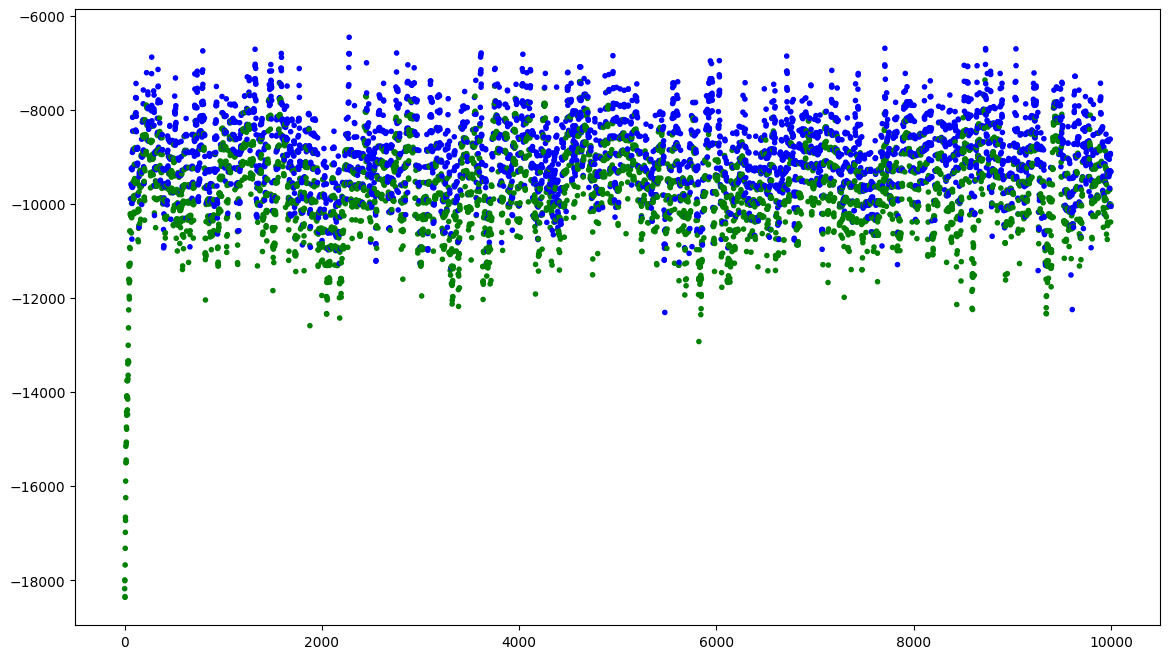

In [27]:
plt.figure(figsize=(14,8))
colors = ["green" if valid(history_state[i]) else "blue" for i, (_, value) in enumerate(history_fitness)]
markers = ["x" if valid(history_state[i]) else "o" for i, (_, value) in enumerate(history_fitness)]

plt.scatter(range(len(history_fitness)), [value for _, value in history_fitness], marker=markers, color=colors)
#plt.plot(range(len(history_fitness)), list(accumulate([value for _, value in history_fitness], max)),color="red")
plt.show()